In [7]:
#preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
import string
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from scipy.sparse import issparse

#models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import time
#evaluation
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score,confusion_matrix,precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Download resources if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
df = pd.read_json('data.json', lines=True)

In [11]:
df.columns

Index(['_id', 'reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime', 'category',
       'class'],
      dtype='object')

In [7]:
df.shape

(1997140, 12)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1997140 entries, 0 to 1997139
Data columns (total 12 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   _id             object
 1   reviewerID      object
 2   asin            object
 3   reviewerName    object
 4   helpful         object
 5   reviewText      object
 6   overall         int64 
 7   summary         object
 8   unixReviewTime  int64 
 9   reviewTime      object
 10  category        object
 11  class           int64 
dtypes: int64(3), object(9)
memory usage: 182.8+ MB


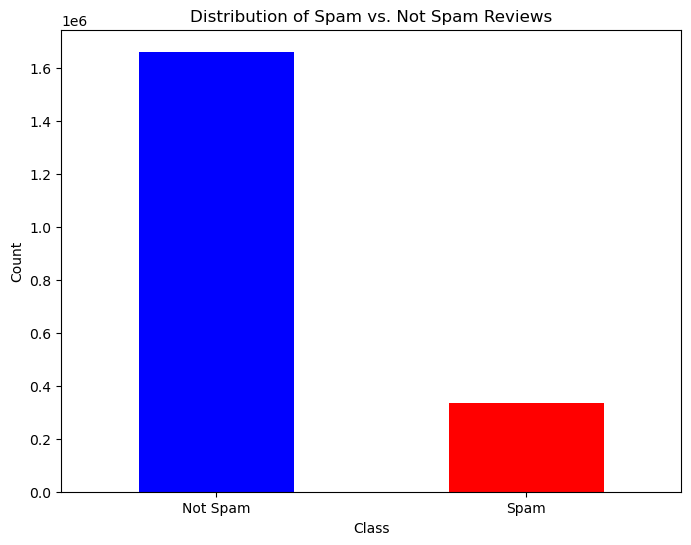

In [11]:
# Count the number of spam and not spam reviews
spam_counts = df['class'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
spam_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Spam vs. Not Spam Reviews')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Spam', 'Spam'], rotation=0)
plt.show()

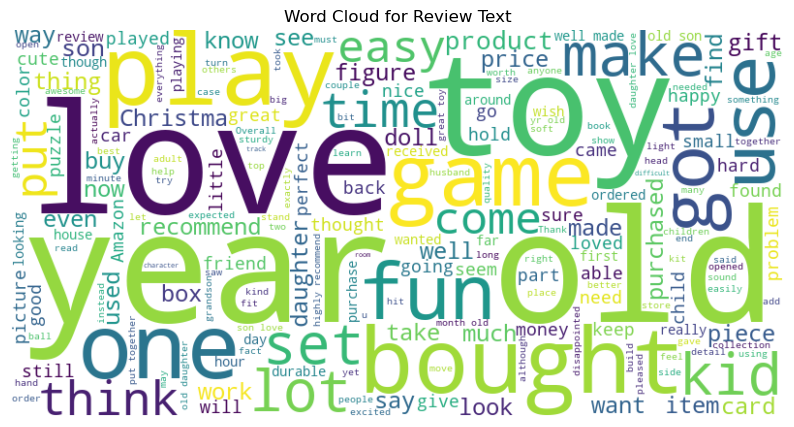

In [13]:
# Combine all review text into one string
review_text = ' '.join(df['reviewText'].astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(review_text)

# Plotting
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Review Text')
plt.axis('off')
plt.show()

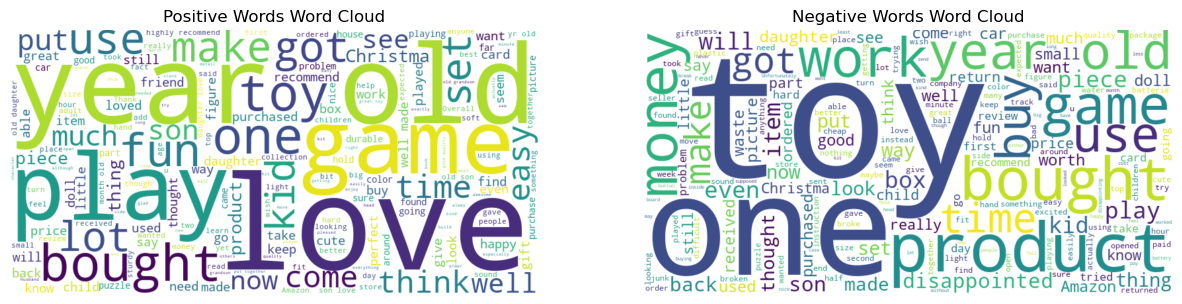

In [15]:
# Separate positive and negative reviews based on overall rating
positive_reviews = ' '.join(df[df['overall'] >= 4]['reviewText'].astype(str))
negative_reviews = ' '.join(df[df['overall'] <= 2]['reviewText'].astype(str))

# Generate word clouds for positive and negative reviews
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Plotting
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Words Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Words Word Cloud')
plt.axis('off')

plt.show()


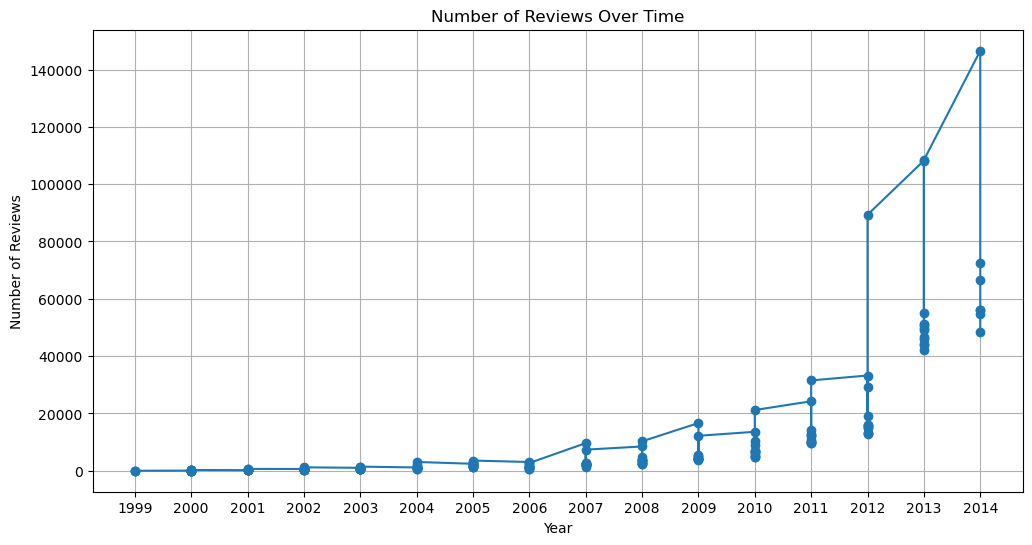

In [17]:
# Convert reviewTime to datetime
df['reviewTime'] = pd.to_datetime(df['reviewTime'])

# Extract year and month from reviewTime
df['Year'] = df['reviewTime'].dt.year
df['Month'] = df['reviewTime'].dt.month

# Group by year and month, count the number of reviews
review_counts = df.groupby(['Year', 'Month']).size().reset_index(name='Number of Reviews')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(review_counts['Year'], review_counts['Number of Reviews'], marker='o', linestyle='-')
plt.title('Number of Reviews Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.xticks(review_counts['Year'].unique())
plt.show()

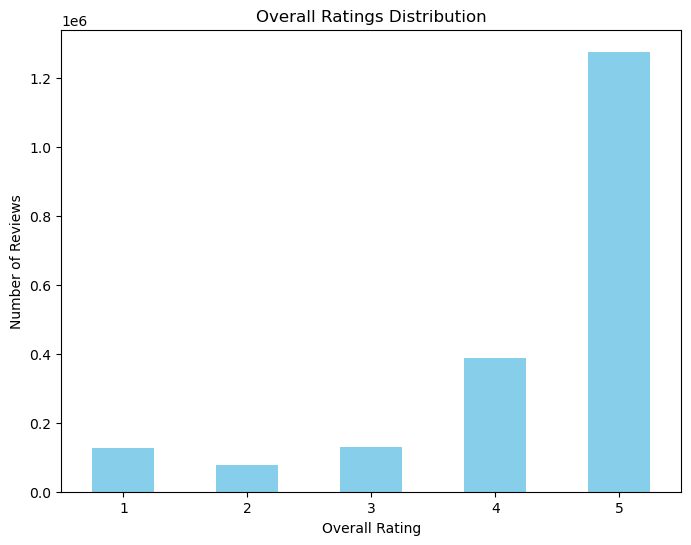

In [19]:
# Count the number of reviews for each overall rating
overall_counts = df['overall'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(8, 6))
overall_counts.plot(kind='bar', color='skyblue')
plt.title('Overall Ratings Distribution')
plt.xlabel('Overall Rating')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()


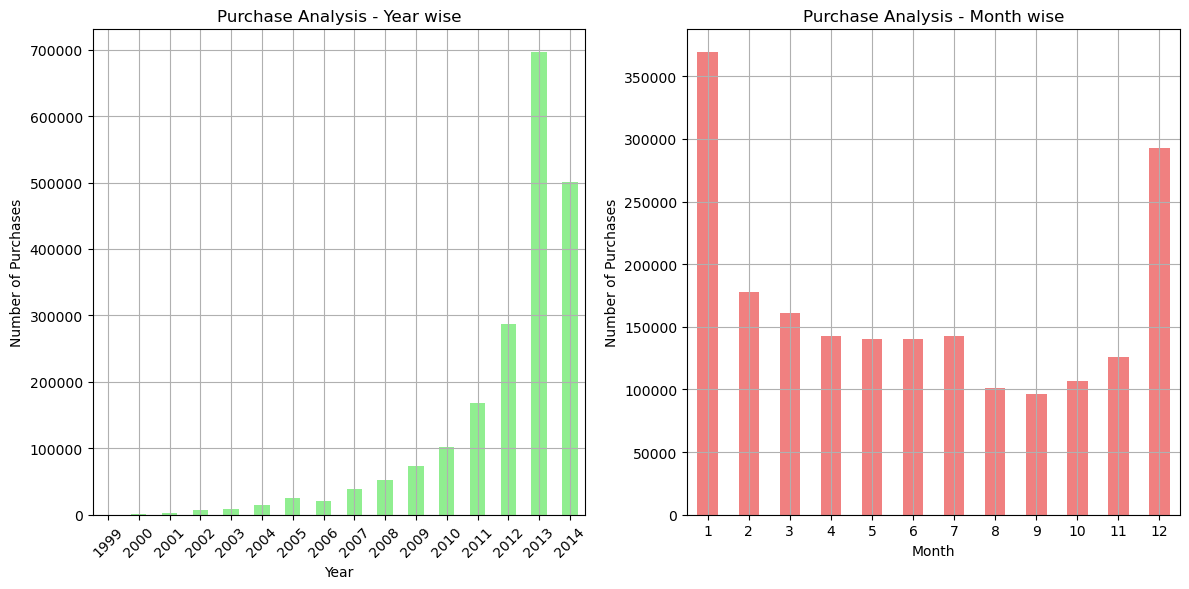

In [21]:
# Group by Year and count the number of purchases
purchase_yearly = df.groupby(df['reviewTime'].dt.year)['asin'].count()

# Group by Month and count the number of purchases
purchase_monthly = df.groupby(df['reviewTime'].dt.month)['asin'].count()

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
purchase_yearly.plot(kind='bar', color='lightgreen')
plt.title('Purchase Analysis - Year wise')
plt.xlabel('Year')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(1, 2, 2)
purchase_monthly.plot(kind='bar', color='lightcoral')
plt.title('Purchase Analysis - Month wise')
plt.xlabel('Month')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=0)
plt.grid(True)

plt.tight_layout()
plt.show()


In [19]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [13]:
def clean_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [15]:
#Lemmatize words
def Lemm(text):
    words = word_tokenize(text)  # Tokenize the text
    words = [word for word in words if word not in stop_words]  # Remove stop words
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatize the words
    return ' '.join(words)  # Join words back into a string

In [21]:
df['cleaned_text'] = df['reviewText'].apply(clean_text)
df['text_lemm'] = df['reviewText'].apply(Lemm)
df['cleaned_text_lemm'] = df['text_lemm'].apply(clean_text)

In [45]:
vectorization = TfidfVectorizer(analyzer = 'word', min_df=0.0, max_features=2000)
reviews = df['reviewText'].to_list()
reviews_lemm = df['cleaned_text_lemm'].to_list()
reviews_cleaned_text = df['cleaned_text'].to_list()
reviews_cleand_text_lem = df['text_lemm'].to_list()

X1 = vectorization.fit_transform(reviews)
X2 = vectorization.fit_transform(reviews_lemm)
X3 = vectorization.fit_transform(reviews_cleaned_text)
X4 = vectorization.fit_transform(reviews_cleand_text_lem)

In [47]:
def split_80_10_10_multiple(X, y, iterations=5):
    splits = []
    for split_num in range(1, iterations+1):
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y)
        X_test, X_eval, y_test, y_eval = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)
        splits.append((X_train, X_test, X_eval, y_train, y_test, y_eval))
        
    return(splits)

splits1 = split_80_10_10_multiple(X1, df['class'])  # Original dataset
splits2 = split_80_10_10_multiple(X2, df['class'])  # Lemmatized dataset
splits3 = split_80_10_10_multiple(X3, df['class'])  # Cleaned dataset
splits4 = split_80_10_10_multiple(X4, df['class'])  # Cleaned & Lemmatized dataset

In [49]:
for i in range(5):
    X_train, X_test, X_eval, y_train, y_test, y_eval = splits1[i]
    globals()[f'X_train1_split{i+1}'] = X_train
    globals()[f'X_test1_split{i+1}'] = X_test
    globals()[f'X_eval1_split{i+1}'] = X_eval
    globals()[f'y_train1_split{i+1}'] = y_train
    globals()[f'y_test1_split{i+1}'] = y_test
    globals()[f'y_eval1_split{i+1}'] = y_eval

for i in range(5):
    X_train, X_test, X_eval, y_train, y_test, y_eval = splits2[i]
    globals()[f'X_train2_split{i+1}'] = X_train
    globals()[f'X_test2_split{i+1}'] = X_test
    globals()[f'X_eval2_split{i+1}'] = X_eval
    globals()[f'y_train2_split{i+1}'] = y_train
    globals()[f'y_test2_split{i+1}'] = y_test
    globals()[f'y_eval2_split{i+1}'] = y_eval

for i in range(5):
    X_train, X_test, X_eval, y_train, y_test, y_eval = splits3[i]
    globals()[f'X_train3_split{i+1}'] = X_train
    globals()[f'X_test3_split{i+1}'] = X_test
    globals()[f'X_eval3_split{i+1}'] = X_eval
    globals()[f'y_train3_split{i+1}'] = y_train
    globals()[f'y_test3_split{i+1}'] = y_test
    globals()[f'y_eval3_split{i+1}'] = y_eval

for i in range(5):
    X_train, X_test, X_eval, y_train, y_test, y_eval = splits4[i]
    globals()[f'X_train4_split{i+1}'] = X_train
    globals()[f'X_test4_split{i+1}'] = X_test
    globals()[f'X_eval4_split{i+1}'] = X_eval
    globals()[f'y_train4_split{i+1}'] = y_train
    globals()[f'y_test4_split{i+1}'] = y_test
    globals()[f'y_eval4_split{i+1}'] = y_eval

In [51]:
def plot_roc_curve(model, X_test, y_test, model_name):
    """
    Plot ROC curve for the given model and test data.
    """
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)[:, 1]
    else:
        y_probs = model.decision_function(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.title(f"ROC Curve for {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

In [53]:
def adaptive_k_fold_evaluation(model, X, y, k_min=5, k_max=10, max_duration=60):
    """
    Perform k-fold evaluation, adapting k (number of folds) based on model duration.
    """
    for k in range(k_min, k_max + 1):
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        precision_scores = []
        recall_scores = []
        f1_scores = []
        fold_durations = []
        
        print(f"Running {k}-fold evaluation...")
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            start_time = time.time()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            duration = time.time() - start_time
            
            fold_durations.append(duration)
            precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
            recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
            f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
        
        avg_duration = np.mean(fold_durations)
        if avg_duration * k > max_duration:
            print(f"Stopping at {k - 1} folds due to time constraints (Avg. Duration: {avg_duration:.2f}s).")
            break

    return {
        "Folds": k - 1,
        "Precision": np.mean(precision_scores),
        "Recall": np.mean(recall_scores),
        "F1-Score": np.mean(f1_scores),
        "Avg Duration per Fold": avg_duration
    }


In [55]:
def train_evaluate_visualize(model, X_train, y_train, X_test, y_test, k_min=5, k_max=10, max_duration=60, model_name="Model"):
    """
    Train, evaluate, perform adaptive k-fold evaluation, and visualize ROC curve for the given model and data.
    """
    # Convert target labels to dense if needed
    if hasattr(y_train, "toarray"):
        y_train = y_train.toarray().ravel()  # Ensure 1D
    if hasattr(y_test, "toarray"):
        y_test = y_test.toarray().ravel()  # Ensure 1D

    # Train and evaluate
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    # Print evaluation metrics
    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # Adaptive K-Fold Evaluation
    k_fold_results = adaptive_k_fold_evaluation(model, X_train, y_train, k_min, k_max, max_duration)
    print(f"K-Fold Results ({k_fold_results['Folds']} folds):")
    print(f"Precision: {k_fold_results['Precision']:.4f}, Recall: {k_fold_results['Recall']:.4f}, F1-Score: {k_fold_results['F1-Score']:.4f}")
    print(f"Avg Duration per Fold: {k_fold_results['Avg Duration per Fold']:.2f}s")
    
    # ROC Curve
    plot_roc_curve(model, X_test, y_test, model_name)
    
    return accuracy, precision, recall, f1, cm


In [57]:
models = [
    ("Logistic Regression", LogisticRegression(max_iter=400)),
    ("Multinomial Naive Bayes", MultinomialNB()),
    ("Linear Support Vector Classifier", LinearSVC()),
    ("Perceptron", Perceptron()),
    ("XGBoost", XGBClassifier())
]


In [59]:
datasets = []

# For the "Original" dataset
for i in range(5):
    datasets.append((
        f"Original - Split {i+1}",
        globals()[f'X_train1_split{i+1}'], globals()[f'y_train1_split{i+1}'],
        globals()[f'X_test1_split{i+1}'], globals()[f'y_test1_split{i+1}'],
        globals()[f'X_eval1_split{i+1}'], globals()[f'y_eval1_split{i+1}']
    ))

# For the "Lemmatized" dataset
for i in range(5):
    datasets.append((
        f"Lemmatized - Split {i+1}",
        globals()[f'X_train2_split{i+1}'], globals()[f'y_train2_split{i+1}'],
        globals()[f'X_test2_split{i+1}'], globals()[f'y_test2_split{i+1}'],
        globals()[f'X_eval2_split{i+1}'], globals()[f'y_eval2_split{i+1}']
    ))

# For the "Cleaned" dataset
for i in range(5):
    datasets.append((
        f"Cleaned - Split {i+1}",
        globals()[f'X_train3_split{i+1}'], globals()[f'y_train3_split{i+1}'],
        globals()[f'X_test3_split{i+1}'], globals()[f'y_test3_split{i+1}'],
        globals()[f'X_eval3_split{i+1}'], globals()[f'y_eval3_split{i+1}']
    ))

# For the "Cleaned and Lemmatized" dataset
for i in range(5):
    datasets.append((
        f"Cleaned and Lemmatized - Split {i+1}",
        globals()[f'X_train4_split{i+1}'], globals()[f'y_train4_split{i+1}'],
        globals()[f'X_test4_split{i+1}'], globals()[f'y_test4_split{i+1}'],
        globals()[f'X_eval4_split{i+1}'], globals()[f'y_eval4_split{i+1}']
    ))




Model: Logistic Regression, Dataset: Original - Split 1
Results for Logistic Regression - Original - Split 1:
Accuracy: 0.9117
Precision: 0.9071
Recall: 0.9117
F1-score: 0.9075
Confusion Matrix:
[[ 21156  12283]
 [  5361 160914]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
Stopping at 9 folds due to time constraints (Avg. Duration: 258.38s).
K-Fold Results (9 folds):
Precision: 0.9056, Recall: 0.9104, F1-Score: 0.9059
Avg Duration per Fold: 258.38s


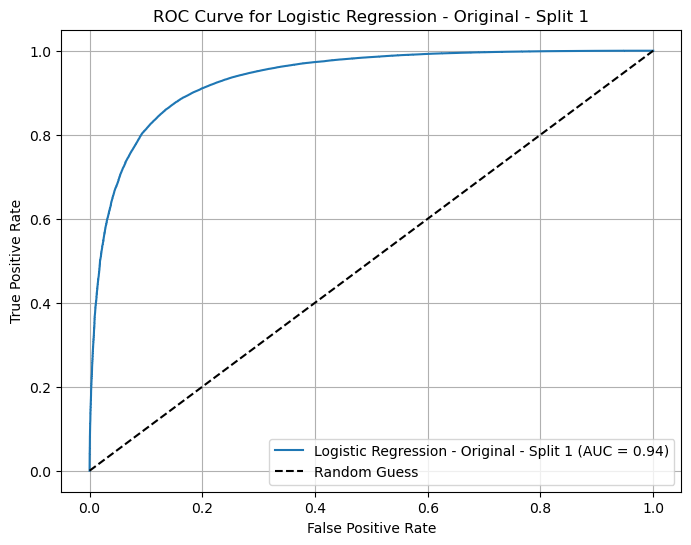


Model: Logistic Regression, Dataset: Original - Split 2
Results for Logistic Regression - Original - Split 2:
Accuracy: 0.9099
Precision: 0.9050
Recall: 0.9099
F1-score: 0.9053
Confusion Matrix:
[[ 20789  12650]
 [  5351 160924]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Stopping at 7 folds due to time constraints (Avg. Duration: 7.84s).
K-Fold Results (7 folds):
Precision: 0.9056, Recall: 0.9104, F1-Score: 0.9060
Avg Duration per Fold: 7.84s


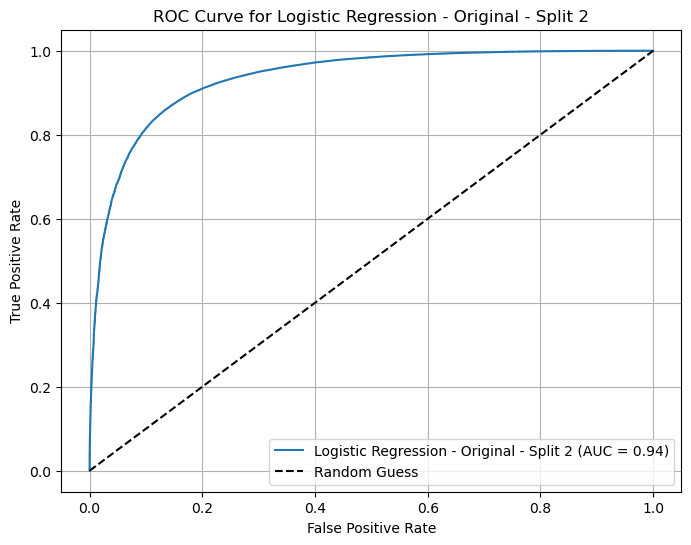


Model: Logistic Regression, Dataset: Original - Split 3
Results for Logistic Regression - Original - Split 3:
Accuracy: 0.9109
Precision: 0.9063
Recall: 0.9109
F1-score: 0.9066
Confusion Matrix:
[[ 21070  12369]
 [  5426 160849]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Stopping at 7 folds due to time constraints (Avg. Duration: 8.00s).
K-Fold Results (7 folds):
Precision: 0.9056, Recall: 0.9104, F1-Score: 0.9060
Avg Duration per Fold: 8.00s


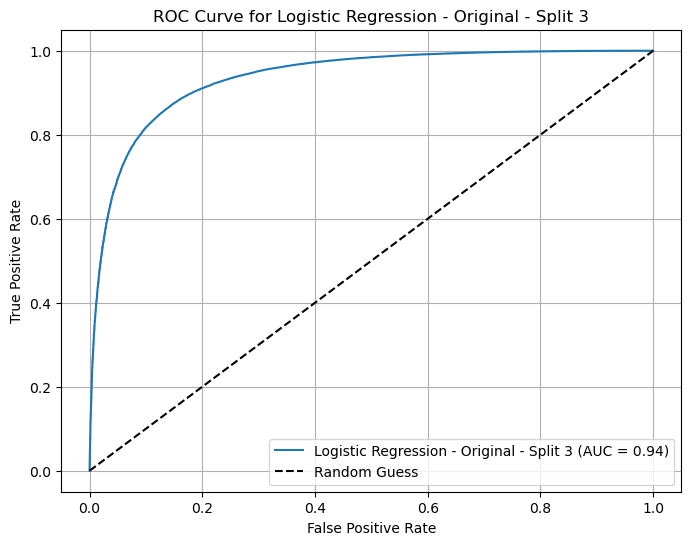


Model: Logistic Regression, Dataset: Original - Split 4
Results for Logistic Regression - Original - Split 4:
Accuracy: 0.9109
Precision: 0.9063
Recall: 0.9109
F1-score: 0.9067
Confusion Matrix:
[[ 21041  12398]
 [  5387 160888]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Stopping at 7 folds due to time constraints (Avg. Duration: 7.50s).
K-Fold Results (7 folds):
Precision: 0.9055, Recall: 0.9103, F1-Score: 0.9058
Avg Duration per Fold: 7.50s


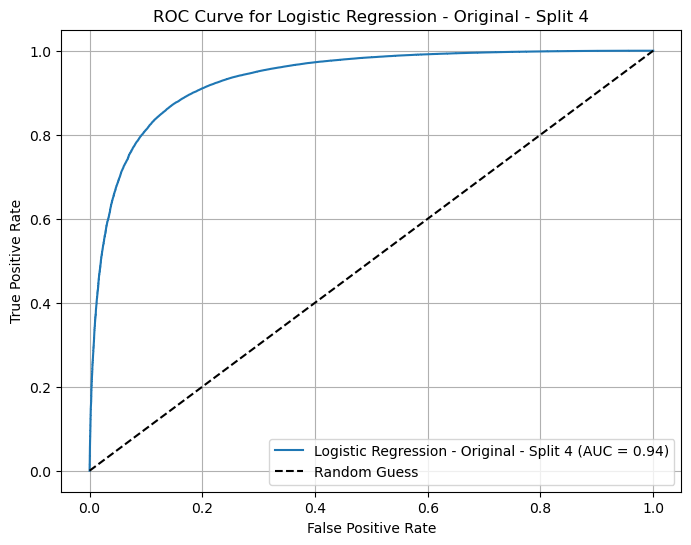


Model: Logistic Regression, Dataset: Original - Split 5
Results for Logistic Regression - Original - Split 5:
Accuracy: 0.9097
Precision: 0.9049
Recall: 0.9097
F1-score: 0.9053
Confusion Matrix:
[[ 20856  12582]
 [  5454 160822]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Stopping at 8 folds due to time constraints (Avg. Duration: 7.13s).
K-Fold Results (8 folds):
Precision: 0.9059, Recall: 0.9106, F1-Score: 0.9062
Avg Duration per Fold: 7.13s


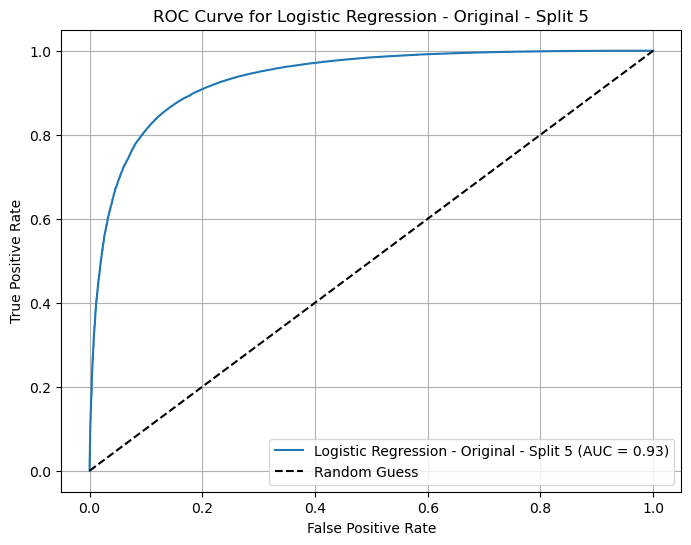


Model: Logistic Regression, Dataset: Lemmatized - Split 1
Results for Logistic Regression - Lemmatized - Split 1:
Accuracy: 0.9053
Precision: 0.8998
Recall: 0.9053
F1-score: 0.8996
Confusion Matrix:
[[ 19722  13716]
 [  5190 161086]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Stopping at 5 folds due to time constraints (Avg. Duration: 85.58s).
K-Fold Results (5 folds):
Precision: 0.8987, Recall: 0.9044, F1-Score: 0.8986
Avg Duration per Fold: 85.58s


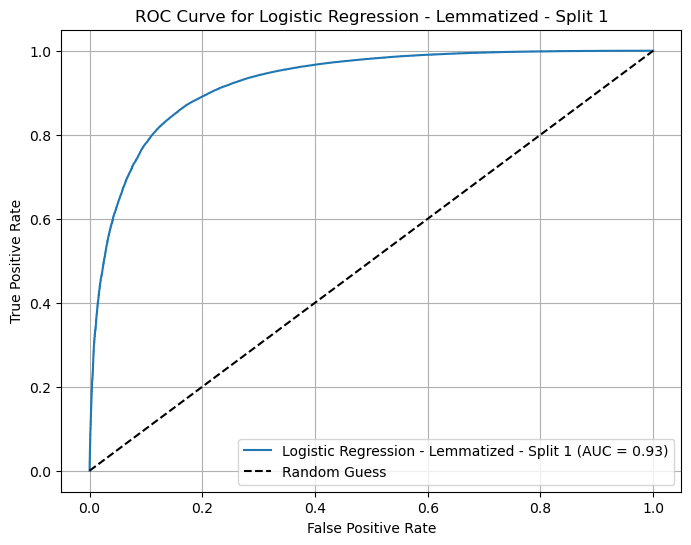


Model: Logistic Regression, Dataset: Lemmatized - Split 2
Results for Logistic Regression - Lemmatized - Split 2:
Accuracy: 0.9049
Precision: 0.8993
Recall: 0.9049
F1-score: 0.8990
Confusion Matrix:
[[ 19604  13835]
 [  5157 161118]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8988, Recall: 0.9045, F1-Score: 0.8986
Avg Duration per Fold: 4.79s


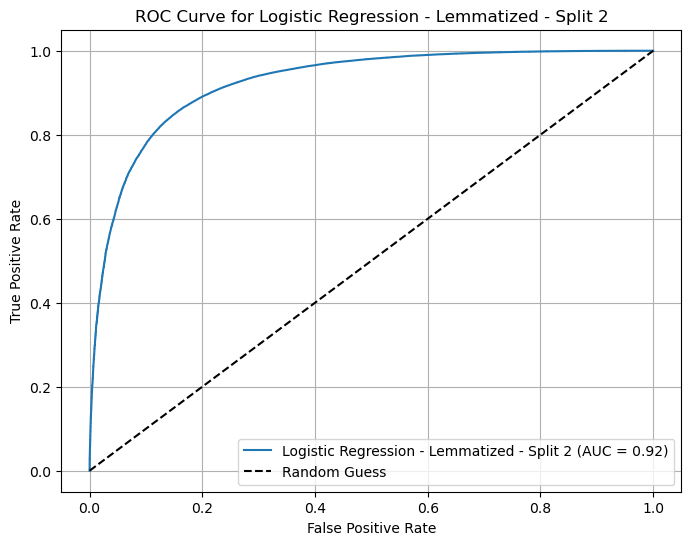


Model: Logistic Regression, Dataset: Lemmatized - Split 3
Results for Logistic Regression - Lemmatized - Split 3:
Accuracy: 0.9043
Precision: 0.8986
Recall: 0.9043
F1-score: 0.8985
Confusion Matrix:
[[ 19614  13825]
 [  5288 160987]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8988, Recall: 0.9045, F1-Score: 0.8987
Avg Duration per Fold: 5.28s


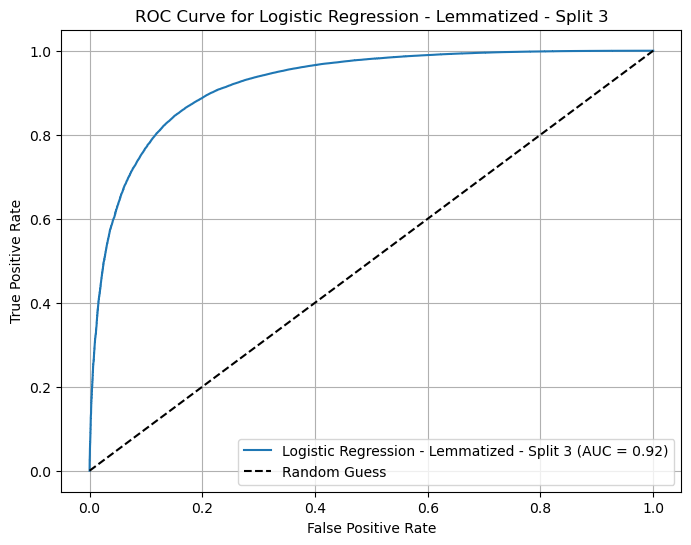


Model: Logistic Regression, Dataset: Lemmatized - Split 4
Results for Logistic Regression - Lemmatized - Split 4:
Accuracy: 0.9046
Precision: 0.8990
Recall: 0.9046
F1-score: 0.8991
Confusion Matrix:
[[ 19823  13616]
 [  5442 160833]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8988, Recall: 0.9045, F1-Score: 0.8987
Avg Duration per Fold: 4.61s


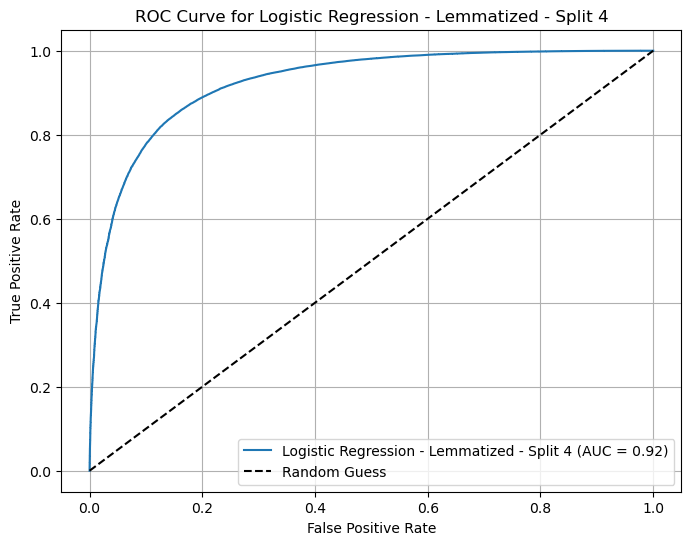


Model: Logistic Regression, Dataset: Lemmatized - Split 5
Results for Logistic Regression - Lemmatized - Split 5:
Accuracy: 0.9043
Precision: 0.8986
Recall: 0.9043
F1-score: 0.8985
Confusion Matrix:
[[ 19614  13825]
 [  5283 160992]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8987, Recall: 0.9044, F1-Score: 0.8986
Avg Duration per Fold: 5.01s


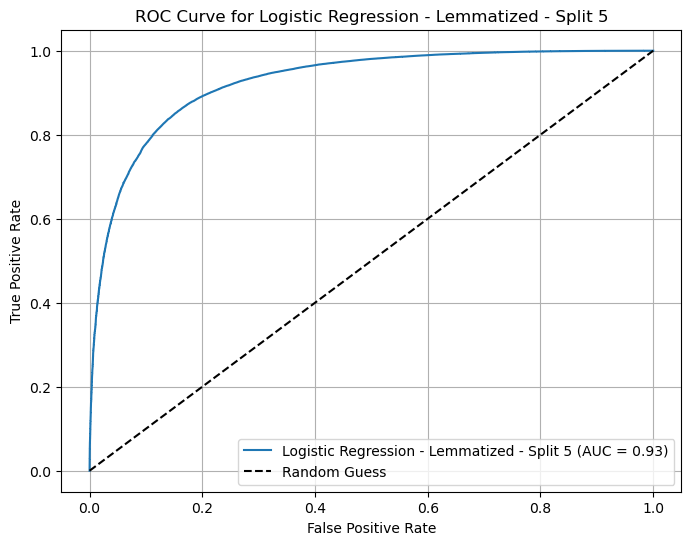


Model: Logistic Regression, Dataset: Cleaned - Split 1
Results for Logistic Regression - Cleaned - Split 1:
Accuracy: 0.9052
Precision: 0.8997
Recall: 0.9052
F1-score: 0.8997
Confusion Matrix:
[[ 19837  13602]
 [  5324 160951]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Stopping at 8 folds due to time constraints (Avg. Duration: 24.42s).
K-Fold Results (8 folds):
Precision: 0.8988, Recall: 0.9045, F1-Score: 0.8987
Avg Duration per Fold: 24.42s


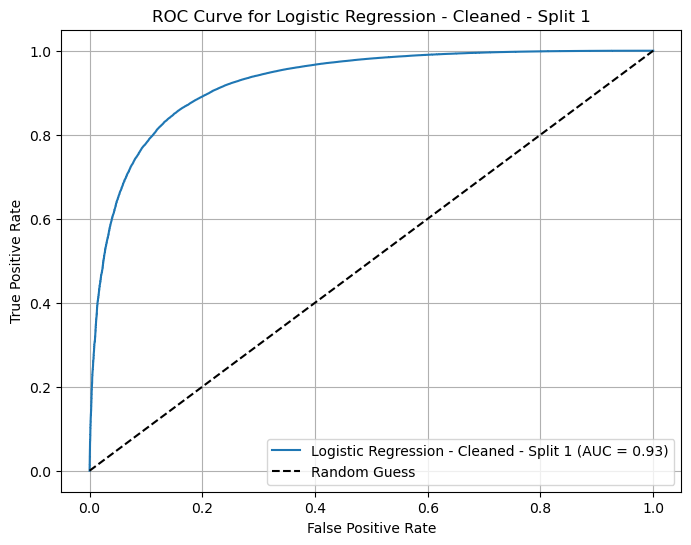


Model: Logistic Regression, Dataset: Cleaned - Split 2
Results for Logistic Regression - Cleaned - Split 2:
Accuracy: 0.9043
Precision: 0.8986
Recall: 0.9043
F1-score: 0.8984
Confusion Matrix:
[[ 19545  13894]
 [  5214 161061]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8990, Recall: 0.9046, F1-Score: 0.8989
Avg Duration per Fold: 4.46s


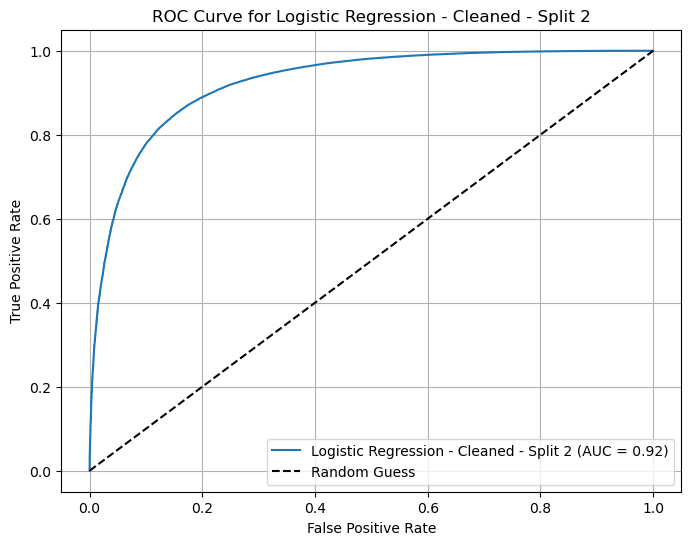


Model: Logistic Regression, Dataset: Cleaned - Split 3
Results for Logistic Regression - Cleaned - Split 3:
Accuracy: 0.9036
Precision: 0.8978
Recall: 0.9036
F1-score: 0.8977
Confusion Matrix:
[[ 19517  13922]
 [  5325 160950]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Stopping at 5 folds due to time constraints (Avg. Duration: 221.79s).
K-Fold Results (5 folds):
Precision: 0.8991, Recall: 0.9047, F1-Score: 0.8990
Avg Duration per Fold: 221.79s


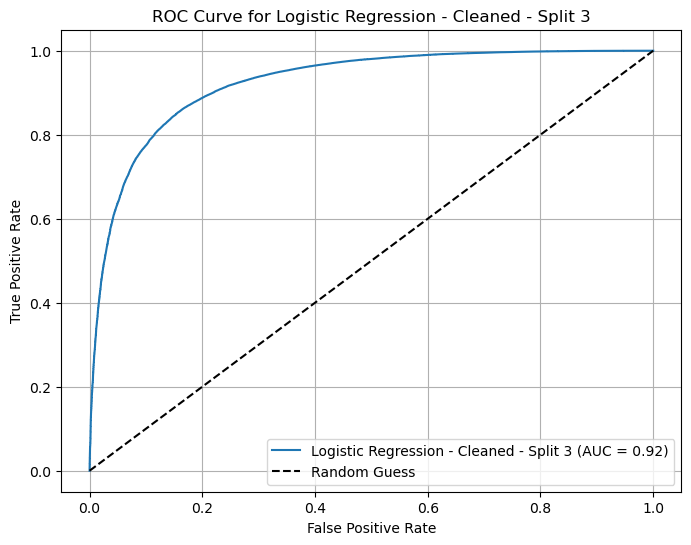


Model: Logistic Regression, Dataset: Cleaned - Split 4
Results for Logistic Regression - Cleaned - Split 4:
Accuracy: 0.9047
Precision: 0.8990
Recall: 0.9047
F1-score: 0.8989
Confusion Matrix:
[[ 19630  13808]
 [  5227 161049]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8989, Recall: 0.9046, F1-Score: 0.8988
Avg Duration per Fold: 4.70s


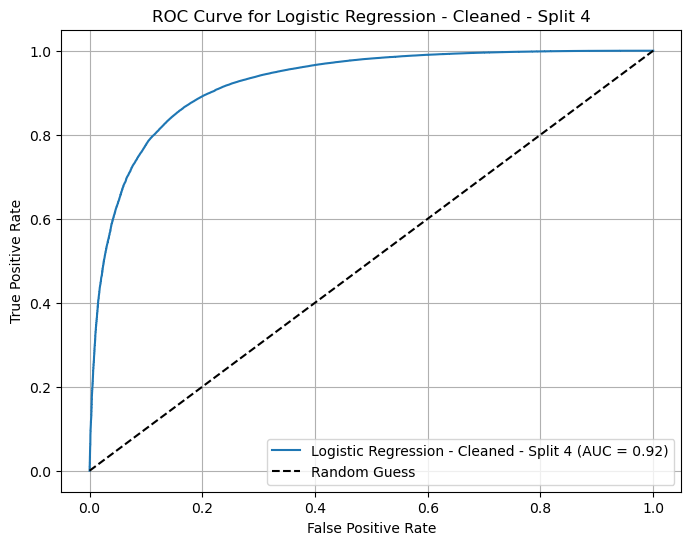


Model: Logistic Regression, Dataset: Cleaned - Split 5
Results for Logistic Regression - Cleaned - Split 5:
Accuracy: 0.9041
Precision: 0.8983
Recall: 0.9041
F1-score: 0.8982
Confusion Matrix:
[[ 19550  13888]
 [  5274 161002]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8990, Recall: 0.9046, F1-Score: 0.8989
Avg Duration per Fold: 4.39s


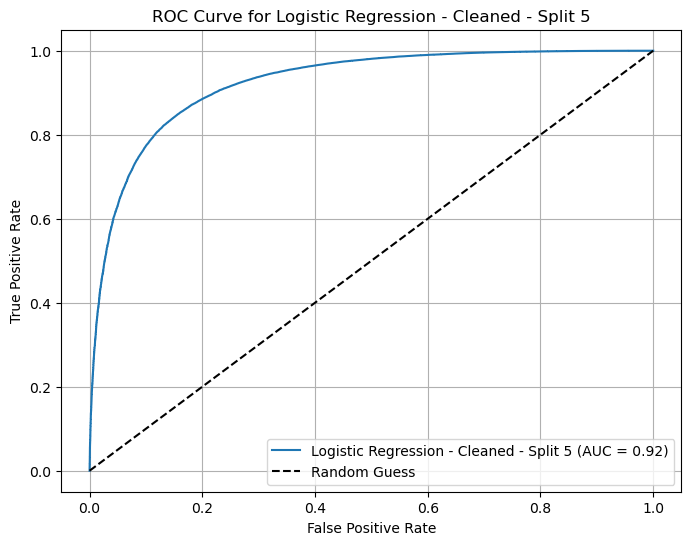


Model: Logistic Regression, Dataset: Cleaned and Lemmatized - Split 1
Results for Logistic Regression - Cleaned and Lemmatized - Split 1:
Accuracy: 0.9057
Precision: 0.9002
Recall: 0.9057
F1-score: 0.9001
Confusion Matrix:
[[ 19854  13585]
 [  5250 161025]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.9002, Recall: 0.9057, F1-Score: 0.9001
Avg Duration per Fold: 4.60s


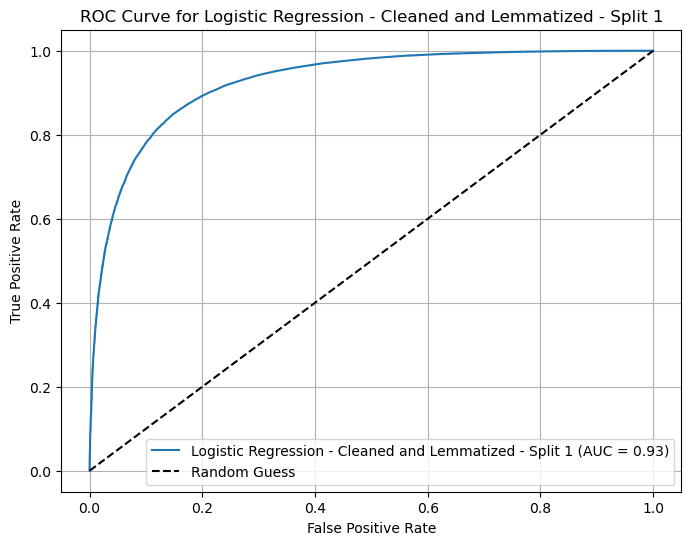


Model: Logistic Regression, Dataset: Cleaned and Lemmatized - Split 2
Results for Logistic Regression - Cleaned and Lemmatized - Split 2:
Accuracy: 0.9052
Precision: 0.8996
Recall: 0.9052
F1-score: 0.8997
Confusion Matrix:
[[ 19870  13568]
 [  5374 160902]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.9000, Recall: 0.9055, F1-Score: 0.8999
Avg Duration per Fold: 4.30s


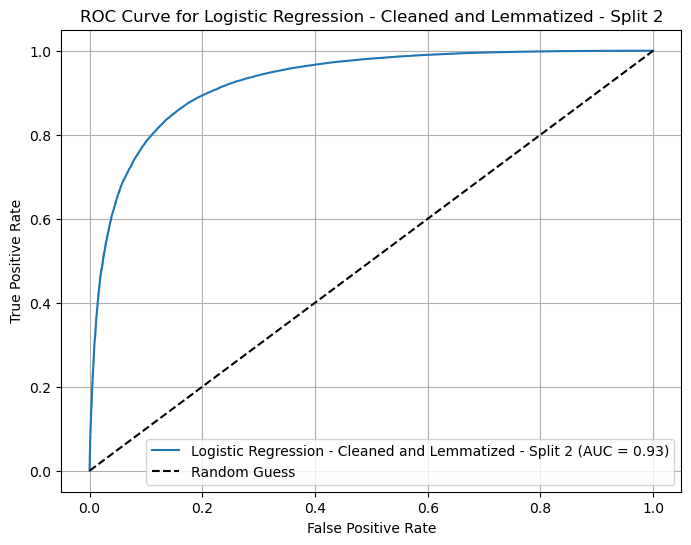


Model: Logistic Regression, Dataset: Cleaned and Lemmatized - Split 3
Results for Logistic Regression - Cleaned and Lemmatized - Split 3:
Accuracy: 0.9057
Precision: 0.9003
Recall: 0.9057
F1-score: 0.9001
Confusion Matrix:
[[ 19807  13632]
 [  5193 161082]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.9002, Recall: 0.9057, F1-Score: 0.9002
Avg Duration per Fold: 5.21s


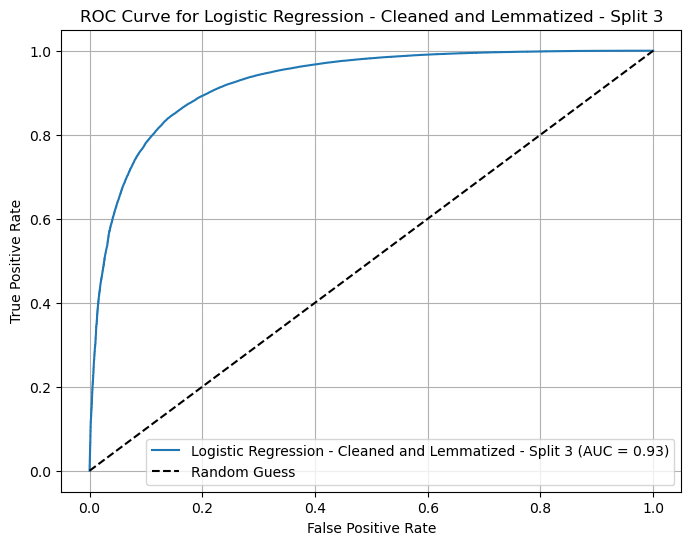


Model: Logistic Regression, Dataset: Cleaned and Lemmatized - Split 4
Results for Logistic Regression - Cleaned and Lemmatized - Split 4:
Accuracy: 0.9066
Precision: 0.9013
Recall: 0.9066
F1-score: 0.9011
Confusion Matrix:
[[ 19931  13508]
 [  5142 161133]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8998, Recall: 0.9053, F1-Score: 0.8997
Avg Duration per Fold: 4.70s


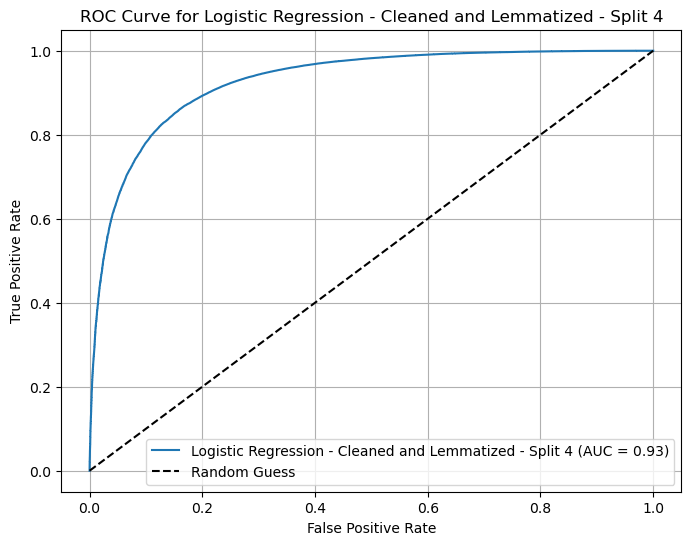


Model: Logistic Regression, Dataset: Cleaned and Lemmatized - Split 5
Results for Logistic Regression - Cleaned and Lemmatized - Split 5:
Accuracy: 0.9050
Precision: 0.8994
Recall: 0.9050
F1-score: 0.8994
Confusion Matrix:
[[ 19777  13661]
 [  5312 160964]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.9001, Recall: 0.9056, F1-Score: 0.9001
Avg Duration per Fold: 4.35s


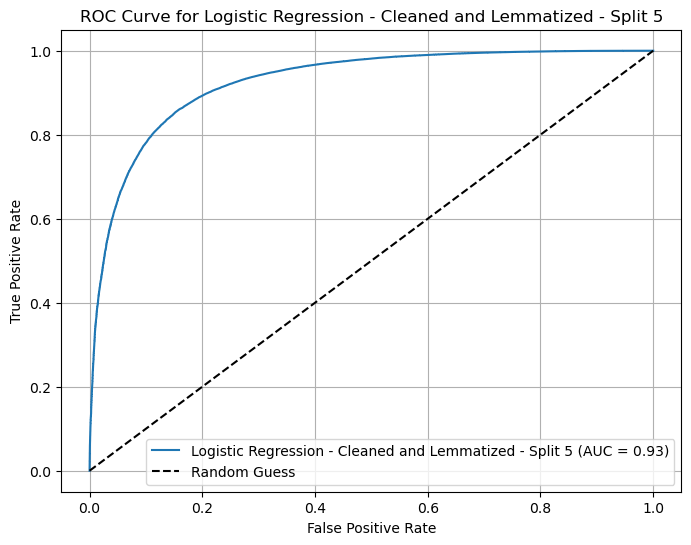


Model: Multinomial Naive Bayes, Dataset: Original - Split 1
Results for Multinomial Naive Bayes - Original - Split 1:
Accuracy: 0.8682
Precision: 0.8737
Recall: 0.8682
F1-score: 0.8339
Confusion Matrix:
[[  7881  25558]
 [   774 165501]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8722, Recall: 0.8670, F1-Score: 0.8319
Avg Duration per Fold: 0.34s


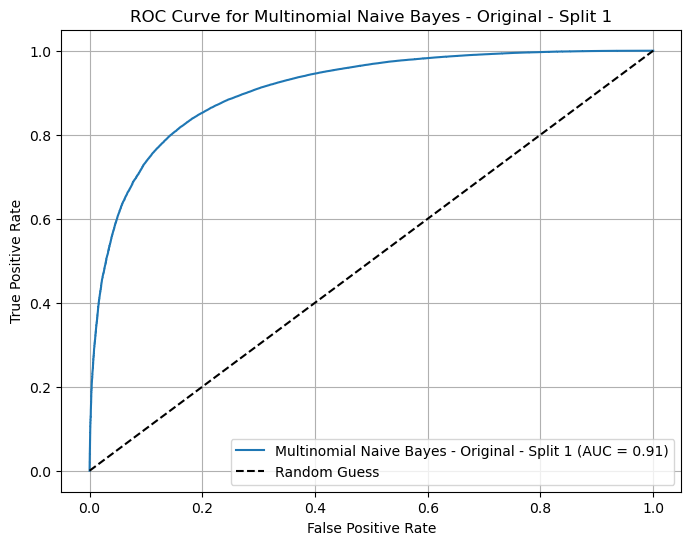


Model: Multinomial Naive Bayes, Dataset: Original - Split 2
Results for Multinomial Naive Bayes - Original - Split 2:
Accuracy: 0.8678
Precision: 0.8738
Recall: 0.8678
F1-score: 0.8332
Confusion Matrix:
[[  7779  25660]
 [   737 165538]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8721, Recall: 0.8669, F1-Score: 0.8318
Avg Duration per Fold: 0.34s


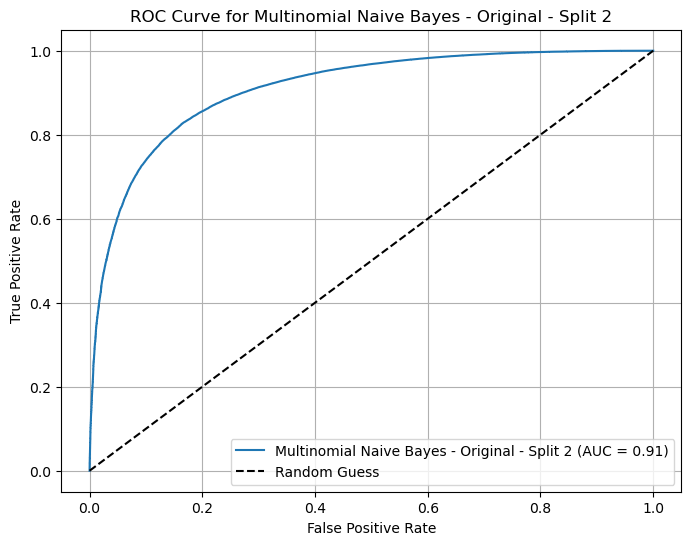


Model: Multinomial Naive Bayes, Dataset: Original - Split 3
Results for Multinomial Naive Bayes - Original - Split 3:
Accuracy: 0.8669
Precision: 0.8717
Recall: 0.8669
F1-score: 0.8319
Confusion Matrix:
[[  7663  25776]
 [   815 165460]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8724, Recall: 0.8671, F1-Score: 0.8321
Avg Duration per Fold: 0.34s


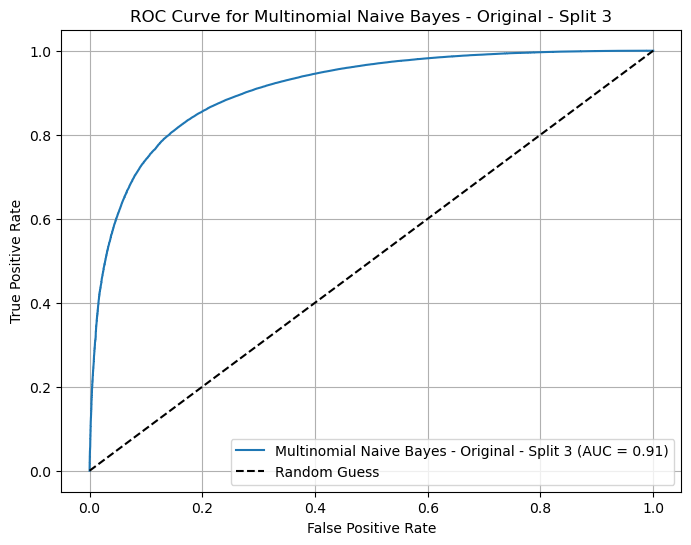


Model: Multinomial Naive Bayes, Dataset: Original - Split 4
Results for Multinomial Naive Bayes - Original - Split 4:
Accuracy: 0.8663
Precision: 0.8706
Recall: 0.8663
F1-score: 0.8310
Confusion Matrix:
[[  7578  25861]
 [   846 165429]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8724, Recall: 0.8671, F1-Score: 0.8320
Avg Duration per Fold: 0.34s


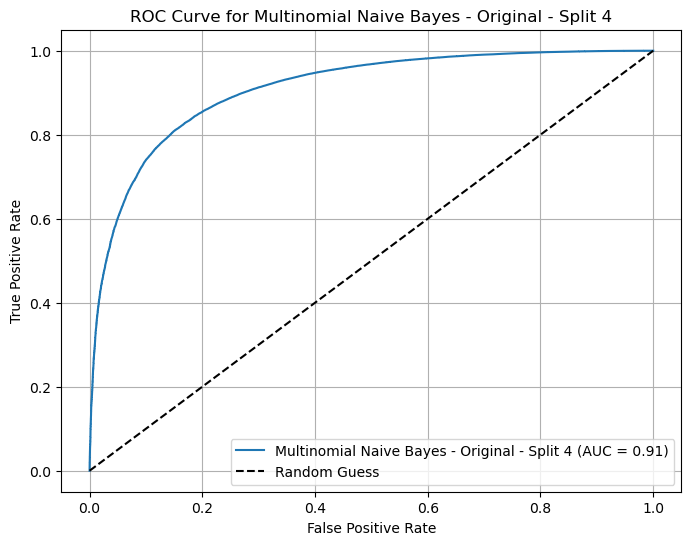


Model: Multinomial Naive Bayes, Dataset: Original - Split 5
Results for Multinomial Naive Bayes - Original - Split 5:
Accuracy: 0.8666
Precision: 0.8719
Recall: 0.8666
F1-score: 0.8311
Confusion Matrix:
[[  7556  25882]
 [   769 165507]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8724, Recall: 0.8671, F1-Score: 0.8321
Avg Duration per Fold: 0.35s


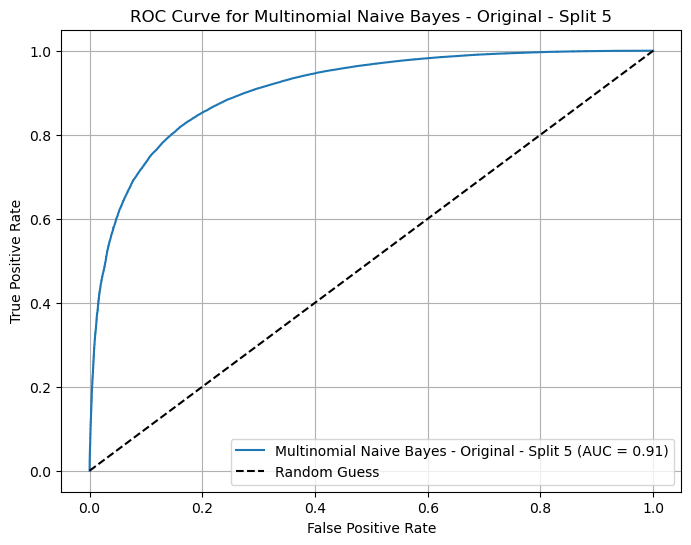


Model: Multinomial Naive Bayes, Dataset: Lemmatized - Split 1
Results for Multinomial Naive Bayes - Lemmatized - Split 1:
Accuracy: 0.8684
Precision: 0.8725
Recall: 0.8684
F1-score: 0.8349
Confusion Matrix:
[[  8054  25384]
 [   895 165381]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8721, Recall: 0.8682, F1-Score: 0.8346
Avg Duration per Fold: 0.26s


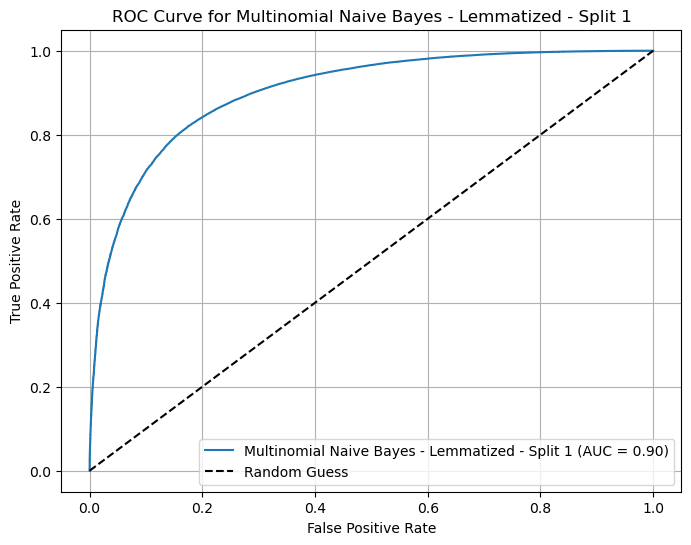


Model: Multinomial Naive Bayes, Dataset: Lemmatized - Split 2
Results for Multinomial Naive Bayes - Lemmatized - Split 2:
Accuracy: 0.8685
Precision: 0.8729
Recall: 0.8685
F1-score: 0.8350
Confusion Matrix:
[[  8050  25389]
 [   866 165409]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8721, Recall: 0.8683, F1-Score: 0.8347
Avg Duration per Fold: 0.26s


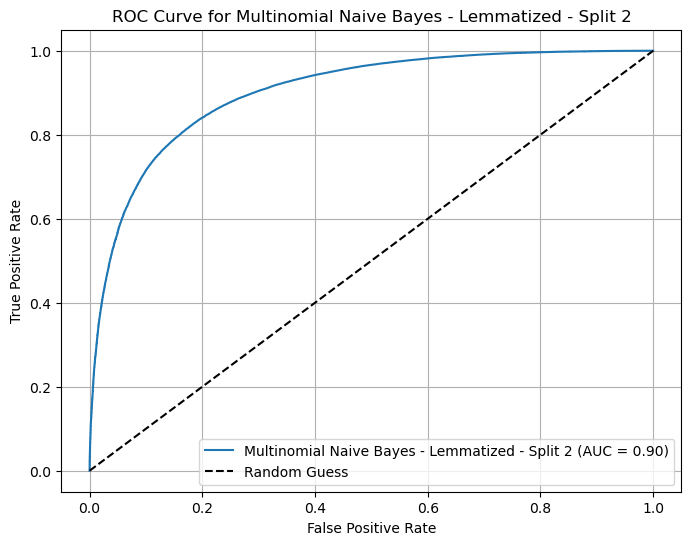


Model: Multinomial Naive Bayes, Dataset: Lemmatized - Split 3
Results for Multinomial Naive Bayes - Lemmatized - Split 3:
Accuracy: 0.8684
Precision: 0.8722
Recall: 0.8684
F1-score: 0.8349
Confusion Matrix:
[[  8064  25375]
 [   912 165363]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8723, Recall: 0.8684, F1-Score: 0.8349
Avg Duration per Fold: 0.26s


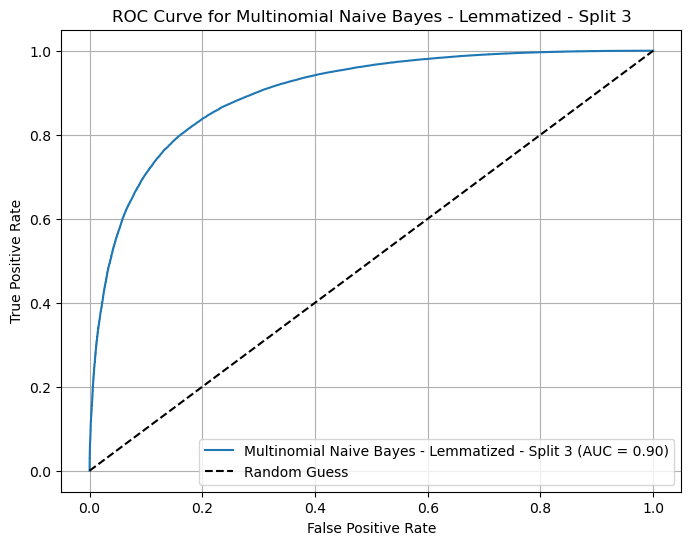


Model: Multinomial Naive Bayes, Dataset: Lemmatized - Split 4
Results for Multinomial Naive Bayes - Lemmatized - Split 4:
Accuracy: 0.8685
Precision: 0.8723
Recall: 0.8685
F1-score: 0.8353
Confusion Matrix:
[[  8106  25333]
 [   920 165355]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8722, Recall: 0.8682, F1-Score: 0.8346
Avg Duration per Fold: 0.27s


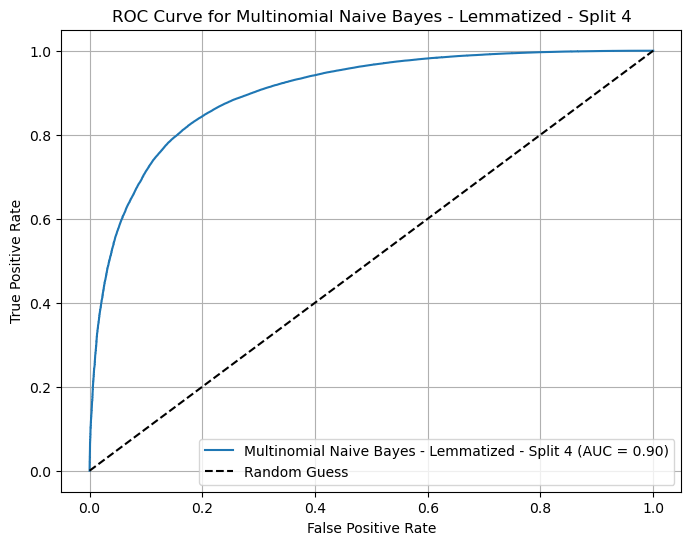


Model: Multinomial Naive Bayes, Dataset: Lemmatized - Split 5
Results for Multinomial Naive Bayes - Lemmatized - Split 5:
Accuracy: 0.8679
Precision: 0.8712
Recall: 0.8679
F1-score: 0.8344
Confusion Matrix:
[[  8022  25417]
 [   957 165318]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8723, Recall: 0.8683, F1-Score: 0.8347
Avg Duration per Fold: 0.26s


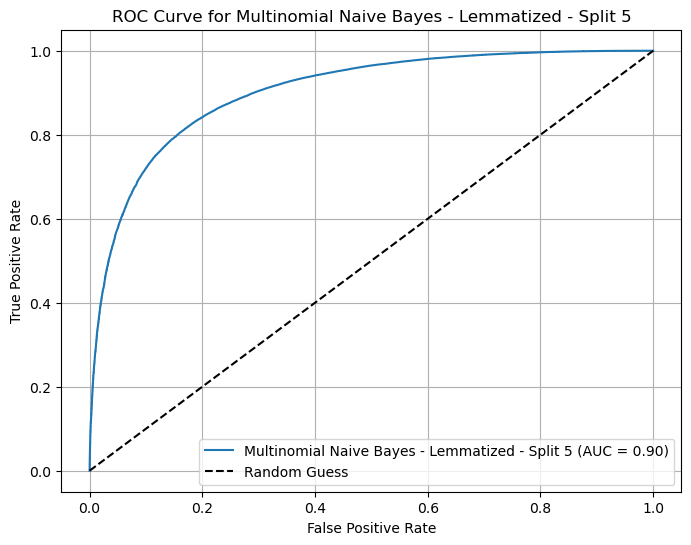


Model: Multinomial Naive Bayes, Dataset: Cleaned - Split 1
Results for Multinomial Naive Bayes - Cleaned - Split 1:
Accuracy: 0.8699
Precision: 0.8734
Recall: 0.8699
F1-score: 0.8378
Confusion Matrix:
[[  8425  25014]
 [   966 165309]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8725, Recall: 0.8692, F1-Score: 0.8366
Avg Duration per Fold: 0.29s


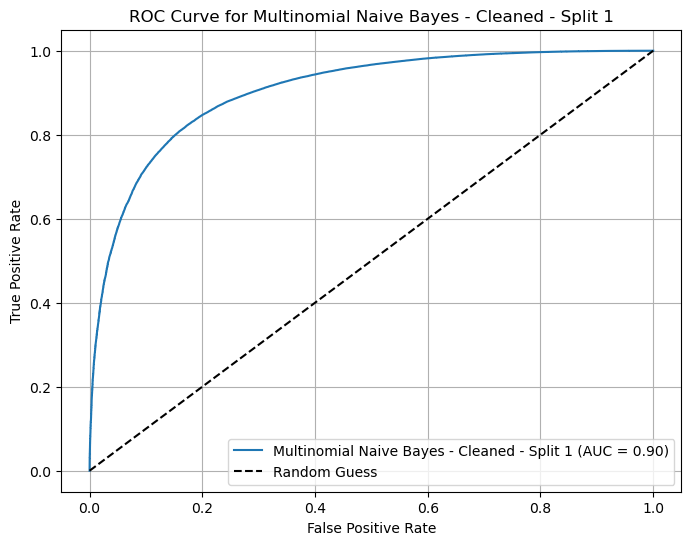


Model: Multinomial Naive Bayes, Dataset: Cleaned - Split 2
Results for Multinomial Naive Bayes - Cleaned - Split 2:
Accuracy: 0.8692
Precision: 0.8727
Recall: 0.8692
F1-score: 0.8366
Confusion Matrix:
[[  8275  25164]
 [   956 165319]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8724, Recall: 0.8692, F1-Score: 0.8366
Avg Duration per Fold: 0.26s


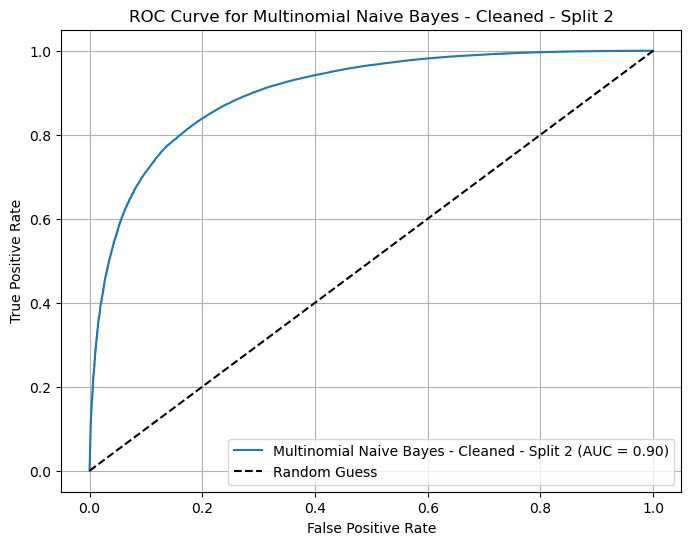


Model: Multinomial Naive Bayes, Dataset: Cleaned - Split 3
Results for Multinomial Naive Bayes - Cleaned - Split 3:
Accuracy: 0.8687
Precision: 0.8716
Recall: 0.8687
F1-score: 0.8359
Confusion Matrix:
[[  8218  25221]
 [   998 165277]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8724, Recall: 0.8691, F1-Score: 0.8364
Avg Duration per Fold: 0.26s


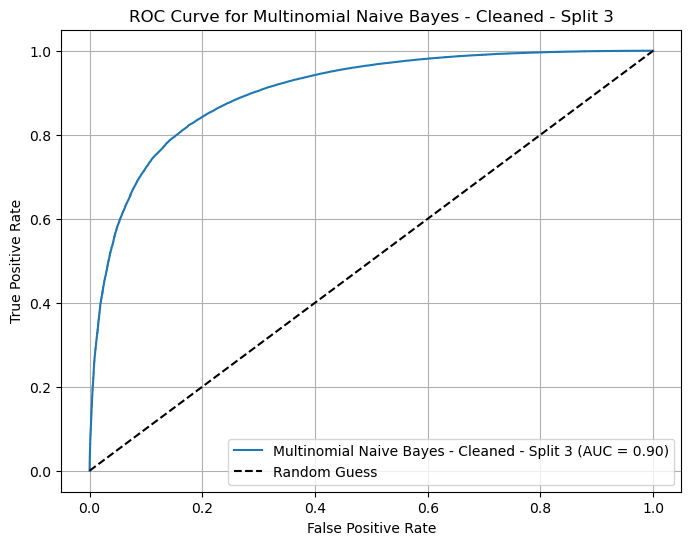


Model: Multinomial Naive Bayes, Dataset: Cleaned - Split 4
Results for Multinomial Naive Bayes - Cleaned - Split 4:
Accuracy: 0.8697
Precision: 0.8736
Recall: 0.8697
F1-score: 0.8371
Confusion Matrix:
[[  8328  25110]
 [   921 165355]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8723, Recall: 0.8690, F1-Score: 0.8364
Avg Duration per Fold: 0.26s


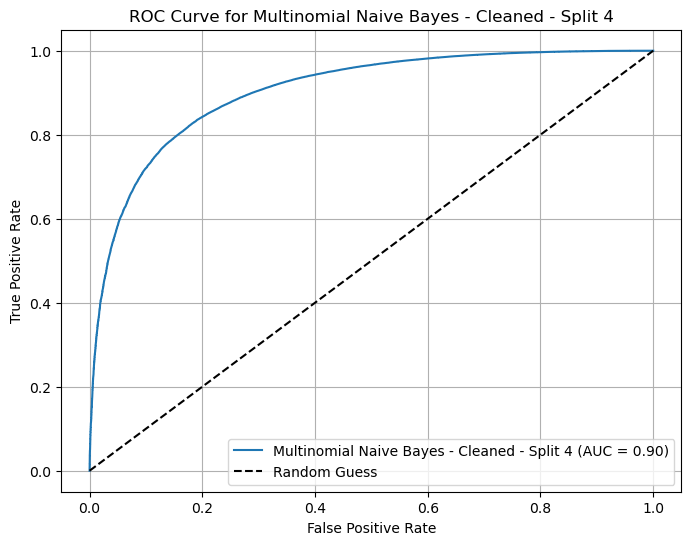


Model: Multinomial Naive Bayes, Dataset: Cleaned - Split 5
Results for Multinomial Naive Bayes - Cleaned - Split 5:
Accuracy: 0.8690
Precision: 0.8726
Recall: 0.8690
F1-score: 0.8361
Confusion Matrix:
[[  8221  25217]
 [   945 165331]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8724, Recall: 0.8692, F1-Score: 0.8367
Avg Duration per Fold: 0.26s


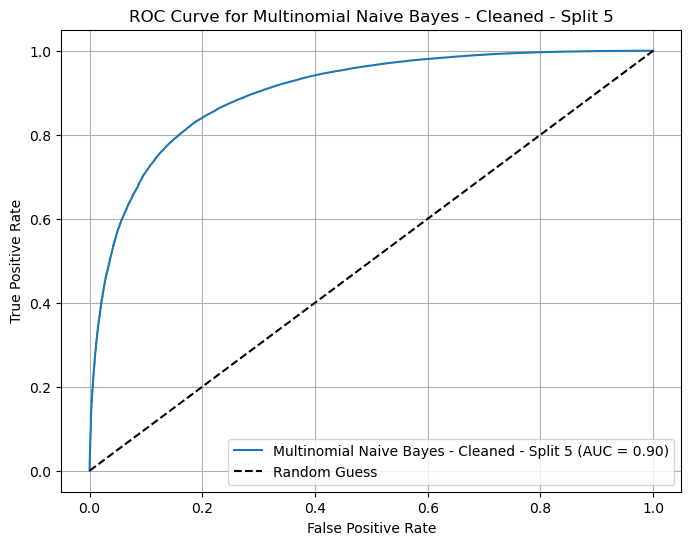


Model: Multinomial Naive Bayes, Dataset: Cleaned and Lemmatized - Split 1
Results for Multinomial Naive Bayes - Cleaned and Lemmatized - Split 1:
Accuracy: 0.8683
Precision: 0.8713
Recall: 0.8683
F1-score: 0.8350
Confusion Matrix:
[[  8106  25333]
 [   979 165296]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8715, Recall: 0.8681, F1-Score: 0.8345
Avg Duration per Fold: 0.28s


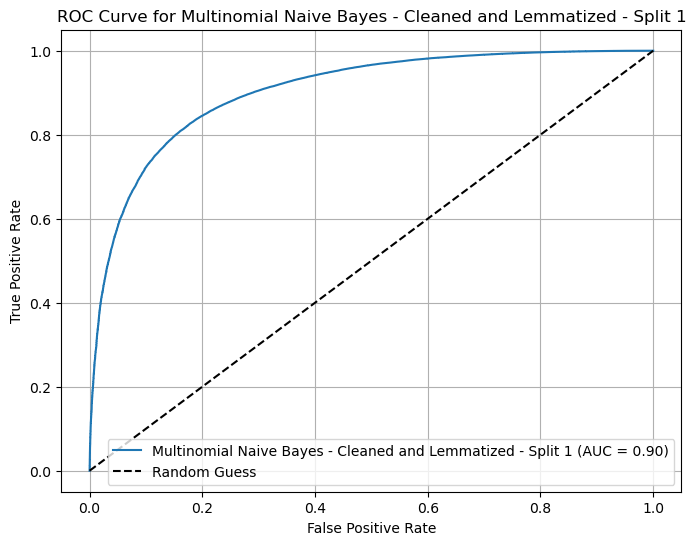


Model: Multinomial Naive Bayes, Dataset: Cleaned and Lemmatized - Split 2
Results for Multinomial Naive Bayes - Cleaned and Lemmatized - Split 2:
Accuracy: 0.8676
Precision: 0.8712
Recall: 0.8676
F1-score: 0.8336
Confusion Matrix:
[[  7916  25522]
 [   921 165355]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8716, Recall: 0.8682, F1-Score: 0.8348
Avg Duration per Fold: 0.28s


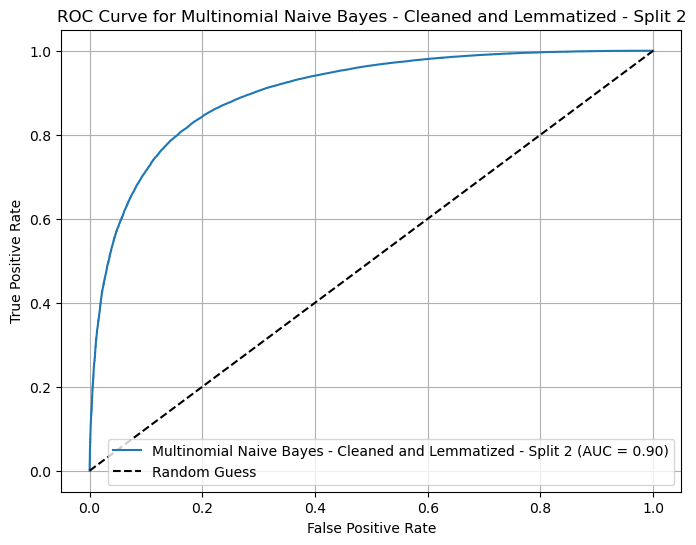


Model: Multinomial Naive Bayes, Dataset: Cleaned and Lemmatized - Split 3
Results for Multinomial Naive Bayes - Cleaned and Lemmatized - Split 3:
Accuracy: 0.8673
Precision: 0.8705
Recall: 0.8673
F1-score: 0.8332
Confusion Matrix:
[[  7878  25561]
 [   951 165324]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8715, Recall: 0.8682, F1-Score: 0.8348
Avg Duration per Fold: 0.27s


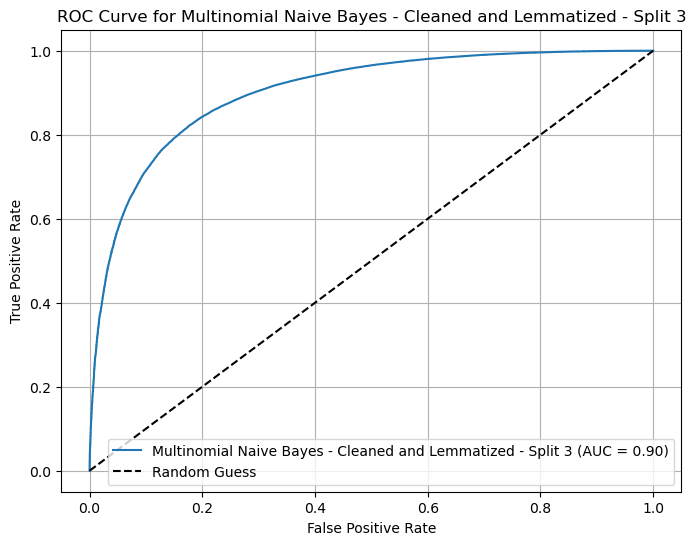


Model: Multinomial Naive Bayes, Dataset: Cleaned and Lemmatized - Split 4
Results for Multinomial Naive Bayes - Cleaned and Lemmatized - Split 4:
Accuracy: 0.8679
Precision: 0.8712
Recall: 0.8679
F1-score: 0.8342
Confusion Matrix:
[[  7996  25443]
 [   948 165327]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8715, Recall: 0.8681, F1-Score: 0.8346
Avg Duration per Fold: 0.27s


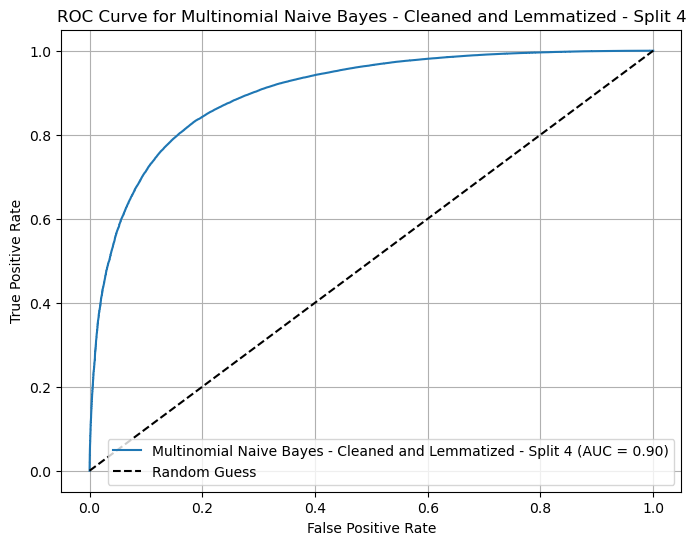


Model: Multinomial Naive Bayes, Dataset: Cleaned and Lemmatized - Split 5
Results for Multinomial Naive Bayes - Cleaned and Lemmatized - Split 5:
Accuracy: 0.8677
Precision: 0.8710
Recall: 0.8677
F1-score: 0.8340
Confusion Matrix:
[[  7976  25462]
 [   952 165324]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8715, Recall: 0.8681, F1-Score: 0.8347
Avg Duration per Fold: 0.27s


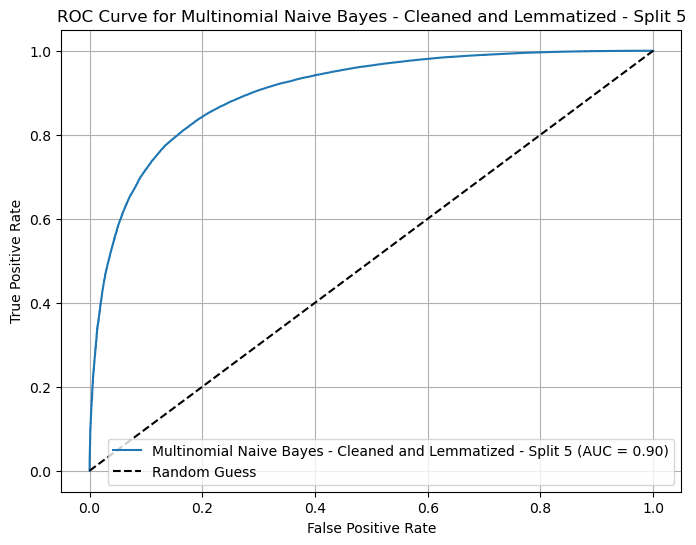


Model: Linear Support Vector Classifier, Dataset: Original - Split 1
Results for Linear Support Vector Classifier - Original - Split 1:
Accuracy: 0.9112
Precision: 0.9065
Recall: 0.9112
F1-score: 0.9063
Confusion Matrix:
[[ 20632  12807]
 [  4921 161354]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 14.24s).
K-Fold Results (4 folds):
Precision: 0.9057, Recall: 0.9105, F1-Score: 0.9054
Avg Duration per Fold: 14.24s


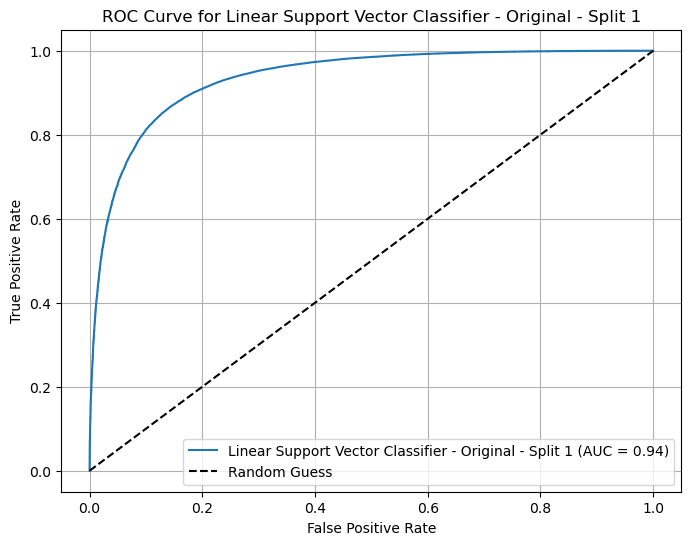


Model: Linear Support Vector Classifier, Dataset: Original - Split 2
Results for Linear Support Vector Classifier - Original - Split 2:
Accuracy: 0.9100
Precision: 0.9051
Recall: 0.9100
F1-score: 0.9047
Confusion Matrix:
[[ 20318  13121]
 [  4856 161419]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 14.61s).
K-Fold Results (4 folds):
Precision: 0.9055, Recall: 0.9104, F1-Score: 0.9053
Avg Duration per Fold: 14.61s


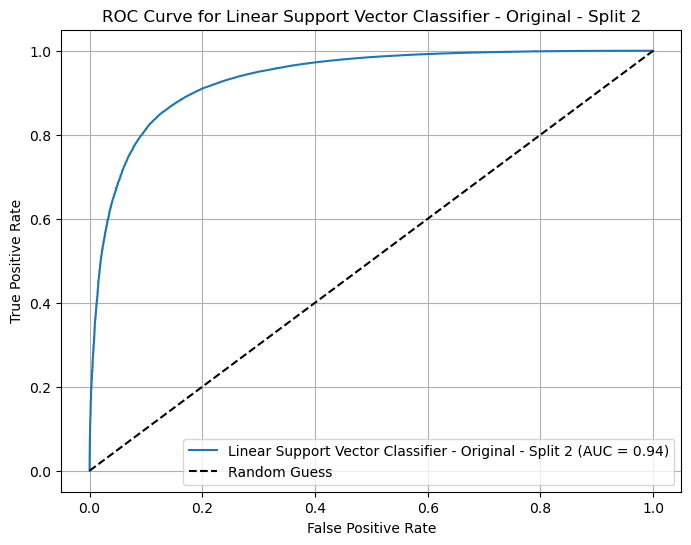


Model: Linear Support Vector Classifier, Dataset: Original - Split 3
Results for Linear Support Vector Classifier - Original - Split 3:
Accuracy: 0.9108
Precision: 0.9061
Recall: 0.9108
F1-score: 0.9059
Confusion Matrix:
[[ 20583  12856]
 [  4954 161321]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 28.38s).
K-Fold Results (4 folds):
Precision: 0.9056, Recall: 0.9104, F1-Score: 0.9053
Avg Duration per Fold: 28.38s


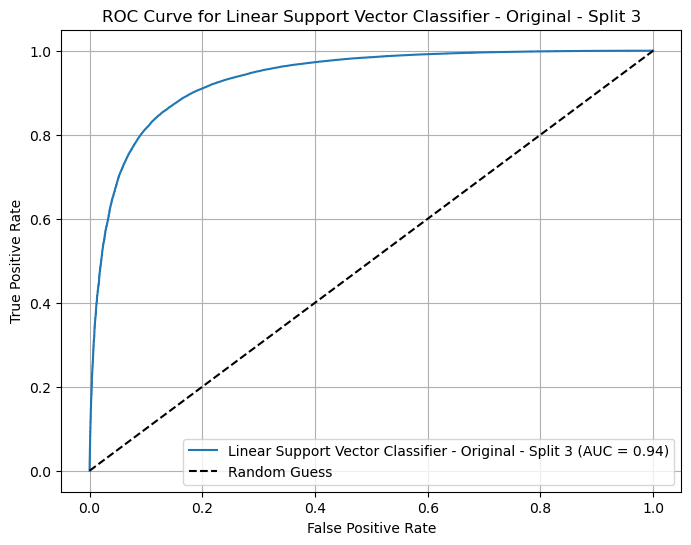


Model: Linear Support Vector Classifier, Dataset: Original - Split 4
Results for Linear Support Vector Classifier - Original - Split 4:
Accuracy: 0.9109
Precision: 0.9062
Recall: 0.9109
F1-score: 0.9059
Confusion Matrix:
[[ 20534  12905]
 [  4887 161388]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 14.73s).
K-Fold Results (4 folds):
Precision: 0.9055, Recall: 0.9103, F1-Score: 0.9053
Avg Duration per Fold: 14.73s


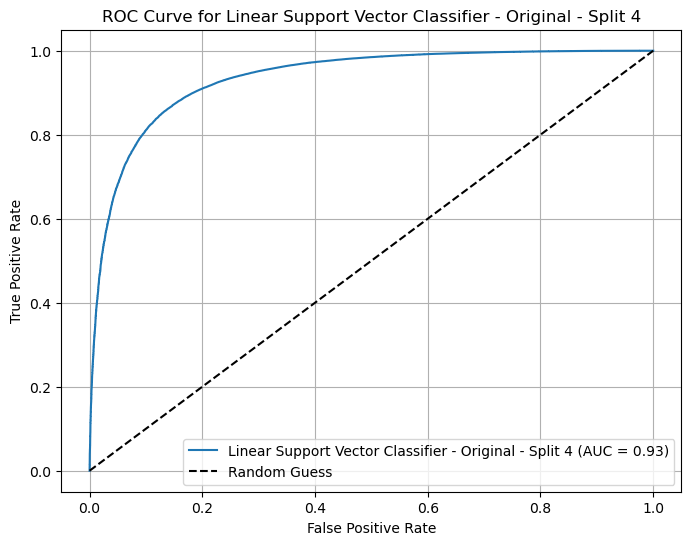


Model: Linear Support Vector Classifier, Dataset: Original - Split 5
Results for Linear Support Vector Classifier - Original - Split 5:
Accuracy: 0.9097
Precision: 0.9048
Recall: 0.9097
F1-score: 0.9046
Confusion Matrix:
[[ 20373  13065]
 [  4970 161306]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 14.78s).
K-Fold Results (4 folds):
Precision: 0.9058, Recall: 0.9106, F1-Score: 0.9056
Avg Duration per Fold: 14.78s


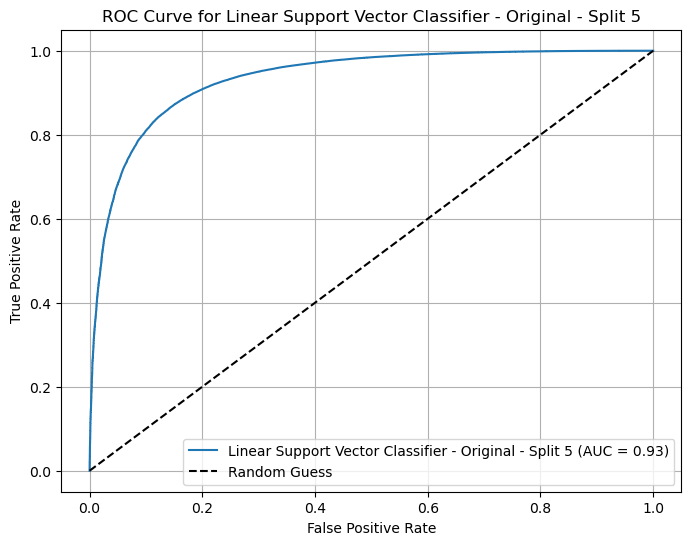


Model: Linear Support Vector Classifier, Dataset: Lemmatized - Split 1
Results for Linear Support Vector Classifier - Lemmatized - Split 1:
Accuracy: 0.9041
Precision: 0.8985
Recall: 0.9041
F1-score: 0.8972
Confusion Matrix:
[[ 18918  14520]
 [  4631 161645]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Stopping at 5 folds due to time constraints (Avg. Duration: 82.51s).
K-Fold Results (5 folds):
Precision: 0.8981, Recall: 0.9038, F1-Score: 0.8969
Avg Duration per Fold: 82.51s


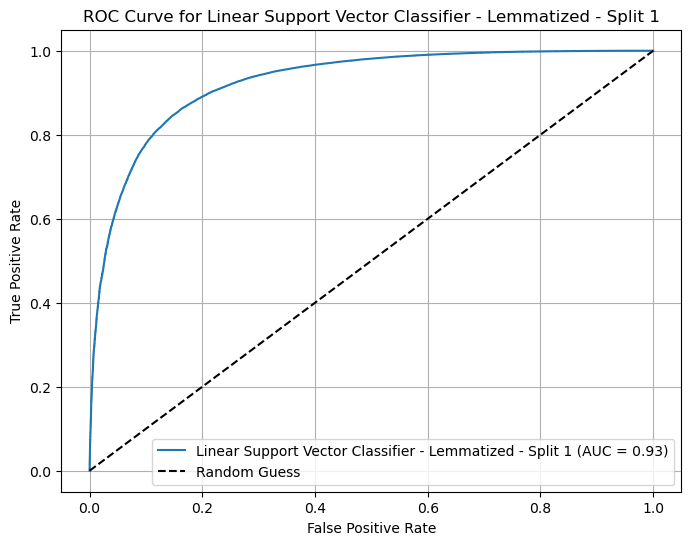


Model: Linear Support Vector Classifier, Dataset: Lemmatized - Split 2
Results for Linear Support Vector Classifier - Lemmatized - Split 2:
Accuracy: 0.9042
Precision: 0.8985
Recall: 0.9042
F1-score: 0.8972
Confusion Matrix:
[[ 18926  14513]
 [  4628 161647]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Stopping at 6 folds due to time constraints (Avg. Duration: 8.97s).
K-Fold Results (6 folds):
Precision: 0.8982, Recall: 0.9039, F1-Score: 0.8970
Avg Duration per Fold: 8.97s


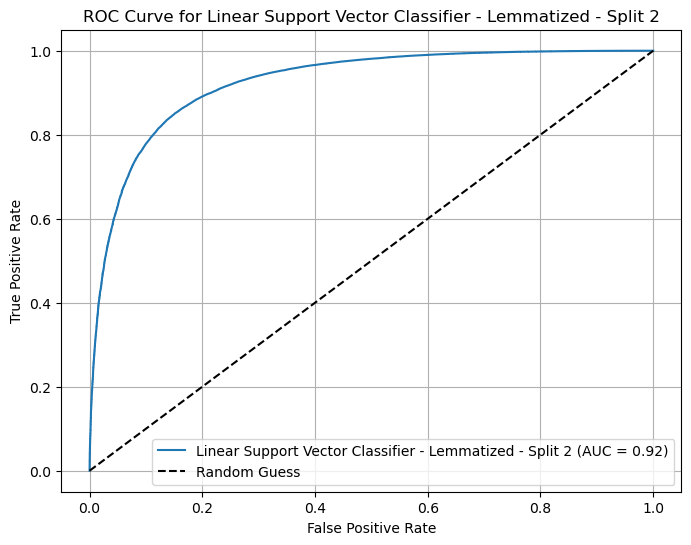


Model: Linear Support Vector Classifier, Dataset: Lemmatized - Split 3
Results for Linear Support Vector Classifier - Lemmatized - Split 3:
Accuracy: 0.9037
Precision: 0.8980
Recall: 0.9037
F1-score: 0.8969
Confusion Matrix:
[[ 18927  14512]
 [  4711 161564]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Stopping at 6 folds due to time constraints (Avg. Duration: 9.26s).
K-Fold Results (6 folds):
Precision: 0.8983, Recall: 0.9040, F1-Score: 0.8971
Avg Duration per Fold: 9.26s


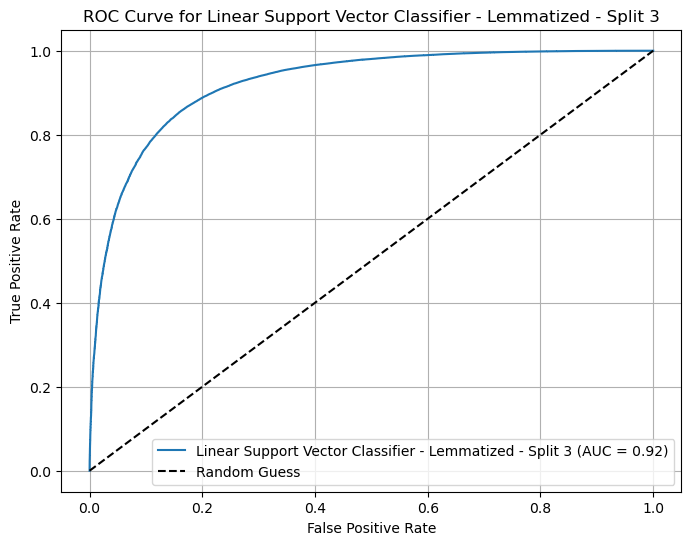


Model: Linear Support Vector Classifier, Dataset: Lemmatized - Split 4
Results for Linear Support Vector Classifier - Lemmatized - Split 4:
Accuracy: 0.9041
Precision: 0.8985
Recall: 0.9041
F1-score: 0.8974
Confusion Matrix:
[[ 19005  14434]
 [  4710 161565]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Stopping at 6 folds due to time constraints (Avg. Duration: 8.86s).
K-Fold Results (6 folds):
Precision: 0.8982, Recall: 0.9039, F1-Score: 0.8969
Avg Duration per Fold: 8.86s


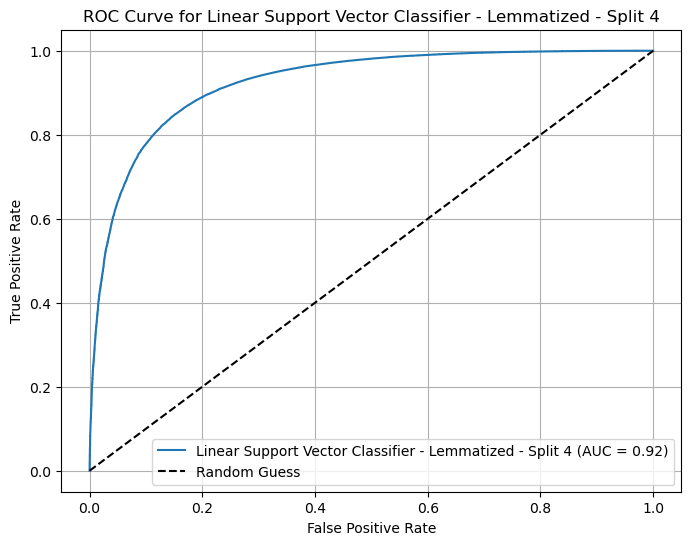


Model: Linear Support Vector Classifier, Dataset: Lemmatized - Split 5
Results for Linear Support Vector Classifier - Lemmatized - Split 5:
Accuracy: 0.9033
Precision: 0.8974
Recall: 0.9033
F1-score: 0.8962
Confusion Matrix:
[[ 18805  14634]
 [  4688 161587]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Stopping at 6 folds due to time constraints (Avg. Duration: 18.48s).
K-Fold Results (6 folds):
Precision: 0.8982, Recall: 0.9039, F1-Score: 0.8969
Avg Duration per Fold: 18.48s


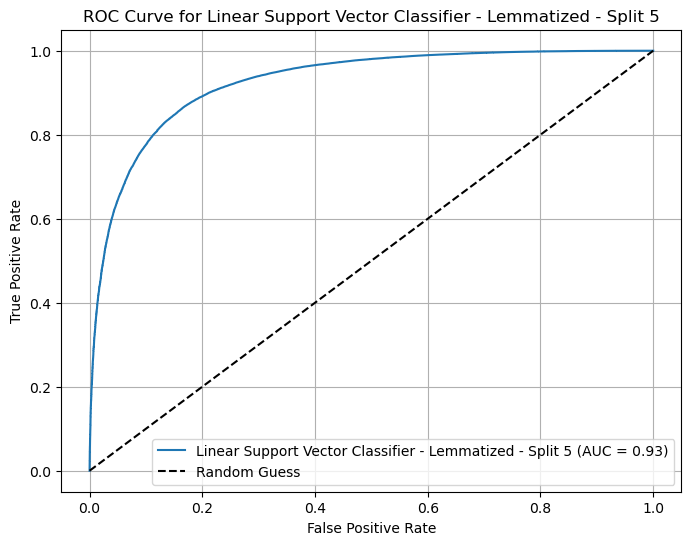


Model: Linear Support Vector Classifier, Dataset: Cleaned - Split 1
Results for Linear Support Vector Classifier - Cleaned - Split 1:
Accuracy: 0.9050
Precision: 0.8994
Recall: 0.9050
F1-score: 0.8984
Confusion Matrix:
[[ 19183  14256]
 [  4719 161556]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Stopping at 7 folds due to time constraints (Avg. Duration: 8.18s).
K-Fold Results (7 folds):
Precision: 0.8984, Recall: 0.9041, F1-Score: 0.8972
Avg Duration per Fold: 8.18s


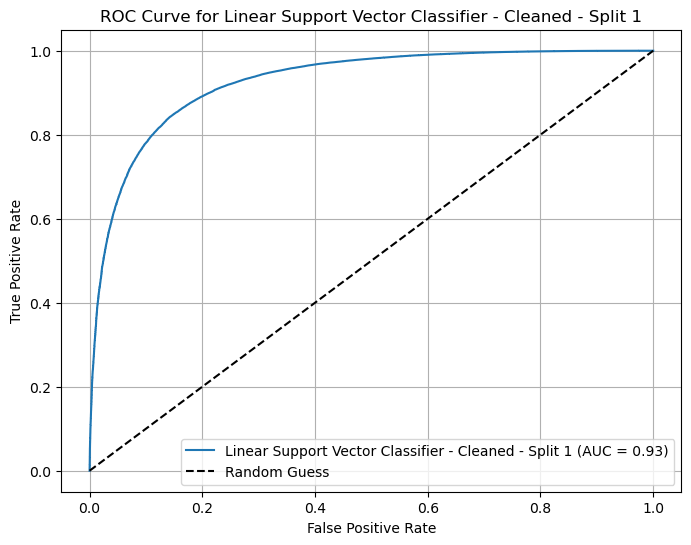


Model: Linear Support Vector Classifier, Dataset: Cleaned - Split 2
Results for Linear Support Vector Classifier - Cleaned - Split 2:
Accuracy: 0.9040
Precision: 0.8983
Recall: 0.9040
F1-score: 0.8971
Confusion Matrix:
[[ 18954  14485]
 [  4687 161588]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Stopping at 7 folds due to time constraints (Avg. Duration: 8.13s).
K-Fold Results (7 folds):
Precision: 0.8983, Recall: 0.9040, F1-Score: 0.8972
Avg Duration per Fold: 8.13s


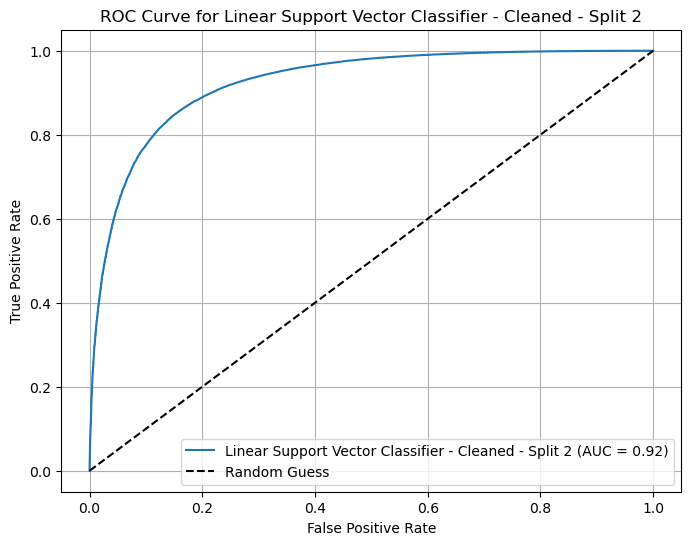


Model: Linear Support Vector Classifier, Dataset: Cleaned - Split 3
Results for Linear Support Vector Classifier - Cleaned - Split 3:
Accuracy: 0.9037
Precision: 0.8980
Recall: 0.9037
F1-score: 0.8968
Confusion Matrix:
[[ 18922  14517]
 [  4710 161565]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Stopping at 7 folds due to time constraints (Avg. Duration: 8.00s).
K-Fold Results (7 folds):
Precision: 0.8985, Recall: 0.9041, F1-Score: 0.8973
Avg Duration per Fold: 8.00s


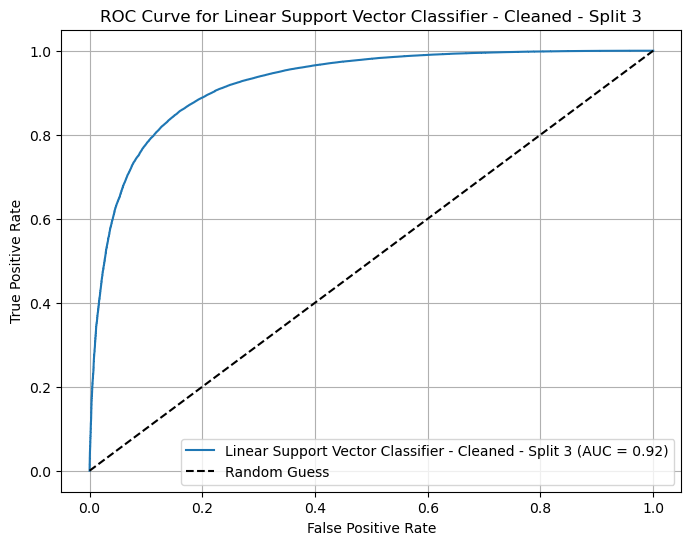


Model: Linear Support Vector Classifier, Dataset: Cleaned - Split 4
Results for Linear Support Vector Classifier - Cleaned - Split 4:
Accuracy: 0.9046
Precision: 0.8990
Recall: 0.9046
F1-score: 0.8978
Confusion Matrix:
[[ 19012  14426]
 [  4630 161646]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Stopping at 7 folds due to time constraints (Avg. Duration: 8.10s).
K-Fold Results (7 folds):
Precision: 0.8984, Recall: 0.9041, F1-Score: 0.8973
Avg Duration per Fold: 8.10s


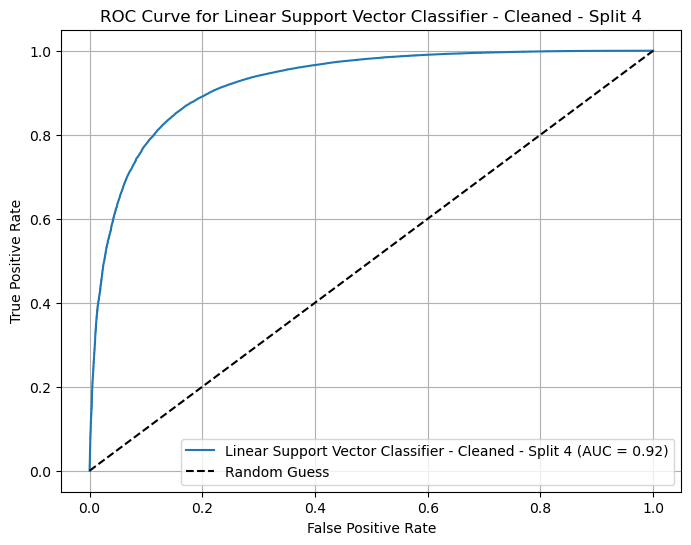


Model: Linear Support Vector Classifier, Dataset: Cleaned - Split 5
Results for Linear Support Vector Classifier - Cleaned - Split 5:
Accuracy: 0.9035
Precision: 0.8977
Recall: 0.9035
F1-score: 0.8964
Confusion Matrix:
[[ 18802  14636]
 [  4637 161639]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Stopping at 7 folds due to time constraints (Avg. Duration: 8.04s).
K-Fold Results (7 folds):
Precision: 0.8985, Recall: 0.9042, F1-Score: 0.8974
Avg Duration per Fold: 8.04s


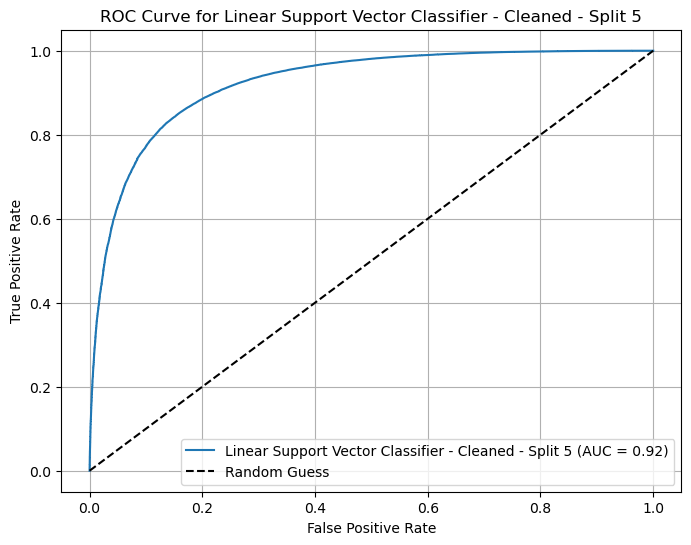


Model: Linear Support Vector Classifier, Dataset: Cleaned and Lemmatized - Split 1
Results for Linear Support Vector Classifier - Cleaned and Lemmatized - Split 1:
Accuracy: 0.9052
Precision: 0.8997
Recall: 0.9052
F1-score: 0.8986
Confusion Matrix:
[[ 19185  14254]
 [  4684 161591]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Stopping at 6 folds due to time constraints (Avg. Duration: 8.99s).
K-Fold Results (6 folds):
Precision: 0.8997, Recall: 0.9052, F1-Score: 0.8987
Avg Duration per Fold: 8.99s


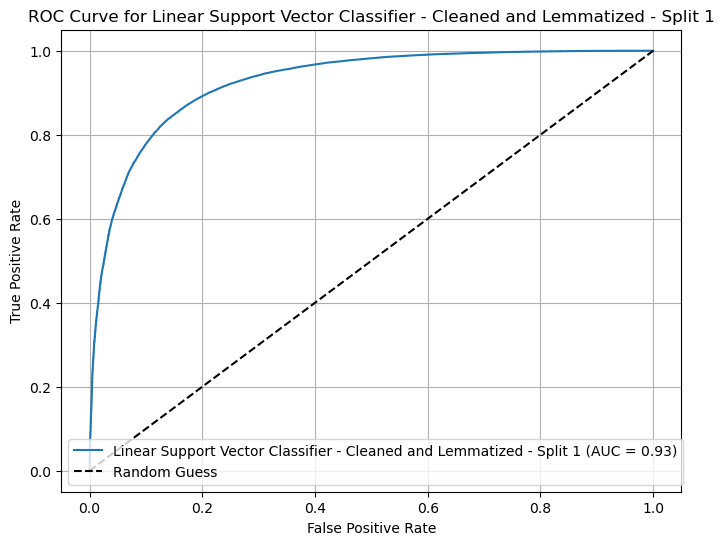


Model: Linear Support Vector Classifier, Dataset: Cleaned and Lemmatized - Split 2
Results for Linear Support Vector Classifier - Cleaned and Lemmatized - Split 2:
Accuracy: 0.9050
Precision: 0.8994
Recall: 0.9050
F1-score: 0.8984
Confusion Matrix:
[[ 19199  14239]
 [  4735 161541]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Stopping at 5 folds due to time constraints (Avg. Duration: 34.92s).
K-Fold Results (5 folds):
Precision: 0.8996, Recall: 0.9052, F1-Score: 0.8986
Avg Duration per Fold: 34.92s


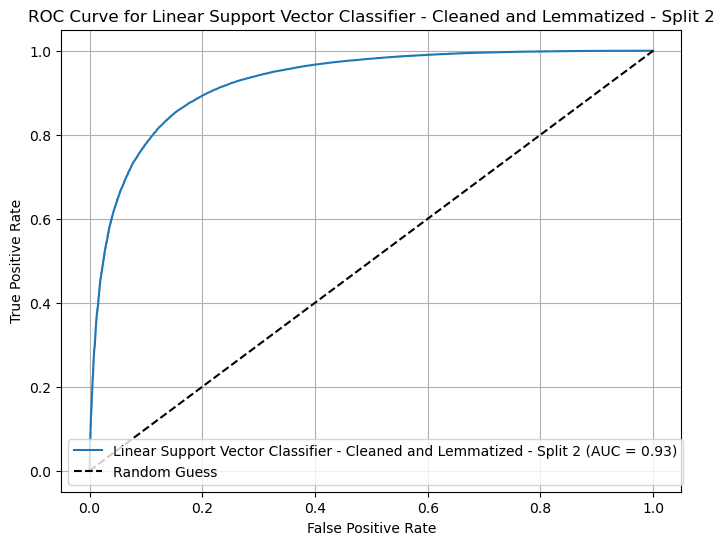


Model: Linear Support Vector Classifier, Dataset: Cleaned and Lemmatized - Split 3
Results for Linear Support Vector Classifier - Cleaned and Lemmatized - Split 3:
Accuracy: 0.9051
Precision: 0.8996
Recall: 0.9051
F1-score: 0.8984
Confusion Matrix:
[[ 19128  14311]
 [  4638 161637]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Stopping at 6 folds due to time constraints (Avg. Duration: 8.97s).
K-Fold Results (6 folds):
Precision: 0.8996, Recall: 0.9052, F1-Score: 0.8986
Avg Duration per Fold: 8.97s


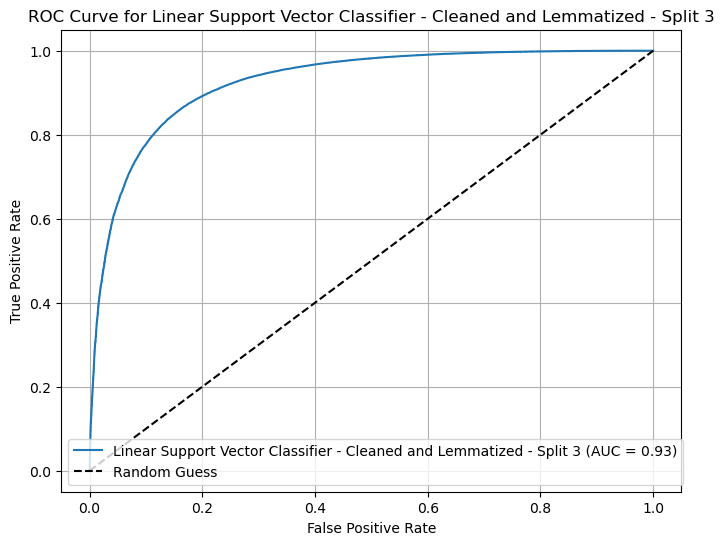


Model: Linear Support Vector Classifier, Dataset: Cleaned and Lemmatized - Split 4
Results for Linear Support Vector Classifier - Cleaned and Lemmatized - Split 4:
Accuracy: 0.9061
Precision: 0.9007
Recall: 0.9061
F1-score: 0.8994
Confusion Matrix:
[[ 19212  14227]
 [  4530 161745]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Stopping at 6 folds due to time constraints (Avg. Duration: 9.00s).
K-Fold Results (6 folds):
Precision: 0.8995, Recall: 0.9050, F1-Score: 0.8984
Avg Duration per Fold: 9.00s


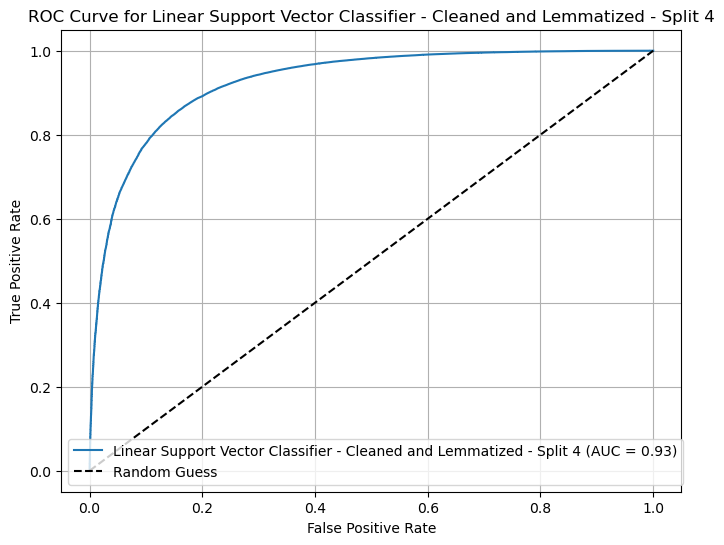


Model: Linear Support Vector Classifier, Dataset: Cleaned and Lemmatized - Split 5
Results for Linear Support Vector Classifier - Cleaned and Lemmatized - Split 5:
Accuracy: 0.9048
Precision: 0.8992
Recall: 0.9048
F1-score: 0.8981
Confusion Matrix:
[[ 19090  14348]
 [  4663 161613]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 16.04s).
K-Fold Results (4 folds):
Precision: 0.8997, Recall: 0.9052, F1-Score: 0.8986
Avg Duration per Fold: 16.04s


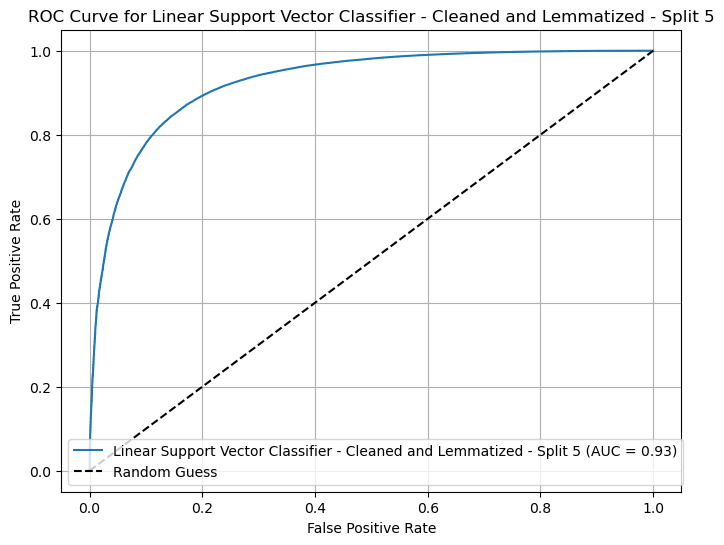


Model: Perceptron, Dataset: Original - Split 1
Results for Perceptron - Original - Split 1:
Accuracy: 0.8714
Precision: 0.8680
Recall: 0.8714
F1-score: 0.8695
Confusion Matrix:
[[ 19445  13994]
 [ 11693 154582]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8696, Recall: 0.8664, F1-Score: 0.8662
Avg Duration per Fold: 3.15s


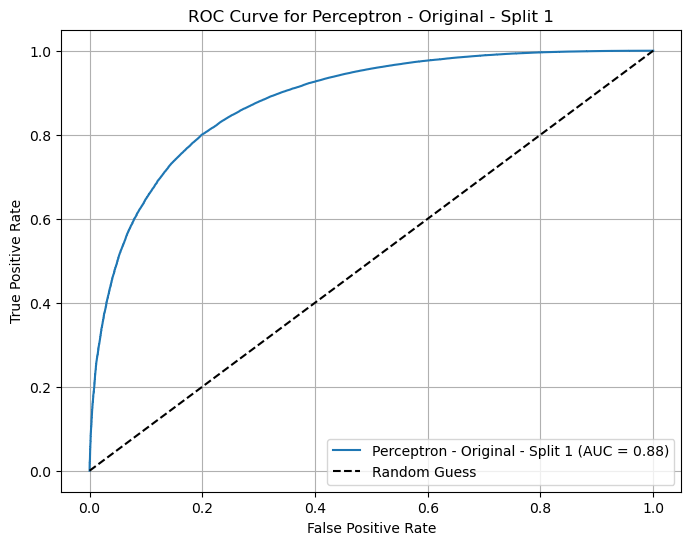


Model: Perceptron, Dataset: Original - Split 2
Results for Perceptron - Original - Split 2:
Accuracy: 0.8620
Precision: 0.8674
Recall: 0.8620
F1-score: 0.8644
Confusion Matrix:
[[ 21218  12221]
 [ 15347 150928]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
Stopping at 9 folds due to time constraints (Avg. Duration: 113.61s).
K-Fold Results (9 folds):
Precision: 0.8689, Recall: 0.8662, F1-Score: 0.8669
Avg Duration per Fold: 113.61s


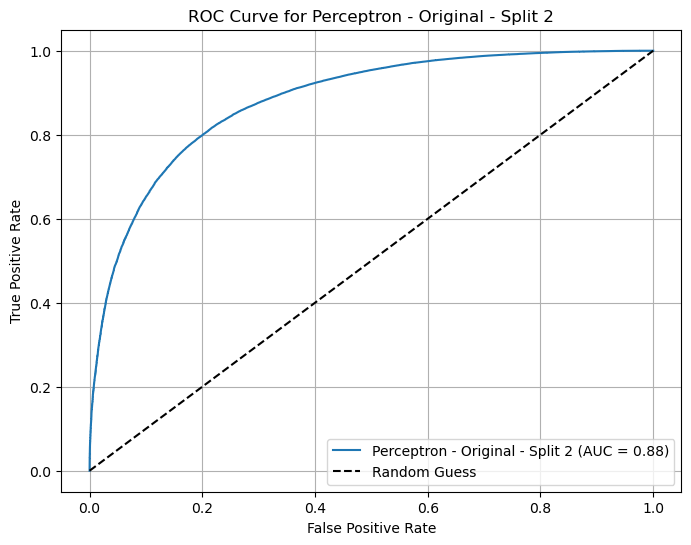


Model: Perceptron, Dataset: Original - Split 3
Results for Perceptron - Original - Split 3:
Accuracy: 0.8634
Precision: 0.8623
Recall: 0.8634
F1-score: 0.8628
Confusion Matrix:
[[ 19471  13968]
 [ 13315 152960]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8702, Recall: 0.8646, F1-Score: 0.8665
Avg Duration per Fold: 3.12s


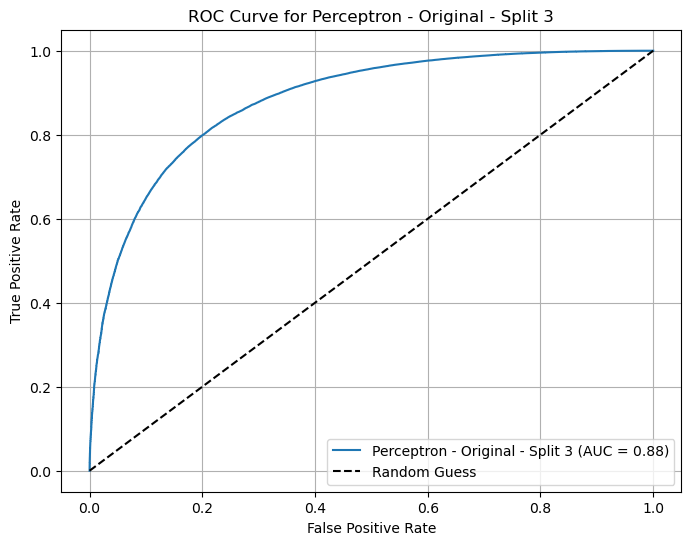


Model: Perceptron, Dataset: Original - Split 4
Results for Perceptron - Original - Split 4:
Accuracy: 0.8443
Precision: 0.8726
Recall: 0.8443
F1-score: 0.8541
Confusion Matrix:
[[ 24648   8791]
 [ 22300 143975]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
Stopping at 9 folds due to time constraints (Avg. Duration: 18.36s).
K-Fold Results (9 folds):
Precision: 0.8693, Recall: 0.8604, F1-Score: 0.8631
Avg Duration per Fold: 18.36s


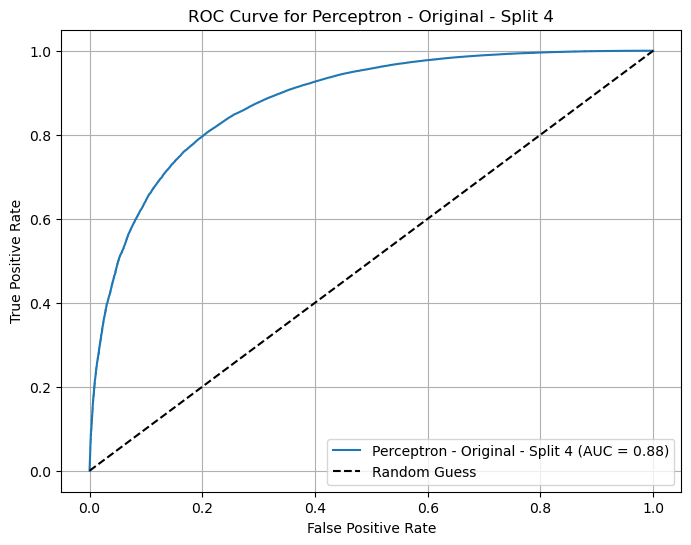


Model: Perceptron, Dataset: Original - Split 5
Results for Perceptron - Original - Split 5:
Accuracy: 0.8302
Precision: 0.8668
Recall: 0.8302
F1-score: 0.8425
Confusion Matrix:
[[ 24674   8764]
 [ 25145 141131]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8705, Recall: 0.8673, F1-Score: 0.8679
Avg Duration per Fold: 3.45s


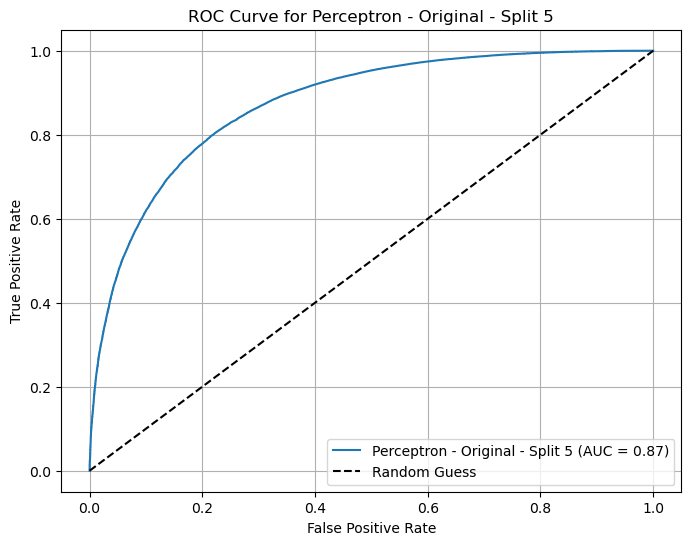


Model: Perceptron, Dataset: Lemmatized - Split 1
Results for Perceptron - Lemmatized - Split 1:
Accuracy: 0.8653
Precision: 0.8595
Recall: 0.8653
F1-score: 0.8619
Confusion Matrix:
[[ 18046  15392]
 [ 11518 154758]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8579, Recall: 0.8572, F1-Score: 0.8567
Avg Duration per Fold: 2.37s


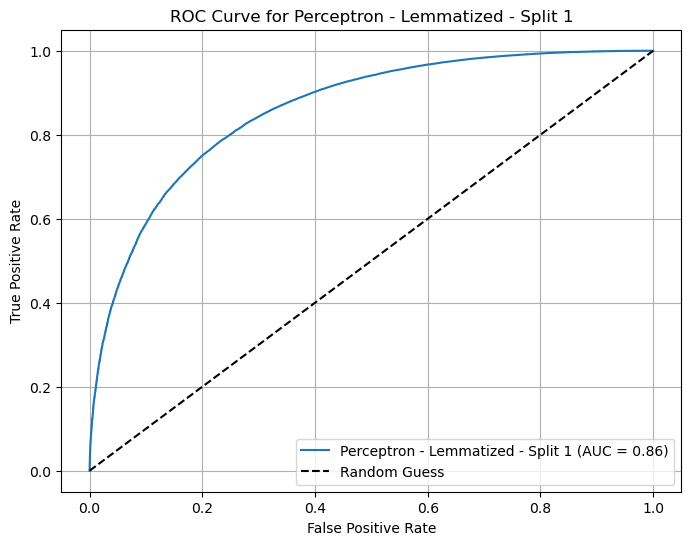


Model: Perceptron, Dataset: Lemmatized - Split 2
Results for Perceptron - Lemmatized - Split 2:
Accuracy: 0.8533
Precision: 0.8601
Recall: 0.8533
F1-score: 0.8563
Confusion Matrix:
[[ 20655  12784]
 [ 16523 149752]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8597, Recall: 0.8548, F1-Score: 0.8568
Avg Duration per Fold: 2.36s


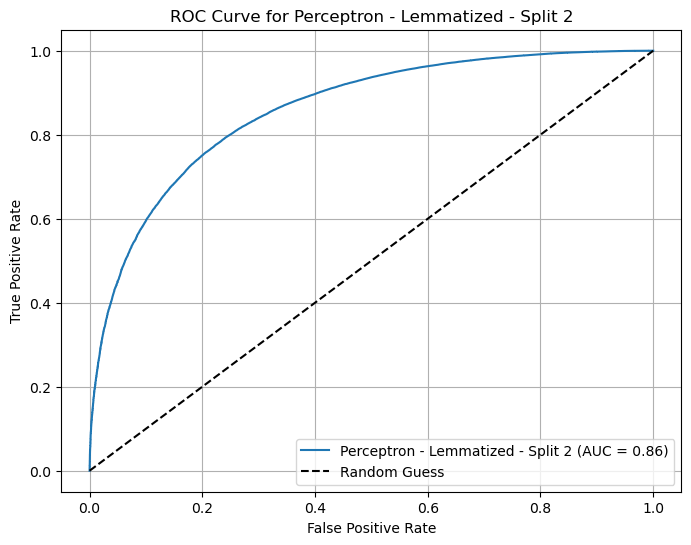


Model: Perceptron, Dataset: Lemmatized - Split 3
Results for Perceptron - Lemmatized - Split 3:
Accuracy: 0.8694
Precision: 0.8596
Recall: 0.8694
F1-score: 0.8626
Confusion Matrix:
[[ 16649  16790]
 [  9298 156977]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
Stopping at 9 folds due to time constraints (Avg. Duration: 15.11s).
K-Fold Results (9 folds):
Precision: 0.8594, Recall: 0.8559, F1-Score: 0.8568
Avg Duration per Fold: 15.11s


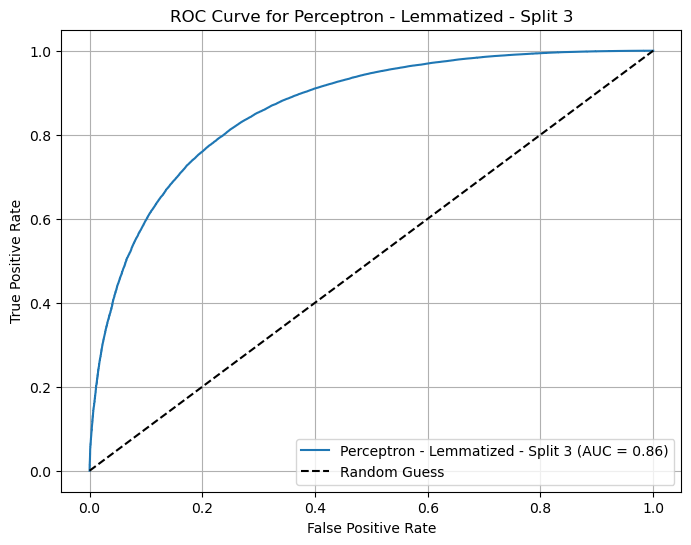


Model: Perceptron, Dataset: Lemmatized - Split 4
Results for Perceptron - Lemmatized - Split 4:
Accuracy: 0.8582
Precision: 0.8649
Recall: 0.8582
F1-score: 0.8612
Confusion Matrix:
[[ 21166  12273]
 [ 16045 150230]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8598, Recall: 0.8623, F1-Score: 0.8601
Avg Duration per Fold: 2.37s


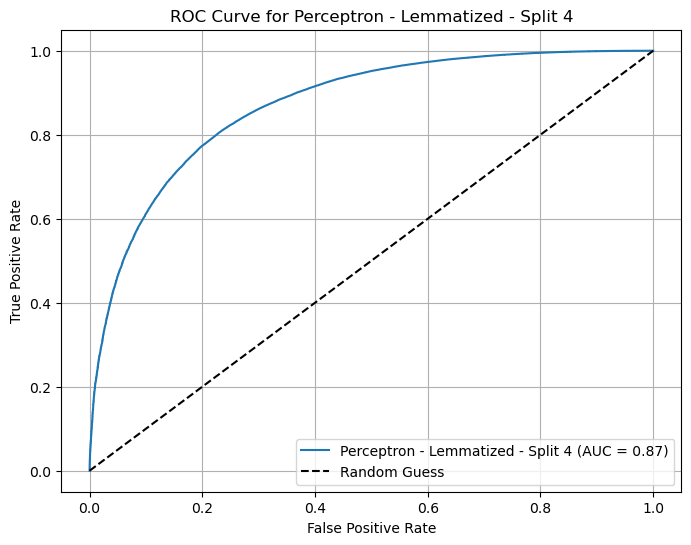


Model: Perceptron, Dataset: Lemmatized - Split 5
Results for Perceptron - Lemmatized - Split 5:
Accuracy: 0.8644
Precision: 0.8585
Recall: 0.8644
F1-score: 0.8610
Confusion Matrix:
[[ 17958  15481]
 [ 11609 154666]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8583, Recall: 0.8549, F1-Score: 0.8559
Avg Duration per Fold: 2.36s


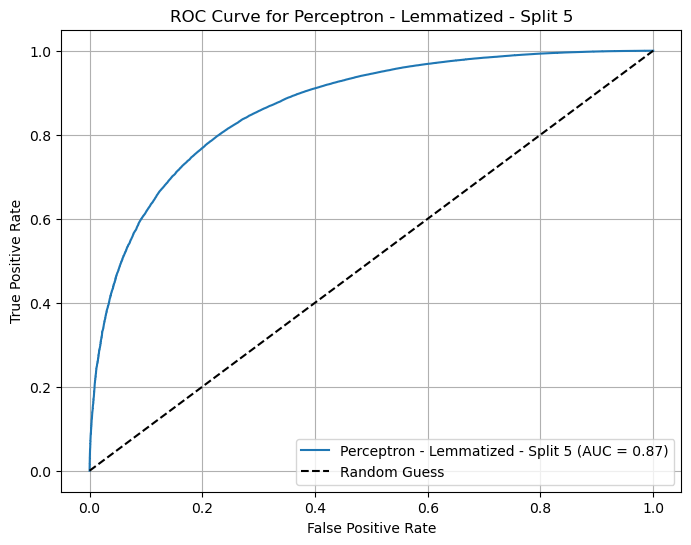


Model: Perceptron, Dataset: Cleaned - Split 1
Results for Perceptron - Cleaned - Split 1:
Accuracy: 0.8605
Precision: 0.8639
Recall: 0.8605
F1-score: 0.8621
Confusion Matrix:
[[ 20505  12934]
 [ 14936 151339]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Stopping at 7 folds due to time constraints (Avg. Duration: 9.13s).
K-Fold Results (7 folds):
Precision: 0.8592, Recall: 0.8599, F1-Score: 0.8589
Avg Duration per Fold: 9.13s


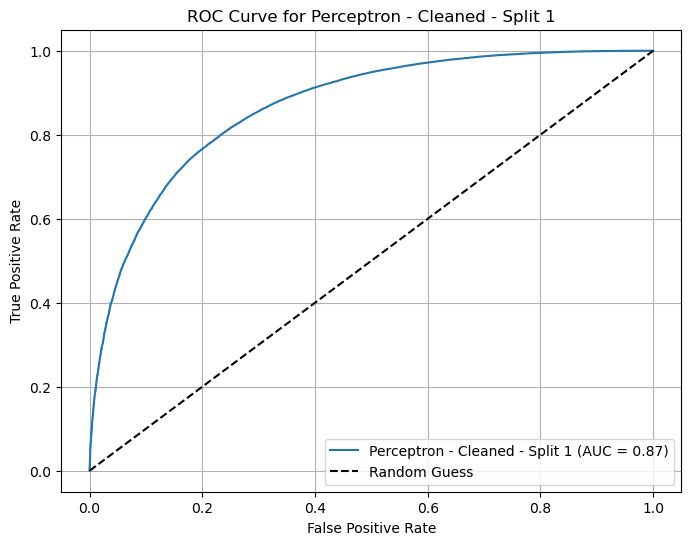


Model: Perceptron, Dataset: Cleaned - Split 2
Results for Perceptron - Cleaned - Split 2:
Accuracy: 0.8624
Precision: 0.8585
Recall: 0.8624
F1-score: 0.8603
Confusion Matrix:
[[ 18440  14999]
 [ 12473 153802]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8584, Recall: 0.8572, F1-Score: 0.8575
Avg Duration per Fold: 2.37s


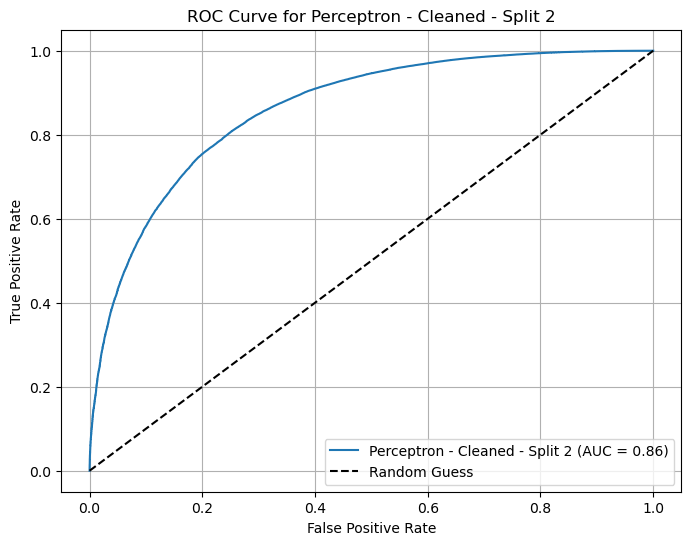


Model: Perceptron, Dataset: Cleaned - Split 3
Results for Perceptron - Cleaned - Split 3:
Accuracy: 0.8637
Precision: 0.8549
Recall: 0.8637
F1-score: 0.8582
Confusion Matrix:
[[ 16822  16617]
 [ 10608 155667]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8578, Recall: 0.8574, F1-Score: 0.8569
Avg Duration per Fold: 2.35s


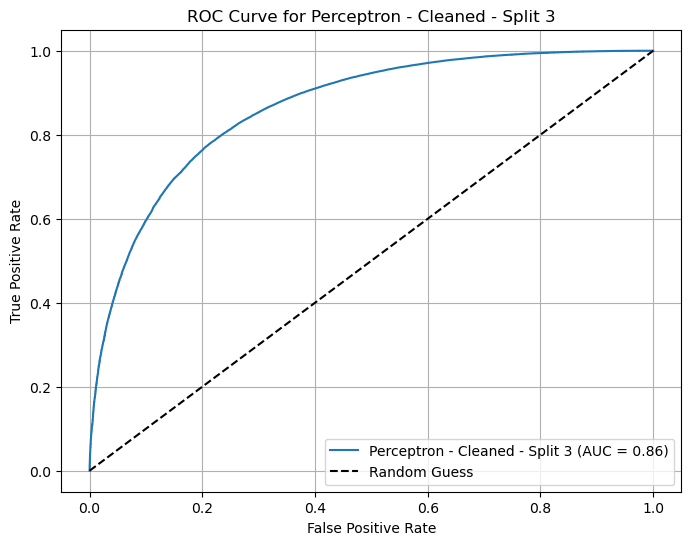


Model: Perceptron, Dataset: Cleaned - Split 4
Results for Perceptron - Cleaned - Split 4:
Accuracy: 0.8658
Precision: 0.8614
Recall: 0.8658
F1-score: 0.8633
Confusion Matrix:
[[ 18565  14873]
 [ 11921 154355]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8575, Recall: 0.8585, F1-Score: 0.8575
Avg Duration per Fold: 2.60s


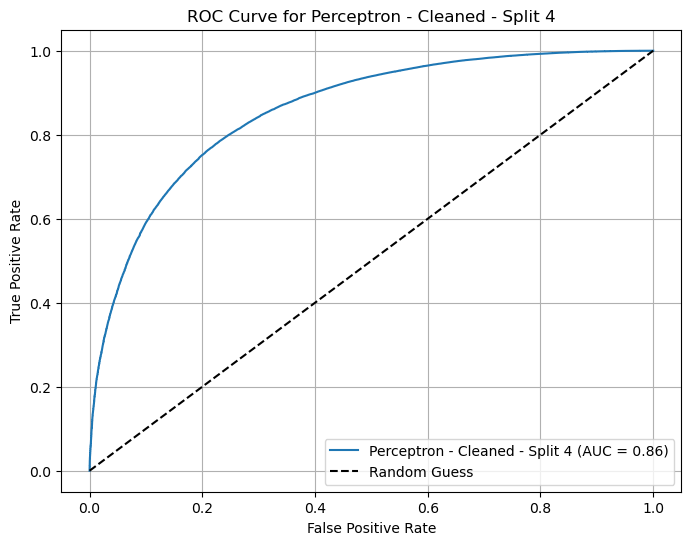


Model: Perceptron, Dataset: Cleaned - Split 5
Results for Perceptron - Cleaned - Split 5:
Accuracy: 0.8664
Precision: 0.8642
Recall: 0.8664
F1-score: 0.8653
Confusion Matrix:
[[ 19407  14031]
 [ 12652 153624]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8577, Recall: 0.8563, F1-Score: 0.8565
Avg Duration per Fold: 2.36s


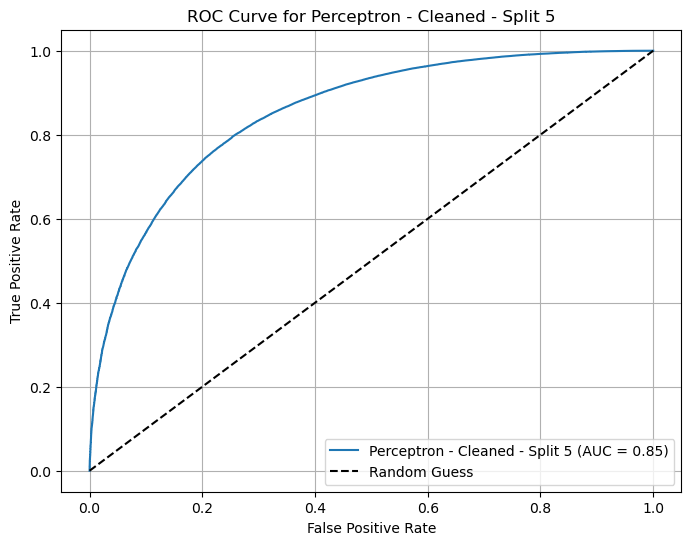


Model: Perceptron, Dataset: Cleaned and Lemmatized - Split 1
Results for Perceptron - Cleaned and Lemmatized - Split 1:
Accuracy: 0.8723
Precision: 0.8653
Recall: 0.8723
F1-score: 0.8679
Confusion Matrix:
[[ 18070  15369]
 [ 10128 156147]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8598, Recall: 0.8605, F1-Score: 0.8594
Avg Duration per Fold: 2.50s


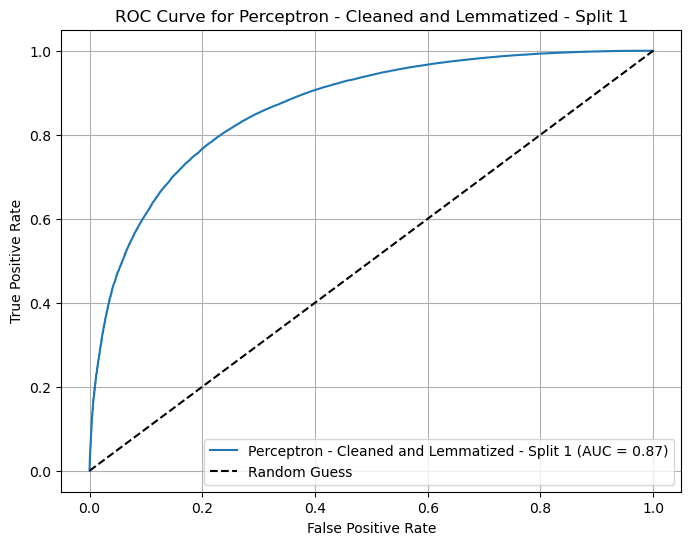


Model: Perceptron, Dataset: Cleaned and Lemmatized - Split 2
Results for Perceptron - Cleaned and Lemmatized - Split 2:
Accuracy: 0.8407
Precision: 0.8602
Recall: 0.8407
F1-score: 0.8483
Confusion Matrix:
[[ 22269  11169]
 [ 20636 145640]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8618, Recall: 0.8594, F1-Score: 0.8604
Avg Duration per Fold: 2.59s


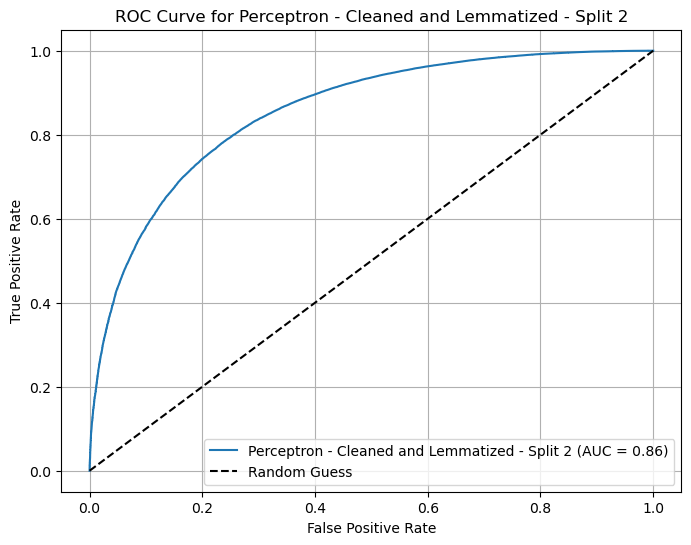


Model: Perceptron, Dataset: Cleaned and Lemmatized - Split 3
Results for Perceptron - Cleaned and Lemmatized - Split 3:
Accuracy: 0.8719
Precision: 0.8650
Recall: 0.8719
F1-score: 0.8677
Confusion Matrix:
[[ 18121  15318]
 [ 10258 156017]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8605, Recall: 0.8579, F1-Score: 0.8586
Avg Duration per Fold: 2.66s


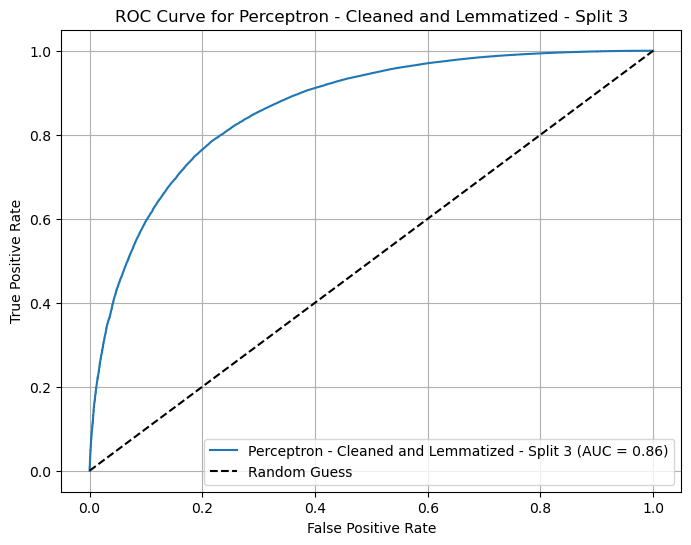


Model: Perceptron, Dataset: Cleaned and Lemmatized - Split 4
Results for Perceptron - Cleaned and Lemmatized - Split 4:
Accuracy: 0.8632
Precision: 0.8606
Recall: 0.8632
F1-score: 0.8618
Confusion Matrix:
[[ 18974  14465]
 [ 12859 153416]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Stopping at 5 folds due to time constraints (Avg. Duration: 32.38s).
K-Fold Results (5 folds):
Precision: 0.8591, Recall: 0.8525, F1-Score: 0.8551
Avg Duration per Fold: 32.38s


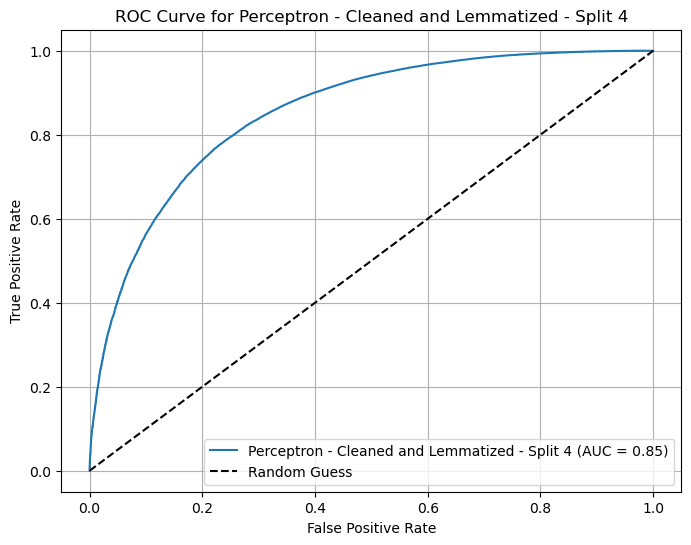


Model: Perceptron, Dataset: Cleaned and Lemmatized - Split 5
Results for Perceptron - Cleaned and Lemmatized - Split 5:
Accuracy: 0.8668
Precision: 0.8569
Recall: 0.8668
F1-score: 0.8601
Confusion Matrix:
[[ 16486  16952]
 [  9651 156625]]
Running 5-fold evaluation...
Running 6-fold evaluation...
Running 7-fold evaluation...
Running 8-fold evaluation...
Running 9-fold evaluation...
Running 10-fold evaluation...
K-Fold Results (9 folds):
Precision: 0.8608, Recall: 0.8530, F1-Score: 0.8549
Avg Duration per Fold: 2.60s


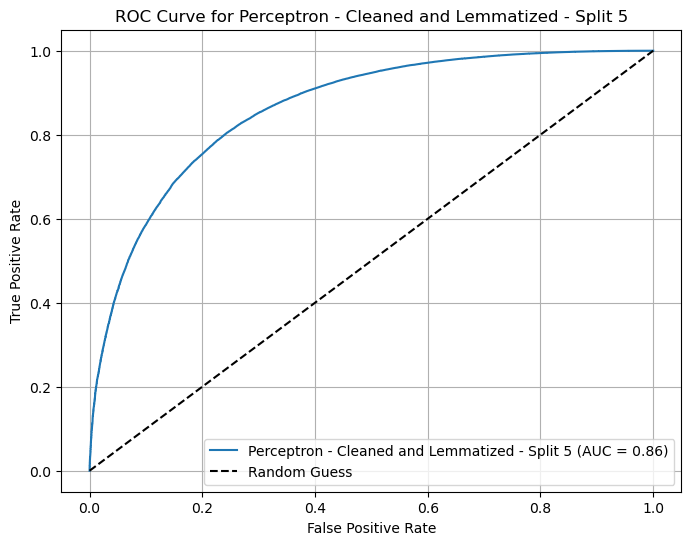


Model: XGBoost, Dataset: Original - Split 1
Results for XGBoost - Original - Split 1:
Accuracy: 0.9036
Precision: 0.8980
Recall: 0.9036
F1-score: 0.8960
Confusion Matrix:
[[ 18505  14934]
 [  4324 161951]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 47.74s).
K-Fold Results (4 folds):
Precision: 0.8974, Recall: 0.9030, F1-Score: 0.8950
Avg Duration per Fold: 47.74s


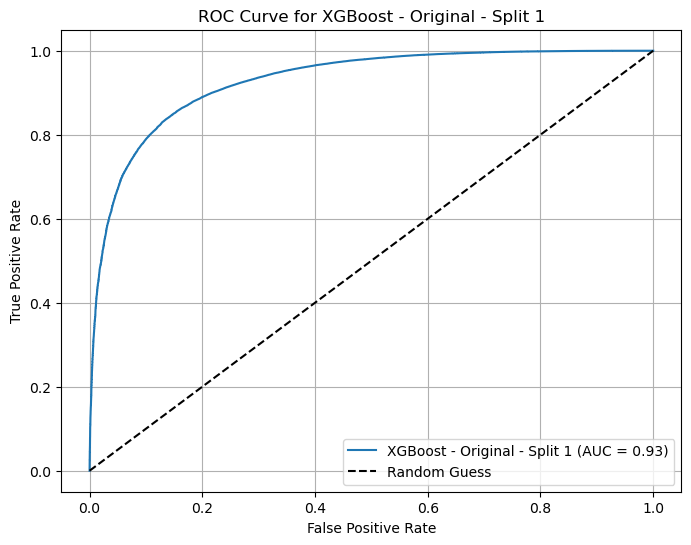


Model: XGBoost, Dataset: Original - Split 2
Results for XGBoost - Original - Split 2:
Accuracy: 0.9024
Precision: 0.8967
Recall: 0.9024
F1-score: 0.8943
Confusion Matrix:
[[ 18156  15283]
 [  4217 162058]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 46.96s).
K-Fold Results (4 folds):
Precision: 0.8969, Recall: 0.9026, F1-Score: 0.8946
Avg Duration per Fold: 46.96s


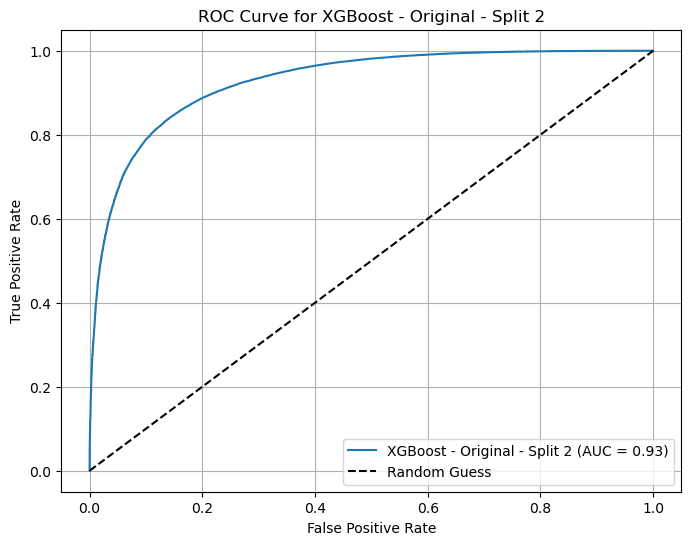


Model: XGBoost, Dataset: Original - Split 3
Results for XGBoost - Original - Split 3:
Accuracy: 0.9032
Precision: 0.8976
Recall: 0.9032
F1-score: 0.8955
Confusion Matrix:
[[ 18411  15028]
 [  4299 161976]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 47.02s).
K-Fold Results (4 folds):
Precision: 0.8972, Recall: 0.9028, F1-Score: 0.8948
Avg Duration per Fold: 47.02s


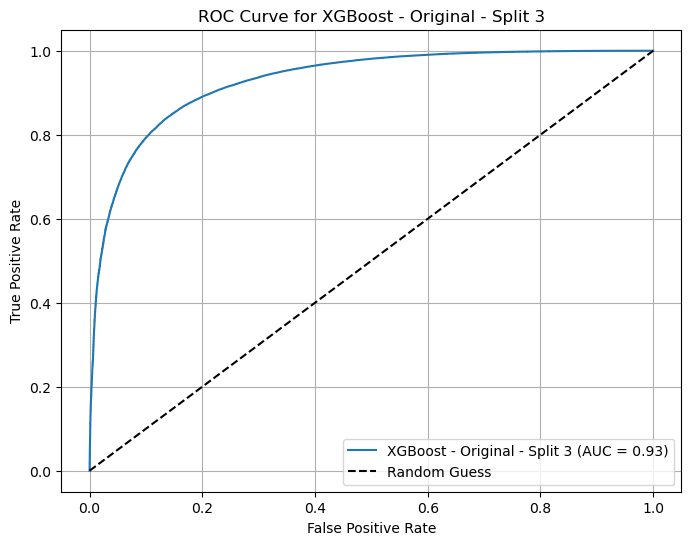


Model: XGBoost, Dataset: Original - Split 4
Results for XGBoost - Original - Split 4:
Accuracy: 0.9030
Precision: 0.8975
Recall: 0.9030
F1-score: 0.8951
Confusion Matrix:
[[ 18269  15170]
 [  4196 162079]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 47.50s).
K-Fold Results (4 folds):
Precision: 0.8969, Recall: 0.9026, F1-Score: 0.8945
Avg Duration per Fold: 47.50s


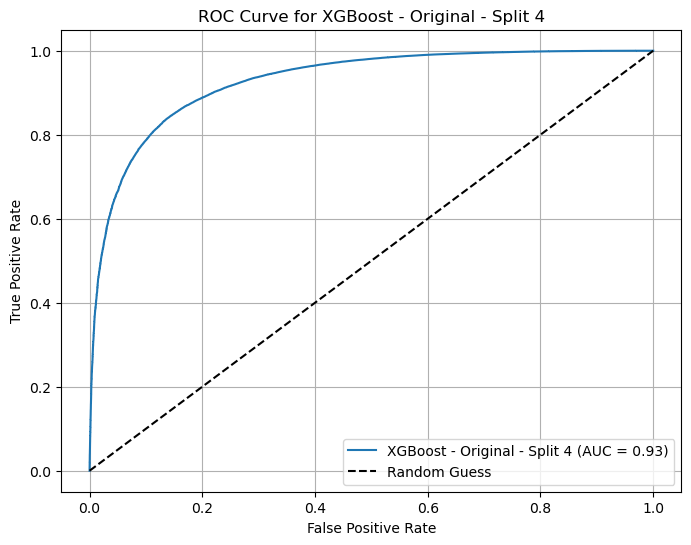


Model: XGBoost, Dataset: Original - Split 5
Results for XGBoost - Original - Split 5:
Accuracy: 0.9020
Precision: 0.8962
Recall: 0.9020
F1-score: 0.8941
Confusion Matrix:
[[ 18221  15217]
 [  4348 161928]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 47.45s).
K-Fold Results (4 folds):
Precision: 0.8973, Recall: 0.9029, F1-Score: 0.8949
Avg Duration per Fold: 47.45s


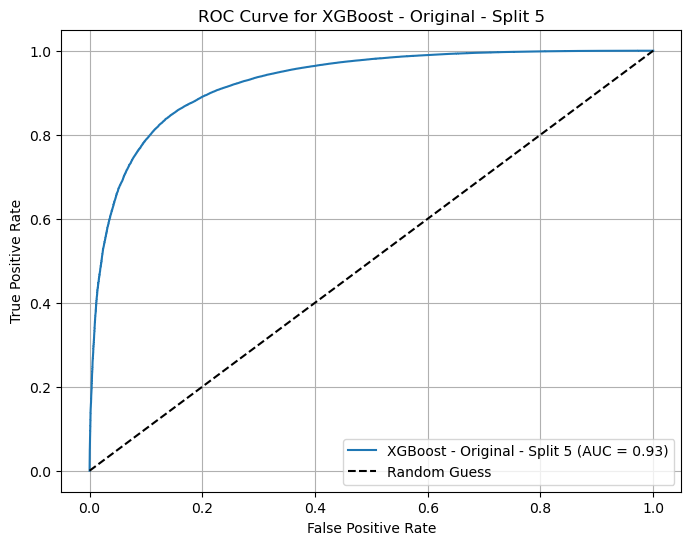


Model: XGBoost, Dataset: Lemmatized - Split 1
Results for XGBoost - Lemmatized - Split 1:
Accuracy: 0.8957
Precision: 0.8901
Recall: 0.8957
F1-score: 0.8840
Confusion Matrix:
[[ 16023  17415]
 [  3422 162854]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 37.68s).
K-Fold Results (4 folds):
Precision: 0.8892, Recall: 0.8949, F1-Score: 0.8831
Avg Duration per Fold: 37.68s


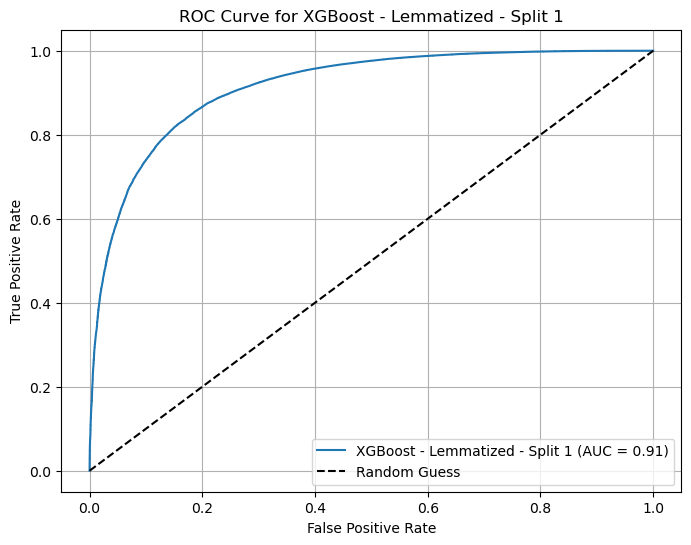


Model: XGBoost, Dataset: Lemmatized - Split 2
Results for XGBoost - Lemmatized - Split 2:
Accuracy: 0.8951
Precision: 0.8894
Recall: 0.8951
F1-score: 0.8833
Confusion Matrix:
[[ 15941  17498]
 [  3455 162820]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 37.72s).
K-Fold Results (4 folds):
Precision: 0.8892, Recall: 0.8949, F1-Score: 0.8831
Avg Duration per Fold: 37.72s


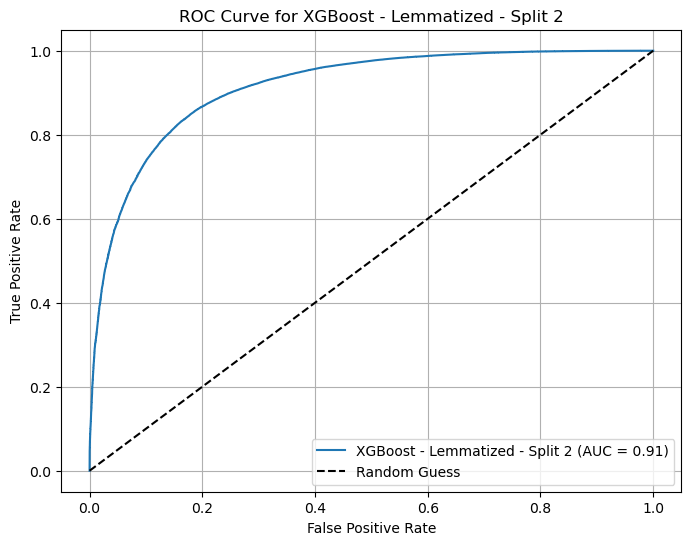


Model: XGBoost, Dataset: Lemmatized - Split 3
Results for XGBoost - Lemmatized - Split 3:
Accuracy: 0.8953
Precision: 0.8896
Recall: 0.8953
F1-score: 0.8836
Confusion Matrix:
[[ 16000  17439]
 [  3469 162806]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 37.67s).
K-Fold Results (4 folds):
Precision: 0.8893, Recall: 0.8950, F1-Score: 0.8831
Avg Duration per Fold: 37.67s


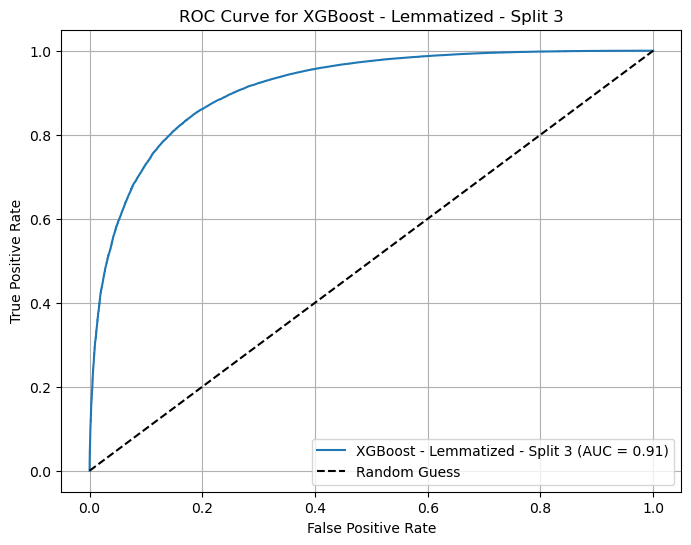


Model: XGBoost, Dataset: Lemmatized - Split 4
Results for XGBoost - Lemmatized - Split 4:
Accuracy: 0.8959
Precision: 0.8905
Recall: 0.8959
F1-score: 0.8842
Confusion Matrix:
[[ 16046  17393]
 [  3392 162883]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 40.71s).
K-Fold Results (4 folds):
Precision: 0.8894, Recall: 0.8950, F1-Score: 0.8832
Avg Duration per Fold: 40.71s


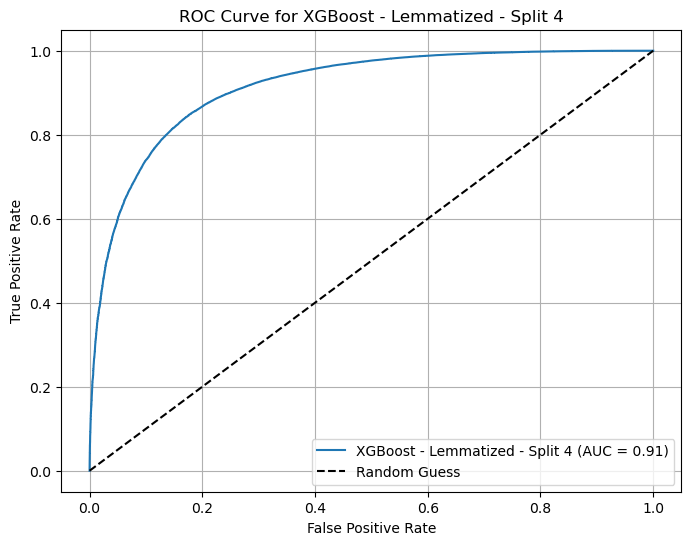


Model: XGBoost, Dataset: Lemmatized - Split 5
Results for XGBoost - Lemmatized - Split 5:
Accuracy: 0.8952
Precision: 0.8895
Recall: 0.8952
F1-score: 0.8835
Confusion Matrix:
[[ 15992  17447]
 [  3478 162797]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 38.37s).
K-Fold Results (4 folds):
Precision: 0.8895, Recall: 0.8951, F1-Score: 0.8832
Avg Duration per Fold: 38.37s


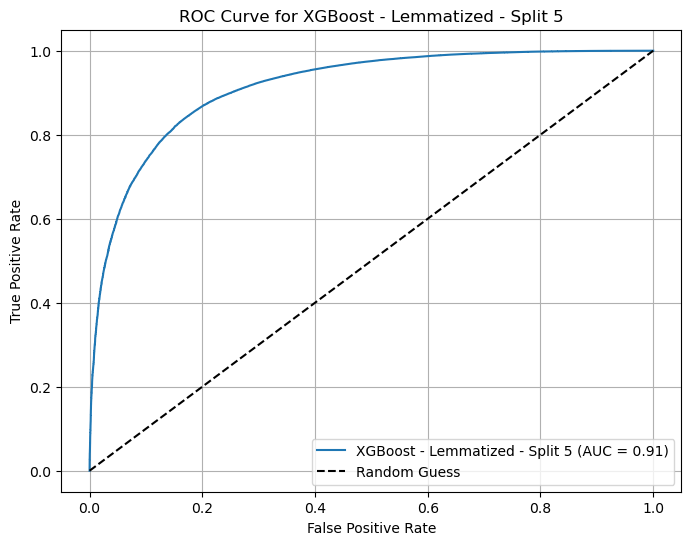


Model: XGBoost, Dataset: Cleaned - Split 1
Results for XGBoost - Cleaned - Split 1:
Accuracy: 0.8959
Precision: 0.8906
Recall: 0.8959
F1-score: 0.8840
Confusion Matrix:
[[ 15931  17508]
 [  3283 162992]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 43.57s).
K-Fold Results (4 folds):
Precision: 0.8892, Recall: 0.8947, F1-Score: 0.8825
Avg Duration per Fold: 43.57s


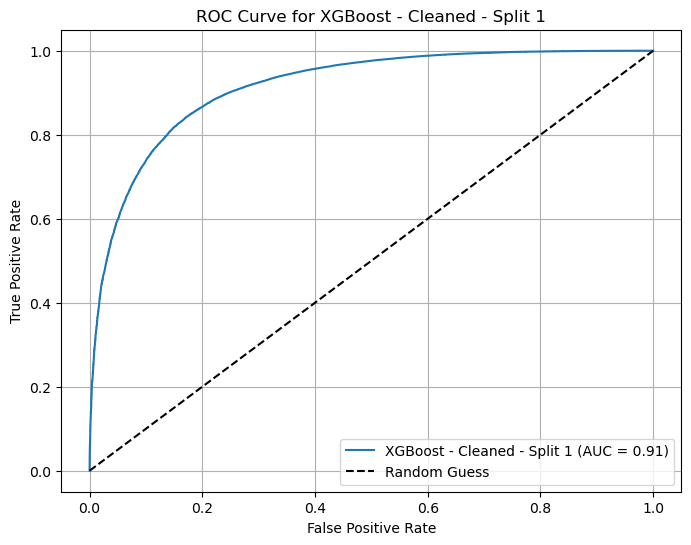


Model: XGBoost, Dataset: Cleaned - Split 2
Results for XGBoost - Cleaned - Split 2:
Accuracy: 0.8941
Precision: 0.8886
Recall: 0.8941
F1-score: 0.8816
Confusion Matrix:
[[ 15603  17836]
 [  3310 162965]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 38.32s).
K-Fold Results (4 folds):
Precision: 0.8891, Recall: 0.8946, F1-Score: 0.8823
Avg Duration per Fold: 38.32s


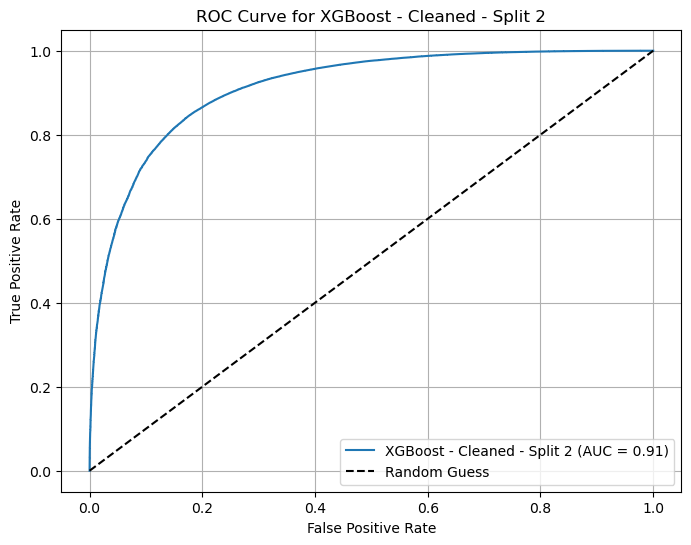


Model: XGBoost, Dataset: Cleaned - Split 3
Results for XGBoost - Cleaned - Split 3:
Accuracy: 0.8946
Precision: 0.8891
Recall: 0.8946
F1-score: 0.8823
Confusion Matrix:
[[ 15701  17738]
 [  3316 162959]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 38.70s).
K-Fold Results (4 folds):
Precision: 0.8892, Recall: 0.8947, F1-Score: 0.8824
Avg Duration per Fold: 38.70s


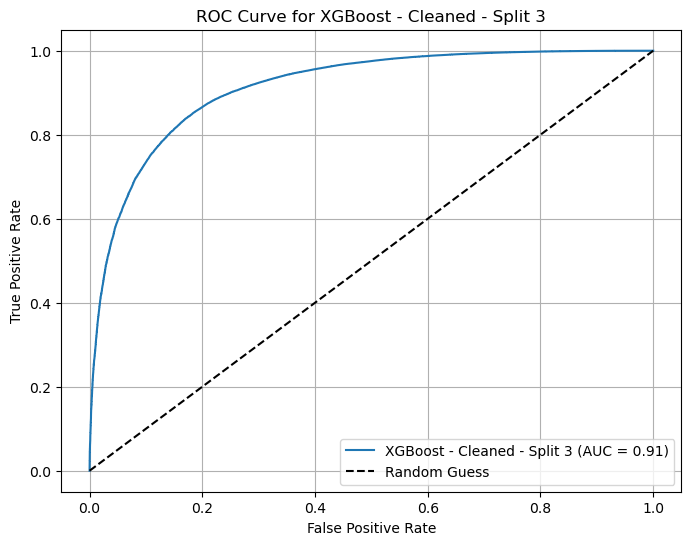


Model: XGBoost, Dataset: Cleaned - Split 4
Results for XGBoost - Cleaned - Split 4:
Accuracy: 0.8956
Precision: 0.8905
Recall: 0.8956
F1-score: 0.8833
Confusion Matrix:
[[ 15760  17678]
 [  3182 163094]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 39.13s).
K-Fold Results (4 folds):
Precision: 0.8890, Recall: 0.8945, F1-Score: 0.8822
Avg Duration per Fold: 39.13s


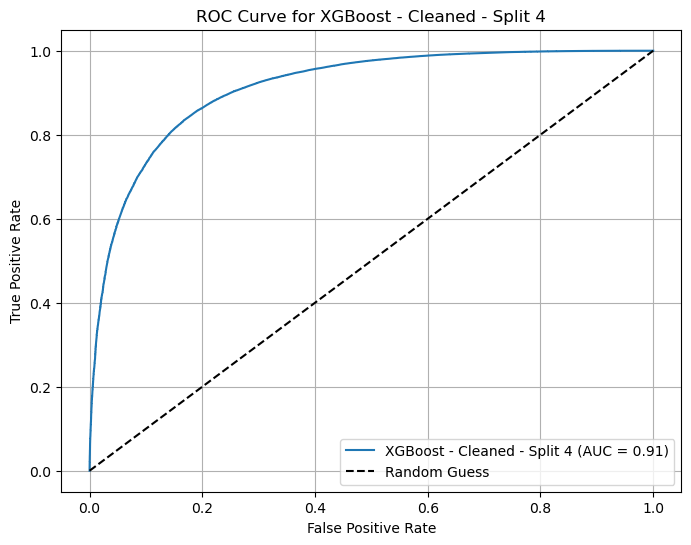


Model: XGBoost, Dataset: Cleaned - Split 5
Results for XGBoost - Cleaned - Split 5:
Accuracy: 0.8938
Precision: 0.8882
Recall: 0.8938
F1-score: 0.8812
Confusion Matrix:
[[ 15541  17897]
 [  3309 162967]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 38.48s).
K-Fold Results (4 folds):
Precision: 0.8893, Recall: 0.8948, F1-Score: 0.8826
Avg Duration per Fold: 38.48s


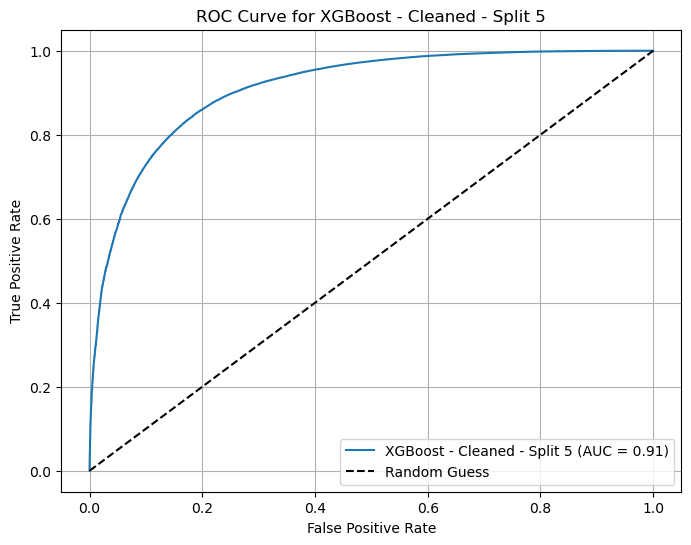


Model: XGBoost, Dataset: Cleaned and Lemmatized - Split 1
Results for XGBoost - Cleaned and Lemmatized - Split 1:
Accuracy: 0.8966
Precision: 0.8910
Recall: 0.8966
F1-score: 0.8853
Confusion Matrix:
[[ 16284  17155]
 [  3504 162771]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 40.23s).
K-Fold Results (4 folds):
Precision: 0.8912, Recall: 0.8967, F1-Score: 0.8853
Avg Duration per Fold: 40.23s


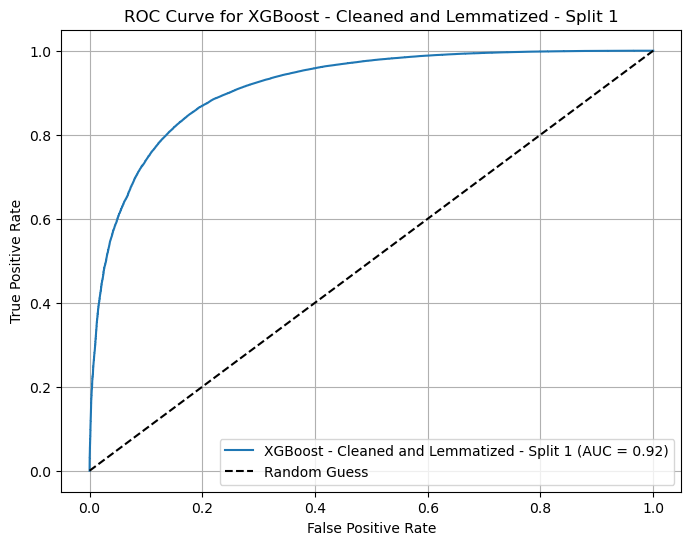


Model: XGBoost, Dataset: Cleaned and Lemmatized - Split 2
Results for XGBoost - Cleaned and Lemmatized - Split 2:
Accuracy: 0.8964
Precision: 0.8908
Recall: 0.8964
F1-score: 0.8850
Confusion Matrix:
[[ 16205  17233]
 [  3467 162809]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 39.94s).
K-Fold Results (4 folds):
Precision: 0.8911, Recall: 0.8965, F1-Score: 0.8852
Avg Duration per Fold: 39.94s


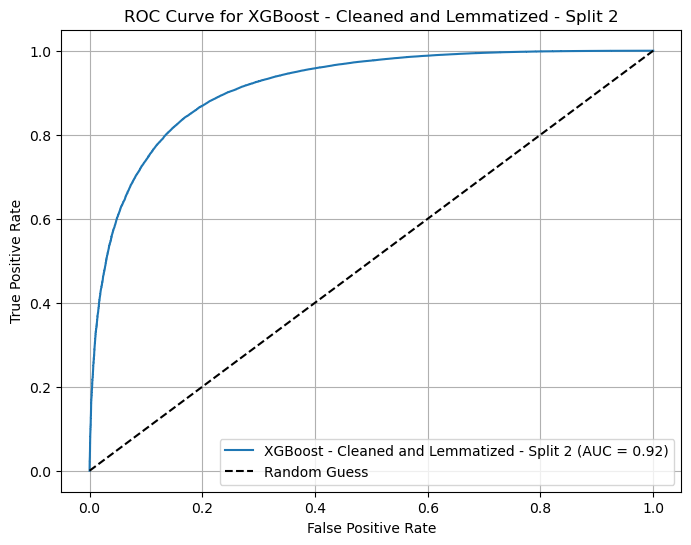


Model: XGBoost, Dataset: Cleaned and Lemmatized - Split 3
Results for XGBoost - Cleaned and Lemmatized - Split 3:
Accuracy: 0.8964
Precision: 0.8911
Recall: 0.8964
F1-score: 0.8848
Confusion Matrix:
[[ 16114  17325]
 [  3364 162911]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 39.92s).
K-Fold Results (4 folds):
Precision: 0.8913, Recall: 0.8967, F1-Score: 0.8853
Avg Duration per Fold: 39.92s


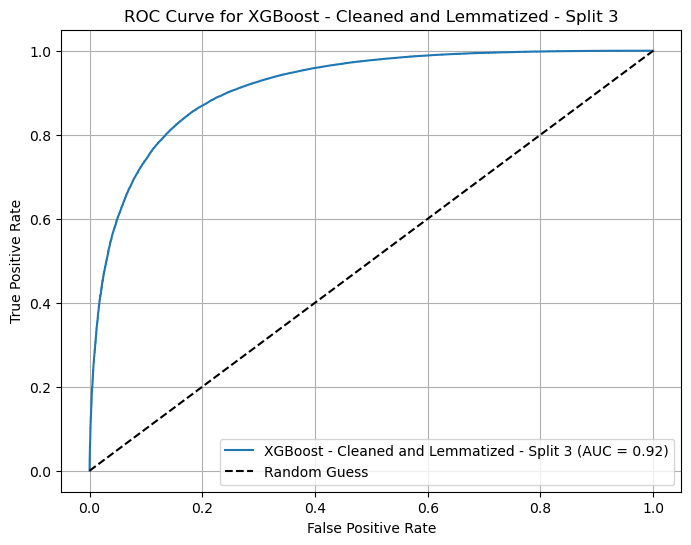


Model: XGBoost, Dataset: Cleaned and Lemmatized - Split 4
Results for XGBoost - Cleaned and Lemmatized - Split 4:
Accuracy: 0.8962
Precision: 0.8908
Recall: 0.8962
F1-score: 0.8847
Confusion Matrix:
[[ 16130  17309]
 [  3416 162859]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 39.61s).
K-Fold Results (4 folds):
Precision: 0.8909, Recall: 0.8964, F1-Score: 0.8851
Avg Duration per Fold: 39.61s


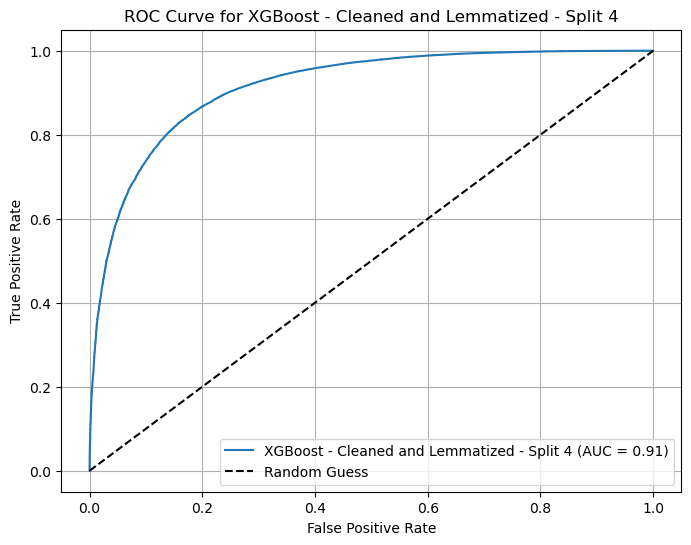


Model: XGBoost, Dataset: Cleaned and Lemmatized - Split 5
Results for XGBoost - Cleaned and Lemmatized - Split 5:
Accuracy: 0.8967
Precision: 0.8914
Recall: 0.8967
F1-score: 0.8853
Confusion Matrix:
[[ 16195  17243]
 [  3384 162892]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 39.72s).
K-Fold Results (4 folds):
Precision: 0.8909, Recall: 0.8964, F1-Score: 0.8849
Avg Duration per Fold: 39.72s


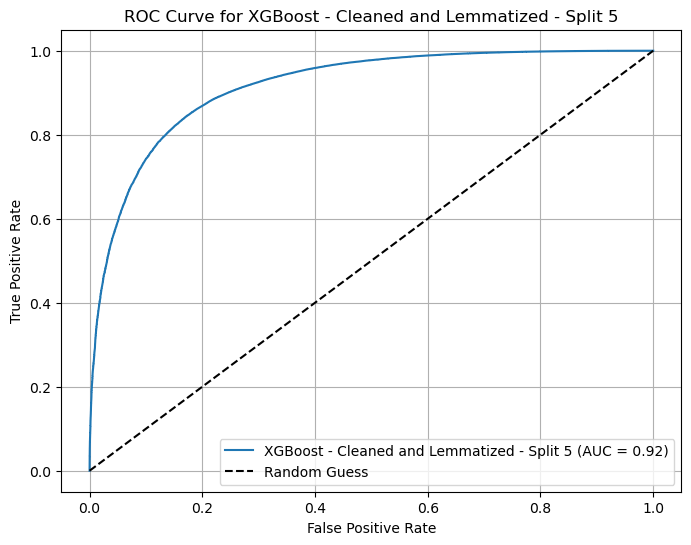

In [61]:
for model_name, model in models:
    # For each dataset with 5 splits
    for dataset_name, X_train, y_train, X_test, y_test, X_eval, y_eval in datasets:
        print(f"\nModel: {model_name}, Dataset: {dataset_name}")
        
        # Train, evaluate, and visualize the results for each model and dataset split
        train_evaluate_visualize(model, X_train, y_train, X_test, y_test, k_min=5, k_max=10, max_duration=60, model_name=f"{model_name} - {dataset_name}")


Model: XGBoost, Dataset: Original - Split 1
Results for XGBoost - Original - Split 1:
Accuracy: 0.9007
Precision: 0.8901
Recall: 0.9007
F1-score: 0.8893
Confusion Matrix:
[[ 576  777]
 [ 216 8431]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 45.53s).
K-Fold Results (4 folds):
Precision: 0.8961, Recall: 0.9051, F1-Score: 0.8935
Avg Duration per Fold: 45.53s


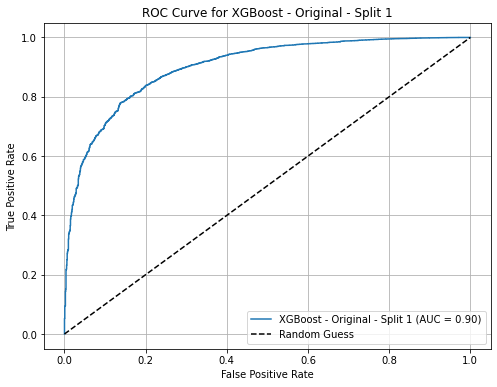


Model: XGBoost, Dataset: Original - Split 2
Results for XGBoost - Original - Split 2:
Accuracy: 0.9042
Precision: 0.8948
Recall: 0.9042
F1-score: 0.8932
Confusion Matrix:
[[ 594  760]
 [ 198 8448]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 44.51s).
K-Fold Results (4 folds):
Precision: 0.8966, Recall: 0.9054, F1-Score: 0.8935
Avg Duration per Fold: 44.51s


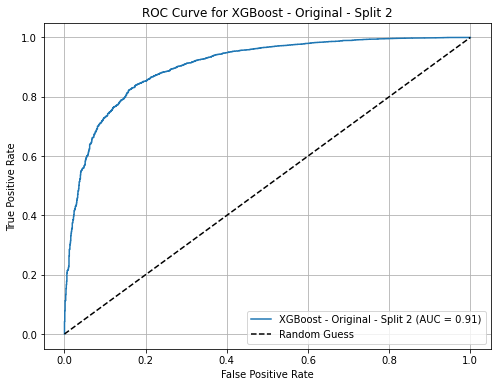


Model: XGBoost, Dataset: Original - Split 3
Results for XGBoost - Original - Split 3:
Accuracy: 0.9014
Precision: 0.8912
Recall: 0.9014
F1-score: 0.8890
Confusion Matrix:
[[ 560  793]
 [ 193 8454]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 56.44s).
K-Fold Results (4 folds):
Precision: 0.8957, Recall: 0.9048, F1-Score: 0.8931
Avg Duration per Fold: 56.44s


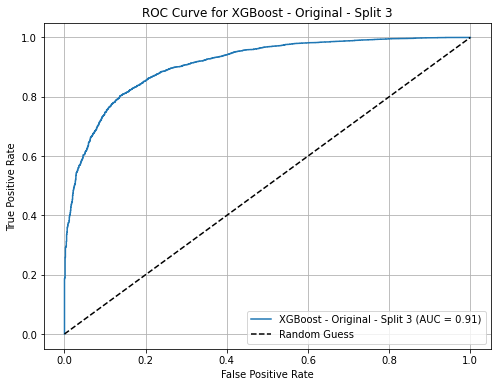


Model: XGBoost, Dataset: Original - Split 4
Results for XGBoost - Original - Split 4:
Accuracy: 0.9053
Precision: 0.8967
Recall: 0.9053
F1-score: 0.8930
Confusion Matrix:
[[ 572  781]
 [ 166 8481]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 59.13s).
K-Fold Results (4 folds):
Precision: 0.8944, Recall: 0.9038, F1-Score: 0.8918
Avg Duration per Fold: 59.13s


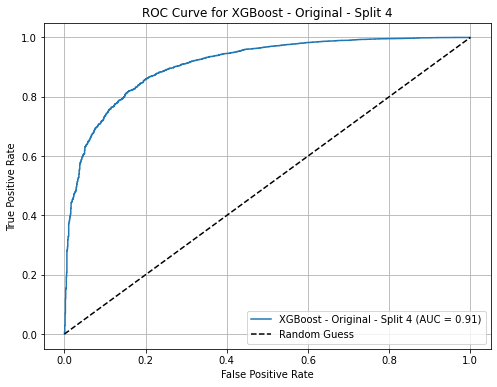


Model: XGBoost, Dataset: Original - Split 5
Results for XGBoost - Original - Split 5:
Accuracy: 0.9046
Precision: 0.8957
Recall: 0.9046
F1-score: 0.8922
Confusion Matrix:
[[ 569  784]
 [ 170 8477]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 47.53s).
K-Fold Results (4 folds):
Precision: 0.8936, Recall: 0.9032, F1-Score: 0.8912
Avg Duration per Fold: 47.53s


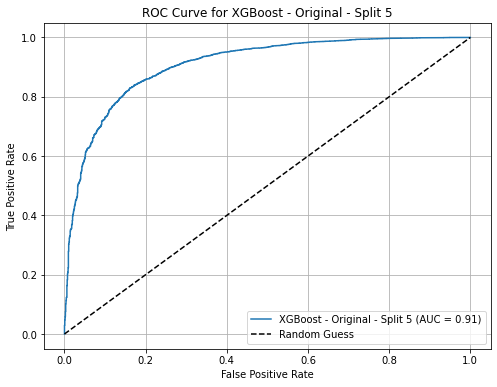


Model: XGBoost, Dataset: Lemmatized - Split 1
Results for XGBoost - Lemmatized - Split 1:
Accuracy: 0.8976
Precision: 0.8869
Recall: 0.8976
F1-score: 0.8813
Confusion Matrix:
[[ 484  869]
 [ 155 8492]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 30.80s).
K-Fold Results (4 folds):
Precision: 0.8904, Recall: 0.9001, F1-Score: 0.8847
Avg Duration per Fold: 30.80s


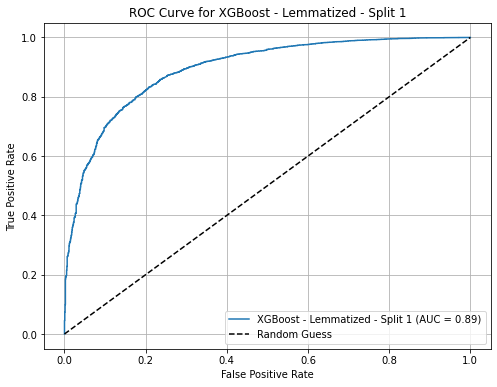


Model: XGBoost, Dataset: Lemmatized - Split 2
Results for XGBoost - Lemmatized - Split 2:
Accuracy: 0.9029
Precision: 0.8954
Recall: 0.9029
F1-score: 0.8870
Confusion Matrix:
[[ 504  850]
 [ 121 8525]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 31.74s).
K-Fold Results (4 folds):
Precision: 0.8923, Recall: 0.9014, F1-Score: 0.8860
Avg Duration per Fold: 31.74s


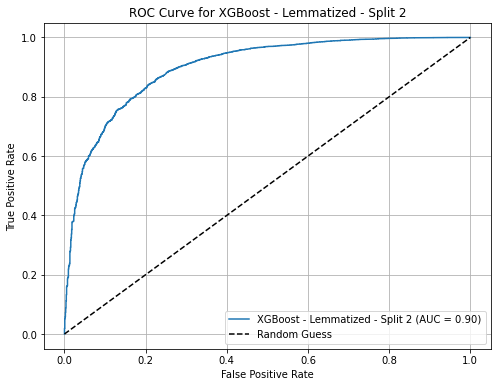


Model: XGBoost, Dataset: Lemmatized - Split 3
Results for XGBoost - Lemmatized - Split 3:
Accuracy: 0.8985
Precision: 0.8885
Recall: 0.8985
F1-score: 0.8820
Confusion Matrix:
[[ 484  870]
 [ 145 8501]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 27.95s).
K-Fold Results (4 folds):
Precision: 0.8920, Recall: 0.9011, F1-Score: 0.8858
Avg Duration per Fold: 27.95s


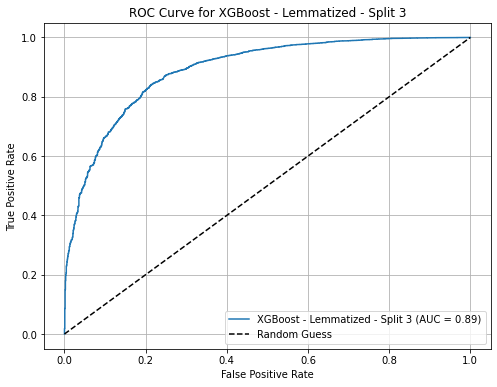


Model: XGBoost, Dataset: Lemmatized - Split 4
Results for XGBoost - Lemmatized - Split 4:
Accuracy: 0.8995
Precision: 0.8902
Recall: 0.8995
F1-score: 0.8829
Confusion Matrix:
[[ 485  868]
 [ 137 8510]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 30.09s).
K-Fold Results (4 folds):
Precision: 0.8920, Recall: 0.9010, F1-Score: 0.8854
Avg Duration per Fold: 30.09s


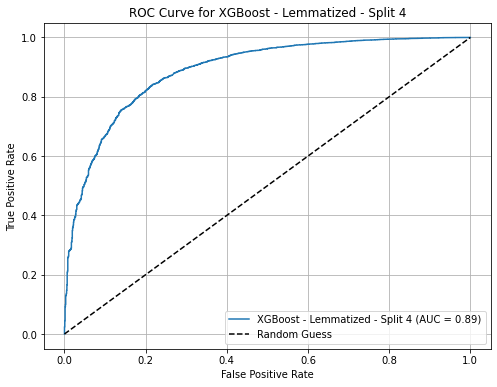


Model: XGBoost, Dataset: Lemmatized - Split 5
Results for XGBoost - Lemmatized - Split 5:
Accuracy: 0.9006
Precision: 0.8916
Recall: 0.9006
F1-score: 0.8846
Confusion Matrix:
[[ 498  856]
 [ 138 8508]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 27.05s).
K-Fold Results (4 folds):
Precision: 0.8915, Recall: 0.9008, F1-Score: 0.8854
Avg Duration per Fold: 27.05s


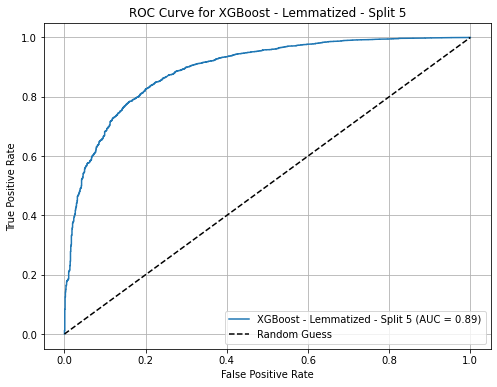


Model: XGBoost, Dataset: Cleaned - Split 1
Results for XGBoost - Cleaned - Split 1:
Accuracy: 0.9016
Precision: 0.8929
Recall: 0.9016
F1-score: 0.8861
Confusion Matrix:
[[ 507  847]
 [ 137 8509]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 27.06s).
K-Fold Results (4 folds):
Precision: 0.8918, Recall: 0.9009, F1-Score: 0.8855
Avg Duration per Fold: 27.06s


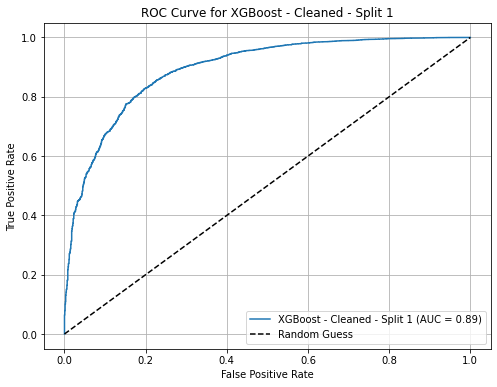


Model: XGBoost, Dataset: Cleaned - Split 2
Results for XGBoost - Cleaned - Split 2:
Accuracy: 0.9032
Precision: 0.8944
Recall: 0.9032
F1-score: 0.8893
Confusion Matrix:
[[ 537  816]
 [ 152 8495]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 25.73s).
K-Fold Results (4 folds):
Precision: 0.8925, Recall: 0.9013, F1-Score: 0.8856
Avg Duration per Fold: 25.73s


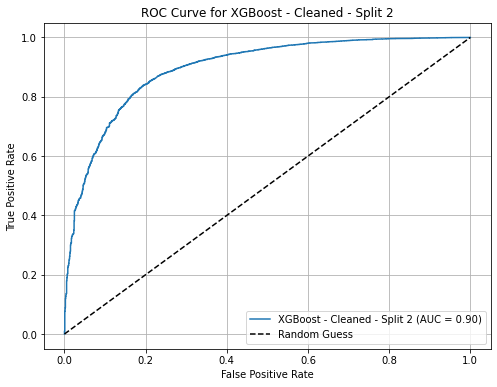


Model: XGBoost, Dataset: Cleaned - Split 3
Results for XGBoost - Cleaned - Split 3:
Accuracy: 0.9031
Precision: 0.8943
Recall: 0.9031
F1-score: 0.8891
Confusion Matrix:
[[ 535  818]
 [ 151 8496]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 25.75s).
K-Fold Results (4 folds):
Precision: 0.8909, Recall: 0.9003, F1-Score: 0.8847
Avg Duration per Fold: 25.75s


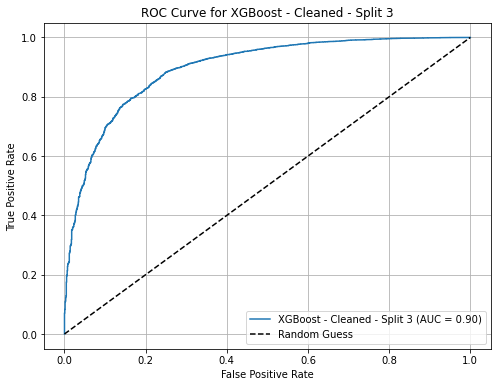


Model: XGBoost, Dataset: Cleaned - Split 4
Results for XGBoost - Cleaned - Split 4:
Accuracy: 0.9004
Precision: 0.8913
Recall: 0.9004
F1-score: 0.8843
Confusion Matrix:
[[ 494  859]
 [ 137 8510]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 24.64s).
K-Fold Results (4 folds):
Precision: 0.8907, Recall: 0.9000, F1-Score: 0.8839
Avg Duration per Fold: 24.64s


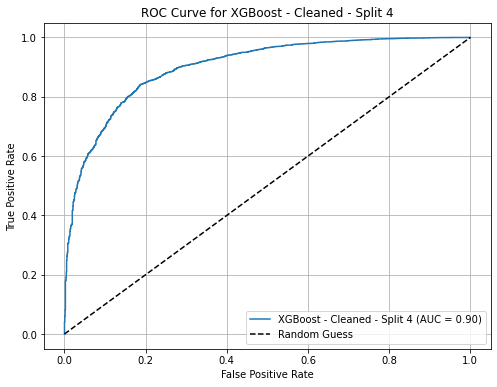


Model: XGBoost, Dataset: Cleaned - Split 5
Results for XGBoost - Cleaned - Split 5:
Accuracy: 0.9014
Precision: 0.8925
Recall: 0.9014
F1-score: 0.8859
Confusion Matrix:
[[ 508  846]
 [ 140 8506]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 24.44s).
K-Fold Results (4 folds):
Precision: 0.8918, Recall: 0.9009, F1-Score: 0.8854
Avg Duration per Fold: 24.44s


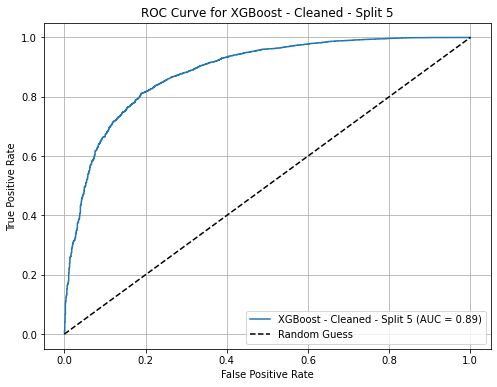


Model: XGBoost, Dataset: Cleaned and Lemmatized - Split 1
Results for XGBoost - Cleaned and Lemmatized - Split 1:
Accuracy: 0.9018
Precision: 0.8926
Recall: 0.9018
F1-score: 0.8872
Confusion Matrix:
[[ 522  831]
 [ 151 8496]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 25.20s).
K-Fold Results (4 folds):
Precision: 0.8917, Recall: 0.9009, F1-Score: 0.8854
Avg Duration per Fold: 25.20s


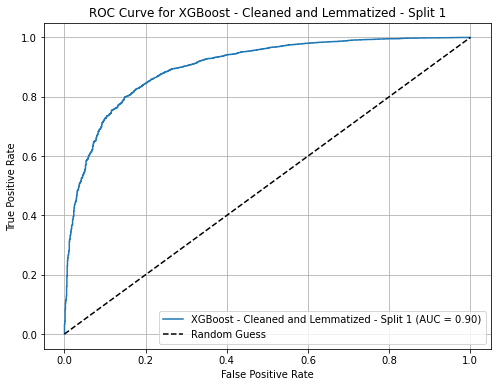


Model: XGBoost, Dataset: Cleaned and Lemmatized - Split 2
Results for XGBoost - Cleaned and Lemmatized - Split 2:
Accuracy: 0.8998
Precision: 0.8903
Recall: 0.8998
F1-score: 0.8838
Confusion Matrix:
[[ 496  858]
 [ 144 8502]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 28.55s).
K-Fold Results (4 folds):
Precision: 0.8900, Recall: 0.8997, F1-Score: 0.8839
Avg Duration per Fold: 28.55s


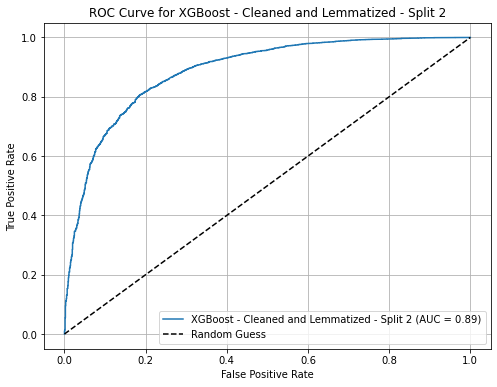


Model: XGBoost, Dataset: Cleaned and Lemmatized - Split 3
Results for XGBoost - Cleaned and Lemmatized - Split 3:
Accuracy: 0.8972
Precision: 0.8860
Recall: 0.8972
F1-score: 0.8815
Confusion Matrix:
[[ 493  861]
 [ 167 8479]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 24.05s).
K-Fold Results (4 folds):
Precision: 0.8921, Recall: 0.9011, F1-Score: 0.8857
Avg Duration per Fold: 24.05s


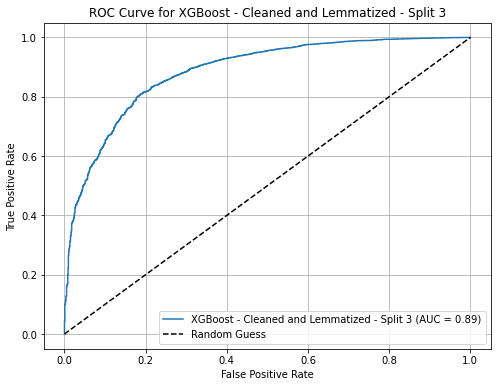


Model: XGBoost, Dataset: Cleaned and Lemmatized - Split 4
Results for XGBoost - Cleaned and Lemmatized - Split 4:
Accuracy: 0.9018
Precision: 0.8936
Recall: 0.9018
F1-score: 0.8858
Confusion Matrix:
[[ 499  854]
 [ 128 8519]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 24.02s).
K-Fold Results (4 folds):
Precision: 0.8907, Recall: 0.9002, F1-Score: 0.8846
Avg Duration per Fold: 24.02s


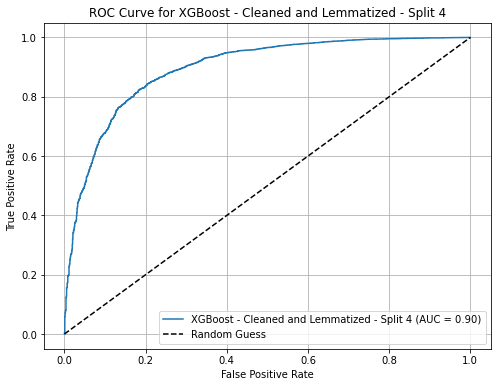


Model: XGBoost, Dataset: Cleaned and Lemmatized - Split 5
Results for XGBoost - Cleaned and Lemmatized - Split 5:
Accuracy: 0.9058
Precision: 0.8977
Recall: 0.9058
F1-score: 0.8929
Confusion Matrix:
[[ 563  791]
 [ 151 8495]]
Running 5-fold evaluation...
Stopping at 4 folds due to time constraints (Avg. Duration: 24.05s).
K-Fold Results (4 folds):
Precision: 0.8906, Recall: 0.9000, F1-Score: 0.8841
Avg Duration per Fold: 24.05s


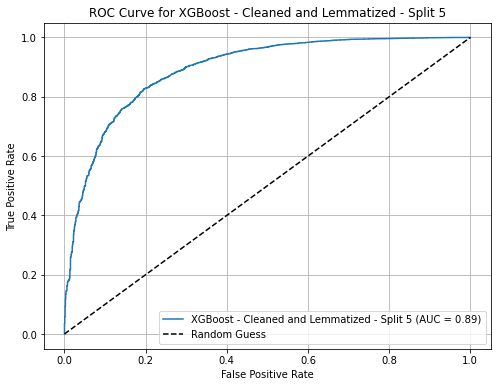

In [17]:
for model_name, model in models:
    # For each dataset with 5 splits
    for dataset_name, X_train, y_train, X_test, y_test, X_eval, y_eval in datasets:
        print(f"\nModel: {model_name}, Dataset: {dataset_name}")
        
        # Train, evaluate, and visualize the results for each model and dataset split
        train_evaluate_visualize(model, X_train, y_train, X_test, y_test, k_min=5, k_max=10, max_duration=60, model_name=f"{model_name} - {dataset_name}")

In [63]:
df.head()

_id      reviewerID        asin  \
0  {'$oid': '5a13282b741a2384e879a620'}  A3C9CSW3TJITGT  0005069491   
1  {'$oid': '5a13282b741a2384e879a621'}  A31POTIYCKSZ9G  0076561046   
2  {'$oid': '5a13282b741a2384e879a622'}  A2GGHHME9B6W4O  0131358936   
3  {'$oid': '5a13282b741a2384e879a61f'}   AMEVO2LY6VEJA  0000191639   
4  {'$oid': '5a13282b741a2384e879a623'}  A1FSLDH43ORWZP  0133642984   

    reviewerName helpful                                         reviewText  \
0          Renee  [0, 0]  I love these felt nursery rhyme characters and...   
1  So CA Teacher  [0, 0]  I see no directions for its use. Therefore I h...   
2     Dalilah G.  [0, 0]  This is a great tool for any teacher using the...   
3  Nicole Soeder  [0, 0]  Great product, thank you! Our son loved the pu...   
4  Dayna English  [0, 0]  Although not as streamlined as the Algebra I m...   

   overall                                     summary  unixReviewTime  \
0        4  Charming characters but busy work required      1377561600   
1        3                    No directions for use...      1404864000   
2        5                                Great CD-ROM      1382400000   
3        5                                     Puzzles      1388016000   
4        5        Algebra II -- presentation materials      1374278400   

  reviewTime        category  class  Year  Month  \
0 2013-08-27  Toys_and_Games      1  2013      8   
1 2014-07-09  Toys_and_Games      0  2014      7   
2 2013-10-22  Toys_and_Games      1  2013     10   
3 2013-12-26  Toys_and_Games      1  2013     12   
4 2013-07-20  Toys_and_Games      1  2013      7   

                                        cleaned_text  \
0  love felt nursery rhyme characters scenes qual...   
1  see directions use therefore make games unfort...   
2  great tool teacher using pre calculus enhanced...   
3  great product thank son loved puzzles large pi...   
4  although streamlined algebra materials extreme...   

                                           text_lemm  \
0  I love felt nursery rhyme character scene . Th...   
1  I see direction use . Therefore I make game , ...   
2  This great tool teacher using Pre Calculus Enh...   
3  Great product , thank ! Our son loved puzzle ....   
4  Although streamlined Algebra I material .. ext...   

                                   cleaned_text_lemm  
0  love felt nursery rhyme character scene qualit...  
1  see direction use therefore make game unfortun...  
2  great tool teacher using pre calculus enhanced...  
3  great product thank son loved puzzle large pie...  
4  although streamlined algebra material extremel...

In [65]:
def adaptive_k_fold_evaluation(model, X, y, k_min=5, k_max=10, max_duration=60):
    """
    Perform adaptive K-Fold evaluation based on max_duration.
    """
    # Convert y to a NumPy array to avoid indexing issues
    y = np.array(y)

    metrics = []
    total_time = 0

    for k in range(k_min, k_max + 1):
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        fold_metrics = []
        fold_durations = []

        print(f"\nRunning {k}-fold evaluation...")
        start_time = time.time()

        for train_idx, test_idx in skf.split(X, y):
            # Use indices to split X and y
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Train the model
            model.fit(X_train, y_train)

            # Predict
            y_pred = model.predict(X_test)

            # Metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average="weighted")
            recall = recall_score(y_test, y_pred, average="weighted")
            f1 = f1_score(y_test, y_pred, average="weighted")

            fold_metrics.append((accuracy, precision, recall, f1))

            # Time tracking
            duration = time.time() - start_time
            fold_durations.append(duration)

        total_time += np.mean(fold_durations)

        if total_time > max_duration:
            print(f"Stopping at {k - 1} folds due to time constraints.")
            break

        metrics.append(np.mean(fold_metrics, axis=0))  # Average across folds

    return {
        "Folds": k - 1,
        "Metrics": metrics,
        "Average Metrics": np.mean(metrics, axis=0),
        "Total Duration": total_time,
    }


In [55]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def extract_equation_and_interpret(model, vectorizer, model_name):
    """
    Extract model coefficients or feature importances and map them to original words.
    """
    if model_name == "Logistic Regression":
        # Coefficients for logistic regression
        coefficients = model.coef_[0]
        feature_names = vectorizer.get_feature_names_out()
        feature_importance = pd.DataFrame({
            "Word": feature_names,
            "Coefficient": coefficients
        }).sort_values(by="Coefficient", ascending=False)
        print(f"\nTop 10 Words for {model_name}:\n", feature_importance.head(10))
        print(f"\nBottom 10 Words for {model_name}:\n", feature_importance.tail(10))
        return feature_importance

    elif model_name == "XGBoost":
        # Feature importances for XGBoost
        feature_importance = model.feature_importances_
        feature_names = vectorizer.get_feature_names_out()
        feature_importance_df = pd.DataFrame({
            "Word": feature_names,
            "Importance": feature_importance
        }).sort_values(by="Importance", ascending=False)
        print(f"\nTop 10 Words for {model_name}:\n", feature_importance_df.head(10))
        return feature_importance_df

    else:
        print("Model does not support feature importance extraction.")
        return None


def train_evaluate_with_equations(models, X, y, vectorizer, iterations=5, k_min=5, k_max=10, max_duration=60):
    """
    Train and evaluate models with adaptive K-Fold evaluation, including model equations and word mapping.
    """
    final_results = []
    for model_name, model in models:
        print(f"\nTraining and Evaluating: {model_name}")
        iteration_metrics = []

        for i in range(iterations):
            # Train-test split
            X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42 + i)
            X_test, X_eval, y_test, y_eval = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42 + i)

            # Train the model
            model.fit(X_train, y_train)

            # Predict discrete labels
            y_pred = model.predict(X_test)  # Ensure this gives discrete labels

            # Standard evaluation metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average="weighted")
            recall = recall_score(y_test, y_pred, average="weighted")
            f1 = f1_score(y_test, y_pred, average="weighted")
            cm = confusion_matrix(y_test, y_pred)

            print(f"\nIteration {i + 1} Results:")
            print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
            print(f"Confusion Matrix:\n{cm}")

            # K-Fold evaluation
            k_fold_results = adaptive_k_fold_evaluation(model, X_train, y_train, k_min, k_max, max_duration)
            print(f"\nK-Fold Results ({k_fold_results['Folds']} folds):")
            print(f"Average Metrics: {k_fold_results['Average Metrics']}")
            print(f"Total Duration: {k_fold_results['Total Duration']:.2f}s")

            # Save iteration results
            iteration_metrics.append({
                "Iteration": i + 1,
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1-Score": f1,
                "Confusion Matrix": cm,
                "K-Fold Average Metrics": k_fold_results['Average Metrics']
            })

        # Extract and map model equation or feature importance
        feature_importance = extract_equation_and_interpret(model, vectorizer, model_name)

        # Aggregate metrics over iterations
        avg_metrics = {
            "Model": model_name,
            "Average Accuracy": np.mean([m["Accuracy"] for m in iteration_metrics]),
            "Average Precision": np.mean([m["Precision"] for m in iteration_metrics]),
            "Average Recall": np.mean([m["Recall"] for m in iteration_metrics]),
            "Average F1-Score": np.mean([m["F1-Score"] for m in iteration_metrics]),
            "Average K-Fold Metrics": np.mean([m["K-Fold Average Metrics"] for m in iteration_metrics], axis=0),
            "Feature Importance": feature_importance,
        }
        final_results.append(avg_metrics)

        print(f"\nAverage Results for {model_name}:\n{avg_metrics}\n{'=' * 50}")

    return final_results


In [23]:
from collections import Counter
import pandas as pd

# df['cleaned_text_lemm'] -> Text column
# df['class'] -> Target column

# Check initial class distribution
print("Class distribution before undersampling:", Counter(df['class']))

# Separate majority and minority classes
minority_class = df[df['class'] == df['class'].value_counts().idxmin()]
majority_class = df[df['class'] == df['class'].value_counts().idxmax()]

# Undersample majority class
majority_class_undersampled = majority_class.sample(n=len(minority_class), random_state=42)

# Combine minority class with undersampled majority class
df_balanced = pd.concat([minority_class, majority_class_undersampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check class distribution after undersampling
print("Class distribution after undersampling:", Counter(df_balanced['class']))


Class distribution before undersampling: Counter({1: 1662754, 0: 334386})
Class distribution after undersampling: Counter({1: 334386, 0: 334386})


In [27]:
df_balanced.head()

_id      reviewerID        asin  \
0  {'$oid': '5a132868741a2384e88de416'}  A2VMDDU4CCI4V4  B004BEEA3O   
1  {'$oid': '5a13283f741a2384e88046a3'}   ASOGKIY4EDNYS  B000GKD09C   
2  {'$oid': '5a13286b741a2384e88ef937'}  A2UJ5EBVFBHG47  B004NP0ZRQ   
3  {'$oid': '5a132862741a2384e88bda7a'}  A1UMFUJAOATANH  B003JPAOCW   
4  {'$oid': '5a132842741a2384e88130c2'}  A27KKFJ607JAR5  B000KHZ044   

            reviewerName helpful  \
0                babchie  [0, 0]   
1  Wendy Elizabeth Fritz  [0, 0]   
2          mammacita x10  [0, 0]   
3                   John  [1, 1]   
4           ButchCassidy  [0, 0]   

                                          reviewText  overall  \
0  I brought this for my 8 year old grandson for ...        5   
1  I knew my 2.5 year old daughter would love thi...        3   
2  Little tikes always comes thru.. Great gift fo...        5   
3  love the figure but title says it all.. no pla...        3   
4  I bought the earlier version of this lounge a ...        2   

                                             summary  unixReviewTime  \
0                                    Hess Truck 2010      1328486400   
1                                       Pretty good.      1401148800   
2              Little tikes and amazon what a team!!      1396742400   
3  Cool but where are my clear joints for BURST M...      1371600000   
4  They changed it - the arm/back floats don't co...      1372982400   

    reviewTime        category  class  \
0   02 6, 2012  Toys_and_Games      1   
1  05 27, 2014  Toys_and_Games      0   
2   04 6, 2014  Toys_and_Games      1   
3  06 19, 2013  Toys_and_Games      0   
4   07 5, 2013  Toys_and_Games      0   

                                        cleaned_text  \
0  brought year old grandson christmas thought ou...   
1  knew year old daughter would love complaint pi...   
2  little tikes always comes thru great gift gran...   
3  love figure title says plastics clear joints i...   
4  bought earlier version lounge years ago still ...   

                                           text_lemm  \
0  I brought 8 year old grandson Christmas . I th...   
1  I knew 2.5 year old daughter would love . My c...   
2  Little tike always come thru .. Great gift gra...   
3  love figure title say .. plastic clear joint i...   
4  I bought earlier version lounge year ago still...   

                                   cleaned_text_lemm  
0  brought year old grandson christmas thought ou...  
1  knew year old daughter would love complaint pi...  
2  little tike always come thru great gift grands...  
3  love figure title say plastic clear joint incl...  
4  bought earlier version lounge year ago still u...

In [67]:
# Define models
models = [
    ("Logistic Regression", LogisticRegression(max_iter=500)),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric="logloss")),
]

# Vectorize the data
vectorizer = TfidfVectorizer(analyzer="word", max_features=5000)
X = vectorizer.fit_transform(df_balanced['cleaned_text_lemm'])
y = df_balanced['class']

# Train and Evaluate
final_results = train_evaluate_with_equations(models, X, y, vectorizer, iterations=5, k_min=5, k_max=10, max_duration=60)



Training and Evaluating: Logistic Regression

Iteration 1 Results:
Accuracy: 0.8592, Precision: 0.8592, Recall: 0.8592, F1-Score: 0.8592
Confusion Matrix:
[[28674  4765]
 [ 4653 28785]]

Running 5-fold evaluation...

Running 6-fold evaluation...

Running 7-fold evaluation...

Running 8-fold evaluation...

Running 9-fold evaluation...

Running 10-fold evaluation...

K-Fold Results (9 folds):
Average Metrics: [0.85627435 0.85628274 0.85627435 0.8562735 ]
Total Duration: 43.23s

Iteration 2 Results:
Accuracy: 0.8559, Precision: 0.8559, Recall: 0.8559, F1-Score: 0.8559
Confusion Matrix:
[[28566  4873]
 [ 4763 28675]]

Running 5-fold evaluation...

Running 6-fold evaluation...

Running 7-fold evaluation...

Running 8-fold evaluation...

Running 9-fold evaluation...

Running 10-fold evaluation...

K-Fold Results (9 folds):
Average Metrics: [0.85641329 0.85642636 0.85641329 0.85641197]
Total Duration: 39.35s

Iteration 3 Results:
Accuracy: 0.8568, Precision: 0.8568, Recall: 0.8568, F1-Score:

C:\Users\krish\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:40:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Iteration 1 Results:
Accuracy: 0.8342, Precision: 0.8342, Recall: 0.8342, F1-Score: 0.8342
Confusion Matrix:
[[27980  5459]
 [ 5627 27811]]

Running 5-fold evaluation...


C:\Users\krish\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:41:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\krish\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:42:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\krish\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\krish\anaconda3\Lib\site-packages\

Stopping at 4 folds due to time constraints.

K-Fold Results (4 folds):
Average Metrics: nan
Total Duration: 180.98s


C:\Users\krish\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\krish\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\krish\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:46:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Iteration 2 Results:
Accuracy: 0.8297, Precision: 0.8298, Recall: 0.8297, F1-Score: 0.8297
Confusion Matrix:
[[27967  5472]
 [ 5915 27523]]

Running 5-fold evaluation...


C:\Users\krish\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:48:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\krish\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:49:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\krish\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\krish\anaconda3\Lib\site-packages\

Stopping at 4 folds due to time constraints.

K-Fold Results (4 folds):
Average Metrics: nan
Total Duration: 181.40s


C:\Users\krish\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\krish\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\krish\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:53:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Iteration 3 Results:
Accuracy: 0.8349, Precision: 0.8350, Recall: 0.8349, F1-Score: 0.8349
Confusion Matrix:
[[28138  5301]
 [ 5739 27699]]

Running 5-fold evaluation...


C:\Users\krish\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\krish\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:55:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\krish\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:56:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\krish\anaconda3\Lib\site-packages\

Stopping at 4 folds due to time constraints.

K-Fold Results (4 folds):
Average Metrics: nan
Total Duration: 180.23s


C:\Users\krish\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\krish\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\krish\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:59:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Iteration 4 Results:
Accuracy: 0.8324, Precision: 0.8324, Recall: 0.8324, F1-Score: 0.8324
Confusion Matrix:
[[27987  5451]
 [ 5760 27679]]

Running 5-fold evaluation...


C:\Users\krish\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:00:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\krish\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:01:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\krish\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:02:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\krish\anaconda3\Lib\site-packages\

Stopping at 4 folds due to time constraints.

K-Fold Results (4 folds):
Average Metrics: nan
Total Duration: 180.69s


C:\Users\krish\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\krish\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\krish\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:05:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Iteration 5 Results:
Accuracy: 0.8339, Precision: 0.8339, Recall: 0.8339, F1-Score: 0.8339
Confusion Matrix:
[[27970  5468]
 [ 5640 27799]]

Running 5-fold evaluation...


C:\Users\krish\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:06:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\krish\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:07:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\krish\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:08:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\krish\anaconda3\Lib\site-packages\

Stopping at 4 folds due to time constraints.

K-Fold Results (4 folds):
Average Metrics: nan
Total Duration: 183.60s

Top 10 Words for XGBoost:
               Word  Importance
2559          love    0.017906
1213  disappointed    0.016104
3103       perfect    0.015858
696          cheap    0.015805
2560         loved    0.015559
3623        return    0.015036
4825         waste    0.014238
2777         money    0.014197
2310          junk    0.013845
3228          poor    0.011006

Average Results for XGBoost:
{'Model': 'XGBoost', 'Average Accuracy': 0.8330307878642882, 'Average Precision': 0.8330629819206286, 'Average Recall': 0.8330307878642882, 'Average F1-Score': 0.8330267283639575, 'Average K-Fold Metrics': nan, 'Feature Importance':               Word  Importance
2559          love    0.017906
1213  disappointed    0.016104
3103       perfect    0.015858
696          cheap    0.015805
2560         loved    0.015559
...            ...         ...
1807        gender    0.000000
180

C:\Users\krish\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\krish\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
